In [1]:
import pickle
import base64
from io import BytesIO
import io
import numpy as np
from PIL import Image
from tensorflow_serving.apis import predict_pb2
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.core.framework import types_pb2
import cv2

In [2]:
def create_tf_prediction_request():
    channel = grpc.insecure_channel("127.0.0.1:8500")
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    return stub,request

In [3]:
st, req = create_tf_prediction_request()

In [4]:
def prepare_image(img, im_type=None):
    if im_type=="classify":
        newsize = (224, 224) 
        img = img.resize(newsize) 
    #Function to load,normalize and return image 
    im = np.array(img)
    im = im/255.0
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225
    im = np.expand_dims(im,axis  = 0)
    # print(str(im.shape()))
    return im

In [5]:
img_data = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAFoAoADASIAAhEBAxEB/8QAHQAAAQQDAQEAAAAAAAAAAAAABQMEBgcAAggBCf/EAF8QAAIBAwMCAwUFBQQGBQcCFwECAwQFEQASIQYxE0FRByJhcYEIFDKRoRUjQrHBCVJi8BYzcoKi0SRDkuHxGCVTssLS0zRjc4WUo7O0Fxl1k6TiJik3REZUZYSVtcP/xAAcAQACAwEBAQEAAAAAAAAAAAADBAABAgUGBwj/xAA7EQABBAECBQEFBwQCAgEFAAABAAIDEQQSIQUTMUFRYRQicYGRBiMyobHR8BVCweEzUgfxghYkU3Ki/9oADAMBAAIRAxEAPwCslWZP3iNsx/FjONevVyudhlLD17Z0QR6eJzTyrlfXTSenVZyqD3Tyvy1x1OavUro6ONRFFh8/jzpB6qaocyuc50nVCaFCVJCHup7NrajlBYKVAB1FE5oqmAS+HM+3RwUNLU0xmoKrdLEP38Mj7XQ/y/MjUerjb432oSXH8S4K9vUHTm1kJipir1SQqyYf+IHyPqPh56ikqfSJcYkgq4pVnhUlWR1DiMn0JHng/lravo4jKk9N7kEihlPkvrk+WkoZLtaQZJqdjHKhQSMmUwfTRiwyrUoLe6B4XJJVvP01EmeqlnQ1L1JYrjb5zR103339zBLC4KhnBGDx357fDRHqmlgtb08dAIJ4lkzIMhtkn8XYnzyP93Q+KCqp4nio4ZlWSPwgq+9HliABt8sk474+Gm8FYyxChq5ZEiQsCX58GUMRjHnrlSQ1I4E7oJUls0cK0330UrxCU4CyDDD3PMf7/wCmndb1BcamnioHlCQRrsURjaT6/pn8tSvo/pKt6ltVVe4o6ZbZAZVjlMhw7RqCeMdjkAHknyB1DOpGsix0m6IURM4yyAuWHc+754Hx7keRJHGjmHNMbUICym1dHbK6RqqFCZ2cvv8ATOOB5444BJxoK9TOeo6S008j7WR3qnc5VEGOPzwfpqe2mpsNBFVX2rssMUMCiOjoxIWVmYcbmOc8YJ4AJPAHYOz0/T0f3ahvXS1PNcZ4RNIxpGWWNG5RiVG0gjnPvN89Dn4jFjkc01a7Yg5WKfeG48oO37dlkgrLTaYqj7lKjLE0kcySMpwfEiYDOd3AB42nzxjTqWitvXNlm6z6LSO3S21JDebRNGzmnZcZlhI5ZD/Fn8OBzjACUlAlrrjWUSR/uyNyxPujdWAYcnCAYKnJII/h54I2j9oNTTWeSkjsFIaaoiqIGaOdo9yzptk7cZII5A7gHQRmwZBpjl5k+68tFBw8eD1+qeV/tfunX3s8tto6lCz3Dpe6LHT1jyBfGpZFbnGO6FFXvyGXzBJYV/WPUVTa6Tp6lrkorbEs0koSBJkkP4ySJAxwFDk4GBjtzqK09SaSCYQuKeFAXVQucnzGfNv56C3KaruZdVqHjamj8Xcy4wpZVOP+0D8gddMYzSwB4BrpflPA81Rqvhmmqp6yGrggjqt5RpiUUrnGckeW1/qpGmk1Tdbd1BHdaSGiuKeCm5ZYllik93D9/VgdTe+2tZ6GnmM6XKKipfuyCBM84IEjjyIzkj1APPOYy6KKaGNKcxmHfETnIbDZB/4v01rl+UxFLXZOZbf0Lc7qsl3oq21bFH32CnKksETAWEtyrFwFzyOc+XInpu1Wqou9LQ1dS9LSTTLC7oA0iRE88nvgZPl21NofZlDd7bHXdOdVUNwrGTM9NOPuxSXzjEjEoSSDt3FS2MgajQs72yKT9oqYKly8SwYBZsY5GDg9/wAsaoTRdcdx9bu/oQD9UvFkwTucQ/cGiKN/Q0VNr5FP0O116IAeeho5oa6hn8Qjj/q3XHukHeu5cYDDI+NZ3WgtiyRlEE1TIpadn58yF5PJPBJOfTUkuVxr5Y54obfPWpTxR2sVEY933CpLFvP3wxHwIGcAaD0D18kXjUkNGWP40quGQDucH+Q511WvtokPU9foB/hMD7poHUoslnpbh0BQdPUFvY1AuFRU1E8IZXHiKgSMnOXChTtBPcvjlsaDE19NQVFI8ckVRFL4Mkcj5O3BPbHHCgfTVh0UlvtNlSKlu1plzC5mwdglchSoCnlF5YDPHHfUVu6W631UlXTUkKVFbTq8SB/E+7K2ec/hLH6gaPbTHrIs9h3/AGodyUGWR+1jvaiUSGIuKyAtE6lSPnp9cukZ6eilNPViUtD4iqYyp3f3ee+QSNNp5GlYoTwdSC/XeOroaSnpIWpnoKeKklAbKOUXAZfh30tJkk1srDVXsUFyoKguXQSJ2I/Evy+uPy1u1b94Hj1TuZ3Y+KWZmLN5nkk85zohKhaOSZ49zv23HBGmP7PqJmVjEAWYKPix7D6nj103F94j6exRFIS0MCQrH4RaSRdsahsFc8n8R7efby0zu7mCRIgedgbRr9qUts6TkoxSqtfJWBGZZG2+CI2XBTcexKsMgHPY4zmJVM8kytPIxZhqoeabL+l0PgP2FBT2WLwkBJcJ51pohud/wg8Z0VstglmWavucstLDEHCSpTtLG8i90LKfd7jkjGtKRqSNI3qFkDNHlZI22tGx/iB/ppzTUkrxzQQXGZqCVxIyZHvyjgMQQcHyOmGzQwODpd66Der9ao/mrLdLSyPa0jUD92ZB3A40jLdqOBgsFukpnbmVC2VLeoyM/mTp7LQVU+YaSCSd/JIxljorbK+qshWxXu1wTRr/AKynnH71Pg57AHPYnJxpR0rtJc0WltPKUXra6GcARtn11PvYf7A+oPbbeLjHR3eksllsdMau8Xerw0dHGVcp7uRuLFG8wAFYk8YMP6psFooWjr7BJIaeZyJIGGBT8ZABJJIPPOfLV2dD+0rp21/ZPv8A7N7fPNbLjeOrIEu86HxHlo5YN4YABTjNKYygI90tzzqtUpa18Q3Jr4Wa39EzBJTS3xuqLp6SKCtq5Vq/vdrhZzSyz0wT71EDhXMZJ2ZHOMnHrrOoJLZULS1lrp4oPGQmVI1ChG493AAHHr56f9RW1qBfCWenPjMFVY5QxIUAFiByoYjIz3zxnUfqsqyxD8KDGuvyfZ3ljjuDR/f4HskzJzeybMMkP3bXiCsWUvEB72lFA89bOT5HU5yyWlPrlHFSOsUNw+9blDEiPbjIBAPJ55/T46FSqW5K8HRGzWqqvVctLCdqZzJKRwg/qfQf0ydavTqIGxzsYrqEgblSKBwbqKb0FRT0LSFYNzSJs79vjpW/dJdT2+30nUlx6fuNHbbkWFJU1FK8aTFcbgrEYOMjOPXUy6f6gsMtmpLf1DbYK37pMskageHhVbOCwBPPmQQTx6anHte9s9+v3R0PQn/3SYLtZsKfudLRK8caKF8JRMx8RigBG8nJBwRjvysga3B0QJ33uxQ8ixufRU2R2sNc07+Bf6KgYKypoUdaeTwzJG0L+6DlGbeRyDj3gDkc6QjwPeYZUd9Om5bKIp+Y0n9zkXDvTpKx53N/y7DWgHaQ1xJ+Ke02ndkvIsF0gvVHEVq6Xc1OxOVWQqQrEeeCc49QNCq+rq6yqmra2oknnqH3ySyHLMx8zpzM1bH/AKqHH5aSSmqao7p8A/y0LTur0hObJTR1E+517DUjNG0dK86LkKeRuA7/ADOottnpZDHT1SK/GAr4OiVpuUsLvQT4liZCFD84Om42ODS5oQJWp2tZQ87ny3lot0pPc1luUdmiRpZ4lJZxnYqkgn/iz8wNQuJtsvY4zxnU16NrjarrSVKiPbLII5d65ARvdJ+mc6bpKZDfuym15s1VbHWCplgEhTcwEmdvJGPXy8hoJJEsXuzMAzfh9D66sX2t00NNeaVYlxvpyxGf8R1Abi0c9KAFBki5U/z0nM02l8c6mB6ZVaxfdm3rk+WgyxTTOIgmYz3GiLszqQx15EBH73kdA5m/RdAOS9nFLHdI56+KCaCjRXeCWfwvFwcbQ2Dzz5jHrxyELnTVcF0qo5KVDMXy6U2JFRsdtyko3+7xrHUF92lqRpj4nhVPhbU3sd2OB3Px+Xf4HXUGVUXLpQvrdC2krqaUxSpOg8jJCUz8s99Eoq2I0ogkhDY5Dbsfp21Z/Q1zsnUNqrB1BBTOaCnH3hmgBwFzhufMgjPqRqp6hY5amWSBlijklCqHJ2IpJwTgE4HGcAn4aWiyDkylhFUhxTnJJsVSJy3IRRU7rsqfFT3gy42/3l459Oc9saedN3/qLpqqmrrJUeA1TTvSzhkWRJYnxlGRgVYZAPI4IBGDqN7fCqDFu3bfMfhPyOiyPVfefuheBAB+Lxg2fy4/XXV5vK2RZWKX9b+1XqPrOiip71PFEtN4hSKmhSNXZ8+8+BywzgHg4+ZJQ6Q66uPT9BUG332ttpRBIyArJFOwznAZSseF9Q2SBjGMaidQ0aTtBPHkqcHTinJon+8iqkSjCnxY4hl3XjK48x66OOIZBeJHPJcO97/VB5UfK5GkafA/lfkpjfvaN1ZXQxzU/V10bwkDOHRIahFcAkZhGY88fhYZx8NQY3NJKKO3Sz1f3dCSESM8E45BYZzgAenHbk5deFU19tnuFvoIVpKZRJUMFBOMAgkHz5Pz0wjtd3q0qJbZabjU/d32u6058BRgn3pEYqDwePQH00x7XNkf8ria8klFhiZDegAX4ACPfs+XquurI+n7Q1RHQJNVVkkMgjWCJdoDtnuv4RkYOAT8NR+ogaGeKAyIXk3bxhx4JBxtcsoGSMH3SRgjnPGilHF1BQRftBvEpkji2zERlDLGO8ZY8tk7cZ4wuPMZEvWVVXK0lLEE3uKg4OWGSx257keuBzj5Ah1bq4pH72QR2/2USulTapYnpa946qrqKhJJnCMrQKBklGzzySDlcYCkHkgMIUhqpRFK6Qk+6PDTLFP7mCckjzGSQOcHnKFvo5bhMSlK9R4R5hSYqz5z3zn3RjnGD250/qaiSnpWgEdIjlUR4o6dQ29BgHectkc5wQDnsMA6mpG1pnPFUwUcE1zo7gsEhYxSVETRow9VJ+Gfy06t8tK9TTLGR4G8FwB5B92topKmsp0pJ5CIGY+Ah/1SScckHjkZA8skduTpKlt1KtSqNvAPB2NjGgkoBerGszUj9edMWjqGtiNov1ZSePOjA+FQtIFdyVJ2bf3nx9zOPLUp+1TS+z+xe0OKy+zk0JpaKjRa8Ucm6ETuzO4ypIJKmMnk6gD9MWa12aiv9N1H90r5o5o2XxGLKpK8EKc8jaRxnBzgAgkR1KPEtkklLNSTU0NQZGZCzTxDjhiQPdPHb0/OrXGjY1+VHKwn3QRXY3tv5obfNCIrnLLMiSxO/wC9MKhFyqKO3GrZuPQt2oPZfB7SJ5YpaStqjbnVWy8eYS6MP72Bn45I4OeKs6eiV3kny6S+9JGRGG59OfXRunvc1RYJ7Vc66pkWjqTVCndyYFXAGQv1UfXUtOTl73BrDVHf1HhMpauho3xbnqJSrqyS48POO+Rznnj6aISmxVfT3/m9ZaWox4c4DAliAQvcfE/z786BsZqlnqPu6Rq7lgFXbx6Y7fkBpWbqOaqssNpqbTRRPSO6LUxw4klTghWbzAO74+9341LV0revNvip5mkjz+ekKerp0KJLGfi/fH01rWm4VKPM44HlnTCGnqnbDrga4y7XKKK1xoKiBijEk/DGg6qI2wPLT56Zljx202NG8h4IzqIgFJSWWlnhK1A98/xZHGkIEo1mBB3bRrJKWojBK4PHlpOGGVn2+6j+RA1FaLS32SOnSjhqFlgYndG6MGX8/wCmlIEiqmSO1VqxuRzATgg6D1MFTuMtWNz4x4i9jpGMPu4bGOxHcahQXtVgW/qLqHp5VMs6TxeituI/p+un69a0dwFVHFZY1NUwcq2MABgeOPhoH0tFVXlWoZKsNC3vTb1OEjUEl2YMOBx68Zx6EpabNRz16J4ETRoBgq7gFT38gfIdydc17d0k40rE6T60vFjoxWU3i1FrqDIi0gbCBwMFl4wHGe+MHsQRqOSVNfWxyNcSJsvtjkIVfB3MCeFHOdg0ulgoLclRDDeaxaOaNyi7vdRsHO8eeRxnjv5njWlkuQpY3mgripkk2fhByo7Hkd+T7vb56VMLNTniga7967D18LOpGrXQ3K8UstLa3ppEhChzLOI1R2Q5GRnPBx9NSdPa0kHhdCe1Xp+rktdJtFLXRhlqKY+TIy+7LF8DjjPJAAEZt8dFHWvVU7ujTJ4bRocIX89w8z/THpp91LUussETptYhpTz/AHscfpri5/DIM1uidt+CNiD5B6g/w7bK25z2u0O3sUoDferaUUlRZSwhpppllYU8bLgKGAQMMgAFgeM859dN7f09eLoP+jRT1LlN8UNPC8rSBQAQoUH05JwOe+n3UtJTeHTTrWPIYpSk7sgJJTd74UDAztxg55IGtLZ7Wx0x7SrV1dJW3PwqKKKgnpKkIyPAsexUDAgKON3A7jPcnVujfiRVjRhzgNr6kgAAX8B+Sj4tTdUY7H8kRp+i5rnaheJK2OGFA/7sSgOu3ABIyRhiwAJHroD17ebLdlijjoIoQyr49JTIEiMiKqB8ADuUZsernUy9qlrii6qqaLp+qgahu6pX0pWUBFVxuwT8yT59++oldfZF17S0rXB7U1TECo8SBhIpyoI5H+0o9csOO+t4HFY58ds+XIGaugJA8X+q5+DM1v3kz68WoBWtBG3h26adQnIjLkKPr5nWUtcZYqmimoQHqGBR4wf3QByfPLZ7cnRvqD2cdadPwS1F3sr0ojIBRnXfz/hzpS+z2OWVKLbJb1McZWaOHLJ2bJ57k5/yNdIZEUu8Lg4eQQQnHZbXvDWEH4IHSiussv3y21BWQd8KMkehBzlT5jsfPRUdbzJSNGYWlraeZmh+9N46UqDBKxhvVvXgbRxgZAGashopxmtarKk+EY4srIw7HdnyODgjPr302tUcNdcoqeeTwY3LPNMVy0aKpZyB5naCQM8njPOtTMaW63blNtgYXCR+5R+3XUdLXKkuFwpKCpgZQWjnO+MllDKSo5Pusp8xzzqy/ZUPZjD7TIz1O9uremrwJad2miz9xdgGWXLoh8PcoXdgFQx5xk6ovc9dVBAzFD2BPGMaL26kqZLYZIqKrlMp/wCrgLAAcjkeeSMjHGB66xLj620X0SK618x6ptotSfrOh6bs90u1tp5aSshpqmSKKtp5SUkhzlGV0yp47ggjUXqxbYIpJS1VMSm2FRHtRifNznsPT46d9R1NkeSmqLZSS0MVTTRv923Myh1G12BJ/iK7sYAAYY40O8KhqYGlNVOVXgcgDTrAoIdaZ01VT05l+9UJqN6fuyJNjRyAghuxBHByCOfUa1mrUqa0wxklG/F89Yq0fbx3b56yeGm3Rm3FISEAcszHe3rznTOkFWMWQODq6JrX2+aFDLECyg6aVNZNFS08MhzJF78bYwV9MfEevf46PUV1rqCnr6KaZDBXpskLgqq+8CCCR3GMfInTOKY08oqaGUEqPdf/AD/nIB7gaXjncHuDOgP1QJpdfbogtTQ3HCT1sEqCXPLqRnHz0mbVN4STIiNG+cFXDdvUA5H1Gitb1PfqsmOSulJ3s/4j+I9z9cDW0T1CUiJUHLHka7DpH6A57QL8KmvQWel8KNSoOMhT8tKx1UVPTmFJnBJ/hONKV8oWn2+mhSzI0IjI9/cSDpbkNmbqd1RNSKVtz++SI5j2pFGkUa98Koxz6k9yfU6QqJa66VT1s9XumfG6SQks2m7SDwwvppNZvD7njSzRykvL7yeNUVBgkppHyrggjQ8pIre4cH11JLl0xeLNU09JdqQU09RTx1axmVHPhONyMdpO3I5APOMHsRoh0z0xYLlUvBfqyspk93bLCqlEHOS+RwO2PrrXNWBkV2UCYv43vEn66XMIKZwdSm59L2iCvMNqvsVbGFZt/hlO2OOe+c6Hfsx2LbWjVI1Lu7thVA8yf6d9XFMQNLVBLH5/IoC6FTnGkJH76eysreXGl7bRWiqqQlzr5qKHjMkVOJiOcfh3L6+um2b9VozX2Tay2S89SXeCzWOleoqp87IkGWOO5+Q8z2A5PGkJZWhdozzjvqT0337oypkvvTV7o6uKWnmoxVR5SWHxVKODG2GBKMy7hlQSMNnGYvLiaVpP72hmRuouqmH0IN/3Xfyrv5VJrJUHOQxHy1jTIabg+83lpGrQKePPSdO0Z4lz240zFHEbLbPxW2upLUzIrhZWxnJ07igr5AtUgbwwCRzjjQxD4siK3dmxn01L0gjusEdNbqtoaeBQhhBwW+OqEIk2WZHWgD3GKTMcRDSDjbjH69taQwTVVO9UJ2hWN9rFTpW7WuO31ojUYLjJzpaliCUZgL8Ngscd28zoRxWwvoIOpM5kwAY6lapRxvVQCD5g4GkoTMH3JkH10QZokXGT+WkdwYnA0wyQdFgutezOkiYkUbh2I76VpquWJRKjFSo4I8taRRePMke9E3buXOBwpP8ATRWakpzboa6hhkXaRHWQyPkI38LIe+Dzwe2PiMkL/CrqnN7uVwvlwrLvXSb2aQhR5JGOFUfIcaBTzDHJ0VUGallgDbWcZB0I/YtfVFlgSSTZ+LapbHzxpUiR341BHSYh13ZJ4zpN5hv2qfd8tb1VDU0jmOUYYeXnpg4bOdVy02GIgjlsAd9KKilSG/EO40PjlljcfPRyipDPD4rojZ82fbq6W3R0mayOlPUU0MjKKlVVwD+JQ4bH5qNLokXgxoItrLnc24nd/uklf00ZqOm7a9PLLbLlG7wqZGwrYx8c9tR+oM1OQC4cH4Ff0I0eRtUQsagOiRvFZLUXV6uWKGJZMYSGJY0XCgcAD0A+ufXTMSFZNy59RzpatPiAE99NHneVlQtudVAGFA/lpjdzQ5x3ROqLRTQyUk9TUJvlg25y/LZzjOWztGOcDjjWpeSsiNPT7HckYVGLfoBuH5dwfTSM0MlLS07y8vKhYv5n0BA4BBA7a1F4q6OFTRXCqFQuQJTwoU/iA9ctu+GMcHPBYVVLepoa1KqC3yyx06Tg43twMAdz5d8D440r03XXahnaqtt0qaN4lLhopGXt3YYIyQCcefftrRUqKGCjp2WMmth8eJH2MGjPY/iyM/Q4x66TmpiCHbYjH92BEuGy3mOee3z57jTLNlkhObrW3Csrd0tTVVtRJKY6WWednzBxj8WceYIHHGnk1RV2v7rbqqOll8OnAE8ZDxpvIfjB5P8ACc4AAHOo9HWVhq4iKl42jYMrKx4P1J06qPCjpwSzkqSXJPJySfl5+Q1klZ0p0IZI5ayGmqKSMyOEV2IY5yBtGSAM57+WO4GTpbpiw3e+1VVBEWqHgpaioqDvO5IYyFdxyMgHvk8AZGgVbV0h2ClhdcHczEbSe2Ap9SOdLi8XKnaor6a6VXjVyulTJ4pDTK+AytjGQRkY7agNqODtBaw0fKM0MtL92hFVJPNDR1GxQKh4pXUnPC7Cowcnse+tGMdKVbOI+Vcn3WRvMENjQOlkKSq5P4ckfkT/AE07kq62qhMK1lQsmRLgnO5h3b1LH15wATjWXNQhHSkNHWx0wpbfTR1VRHXjbK7oSjMfwhV7AjnlWJPl56D1kksx8CknkiBP7pFc5Y+mSTphdZ2SuWDnbToAzHnxSQCWPwOeMeXPGdFbHdrnNcYpKOXwZkDCKWIASHJJOT3J5xn01mlNAjTuOaJ4Jacq8TlCUR0KscYzwRotbLjZXqvFmt0kVQFaRHSpCqRs27lBAIySSGBz9fe0wrbnVipjhrBJPHySyLlg2OcAcknjgEdtITrS3QJJQzu8yrsWRoiN30GdSkm4WVKunurILHFPNT296xJoJ6UvG4VTF7uQD3U/4vdYfwnvqLXOSy3W6max089NDMqFoZZA/hMEUFQw7jIJGcEAgHOMl7ZbHFc4pbfPXT00dIn3iQGbChx3XGMMWJUDJGPjr2e60EENZTtIhkk8AR5TLNEgOBnyycEnknaM6lIJEfNJZ12tW6iVTD3kUjzBGn9NBHInvAZHp5aKJaJiuPDH560mp5adAphRQvmB315m17HlIBcKGb3ti8aFLE6nZ56maQLKm5+3nofXW6nZgYQAT340fUs8lA0t9ZMwKAYPqdetQNRnxKo7B23eQ0/qaauo1y4IQ+Y03eZ5Iwsjs4/xHW2uS7oyExqSWaSnkao8NuAr4Cn44wcjTeC25mCCrhUH1btopNaUlwlLSGQ8nAbBHrjXlNaJhMSELBeCGGG9OR5a1drBanFolmsNVT3GGShqVbcJID+8KjtzjsTngjPnqVUTXq6VMUyUrU6Sk4ZYTxj5aib01RT1arTQmKQDlS3ut8R/dPx1MKO9VFdTxLSSyLHEw8Ih9pjx3Rhjk86QlSkrVIGtddTOs1YHqUj/ABSU2RJHnzII4HrputtpKiSWQLO9SfwvNKSc/EDA+vOitDeZ6eNg1Ms0xYsGdGZEB/vYIz/P0Gn1h6aFdbl6gprnBVSVBCTRw8+FjOec/wBOdIuBJXO3UcS+tT3gC4pKsCkGTchyrAcNwDnRrqi52WO3/wDnm+ViKw96KgphM7ofIlnXByFPJ8uANDepILzZrxPb/wDozUVTCI5H/G0qBtwz6Hnt5cHy0HpXjlrjLcoRVwsyloc7d4ByVJ54OB5eWtozGt2kcE2pZ6i8Cen6LS91byFRJStT+8Fwx3K6swHY8Dk5GCOdZT9Bp1Hba2qFwjW4R+HG9D4bSSK7c7nZiCNm3kAH8Q1LKKsq2ke7V1LO81RO8jkRHLMcfhHoPIDgDAHGgFzvNyjvlf1DRxyUdY8bQMz42SZRk3n0OCPmQD65FkMklZoiIB8n9K6G/Xp233DccwlsDZR2+2mvWx0lDLXmugoojBkMd3h7iy+fIG4gH0Hw1ILf7RltHsWSxQzzRzxXskMrnf4abJFAYgnAcrgf4fjqS+z2g6Lu1j6sg6u6ktCywx0klE61OTL77mdgvBLAKhOM8Dy8656mezPJ94hhp6YJlaeB8kRxdhIM8F28yR5epJPm5MSJ8oxZgXBhDrHQlc2fF5sbY9JO4dt80HuPXd26j6qe/XGQqZ5CWRW9xVIAYKPLJGf/AA0Ov9qeplmrkvdH4dOiDwi+ZEjK5U7e5HJBx2PGmkMVG0CslWqVD5HvrhEPrnPOn8FnikvlJbp5o5Y6mVYyVOcbjjn469By2dGANAGwHgdkduK2Fwc0dAB8h0UVKEnMhBA9ex0YCWH9k+MPEjqkYe4FGw/HAxjnP5aMXAWSpqKygpbesO5WWGHOSVXzJx+I/rqP/s+ZvEhqVKtC5RlB4Ujyxquc07OsfFOtkteWUxpTMi0yRyZG6UyZ8T04xxgcdz66yvv1ztp3UdY8LscKV8zrII1kL0TECNlLNlQc4+emdwUspjCOTnILDGjtLpPwtB+KbjenFbeTeRtuEaLVEe5UIgQk/EABSfjjQ1qqq+7LTM/Ck8jjPz+P9APTStMGbAqIgWBwnPZdbVsfhu1M8WydRwh/qfLRGEhEbLXZJUU6xyOsxOx027v7pyCD+micdAjTSNTTtW06bRGY4yviuQCAQTlQM9+T6A+TC1U9O9xjprnFJ92kYCVohukC5BIUfH56kNwvXTloqC/ScX3gVdPDN40q4MbFc7CvPI3c89x8NMhji2wUPnanhu+/yQ/qCGmp5Y0aZ2qNuZ6dGbbA393eSS59e2CMc6a0dLLWBIKVS0zklQThdoBLMW8gAMn4Z9NDYY6gnG3IHno9ZBMsNxiEDmSakaKnZVLfiIWTsP8A0Zcc+vw1bdMLQAElM7llCozCaoiIhinw0+jnHKVMCSRnuCMH6Hy0hcLj4lyaWqo6WkfzSBSFGAB5knyz6ZJwB21rXziKQxr58j/ZPbR3uLgpFum1+t8UcSy07Fo5QdvPII7g+h0ASiqPE3hQdF2TxUaMrkMyv9Qf+/8Al6a2USU6Bse+Ox1zzPID1TdIXLE6DLjSQjL+p51LgYeoKIRTK4qaaMbiXyrr6quOGHmPP89DaCjpqOV47nGJIJCBkHtj/wAfnorZeck5HIpR1FxulXDFP49bdblIBx7zySsQEUeg5UfDGrgufs26j9hvTs/W/UFbTvNUxQ08NHSysx3TZ92QFQCRjsPI+WdV57Ppbb0f7Renupq5vvNHRVqSylJd22NvcZu38IbOPPHkeRYX2n/asepeorn0PGMUNrqisrh926oXj8OMAKNqAZzlG9RpfMH3rYeoPX4LiPc92ayDYxEEu1AOBA2Io97r6+iq3qavpeoYp7s9vpKKoWRXaohcox3ADkDhslSeRxn84yZBMrRtUmKD+NsZBI7fX0Ovf2iCrRQOWjkiEbhlxkggg/ofz0MnjqVrWoK1JYJF/FC4wIz5qR5EaejxF1HtaT7nTsOwHgJOZKffthyRqUz9ASx0kdXQXQKzOFkWRO474GD8NQ+ogqKTeQwG3651Z3TtwW5dPUlQ8xkm95J//ogxn+Y12IsdDyH9NlWV8jntVfLQTqRJGQVPYMD2JHmCOcaHpIQmTzp91ZXxXO+VFbAylGIVSGzuCgLu+uDoYh93vpa2uPvdLTMbgeqTqlV5Cyg86R8EjkLzpyoDsC3bOlpIYwoKd9MM3GyJQTGKFxjcPy0Ut1TPQv8AeYi0ZXjOMZ+B9RrwUci0/js6KAexPfW/hrL4S1E4hgLgPJjOxfNseeBrBbSDrS17vFvuleanwHj3KpOTwrEAlQfPByM48tMlqadW2iUbfTOjk3RVqrbeam2dXUc8qqreC6BMuc+4CGPp31GrhZK+zVRpLjSmCdT6qwPyIJ0lHPBO4uZJv4N1+YChCKxy08qYRWz6nRHp7p6C8VjUrzNEQm4EDPn/AN+gVO5CjA0/td4qrPdqa50x9+nfcRnuNDeBrLm9ylwn3UXT79PVUVO0pkWVSyuTnOD/AOGh0bhe54046zv/AO2OpZqmJs0tPiKAZz+7Hc/Ukn66DLWbo96550zEbTDR92PKLeNBJKkZmePBz7pxn4H4af3yppWipKy0VDw1UaCKRE47Y97Px51FFnZ5M50+hlBOMdh3PfT0bb6lZMfqlLvK1fcTcJ4wksijxQv4S3qB5Z7n45+QGBUickjgnz0WnqqJ4sMGMvbONDJSM5A0J9BaY8grSU0+fcznW8dW0aldgYeh0myIRuK68SZ4wUQ/u2/Evr/yPJ5+OgROj317fFNP3T2ivM0UrU5K+FIuwrjjB7jSdwdnYGNcgcd9M6aNPHU1CN4eedpwfpondLZV2iGluDuKi3XBC9JUKuBJjAdSMnayk4Iz6eudVkTaXWBseiUI3QiWQbSp41vYKWGquUcU1NJKJHCKUlVMMc4Hvcc/MdtIXiA01X93po84RXLh9yncARg5IPBHY+etIJZaSrZ4XKPE5UOv4h8josbiT1TTeiLX6ggoo6imm+9Q1cL4ggmhwQvkc5xjGdRwySPG0cruxOMEphR8znVvXu/Wjq3oBbpeCBc7RWx0izoPemEgOPkdqcnnlCNVjU1NAryGCFBly2HLFiD68+X9fhrpiKgl8OV8urW2iD/6+o3XtNUmkBqzDGyIAXLDOGPnpGqaqncVE54fdjP4uCRknzJx3POl7fWRUk0D1DSCCoYLMEfZiMSANnkeQJ+Wka8lapkRj4ZRXUDnGe+tNFJl7U5orO1wjSGClqDLI4Jm2nYqjORnOMcjJ8sHv21rcaNaQTUVQDC0U6w7j3kjPZ/qMHcOD8e50SvpvuVNT+HMs0KzL45Ik3+JnnaRxhCB3759NPK663CqFC1WiVbpSLRAkbCyr+EsPwA+8RnPYD01pB+8d6oQf3cKwr+M9vjpFjIcK34R3GD+fA4GilNW1VPExoXSmgm3bItmDFuwDuPkwGflk6b09Pb5K8isq80sSM8zRt+H3SVB8uSAO/noYR01aaFxtaTw8eZ7fU+WilZQVdfBRj7xSmZXVViXjK+Tbuxz+mNMoYiC5SSRH3lllVyHXPqQe3x/56XkudUapaoeHvRFjQuC+xQoAwCcDGMjjAPbGBjYNoTgOiMpQVF2ttdSxKzzxRxNHGUzPUSb+WAB95QFccdv7oyNMkgqenqzwnmamqoGzynKn5ay2XWstd2/akFTGlTSsamCSL8Xi8FQT6Z7jscYIxpTqW9V/VN7rr/XRg1NfO9Q4DZwzHJA4HA7D0Ax6DVpVjJHyaa9w/qpBberYbZRV7XOzUle9REEiqJ1JNPKPdUjAODhWJXzPnofDX0iVbzy3EUcTIY4/wBwJY9x/wAYX3e34sZGo9LFMFjQAGWdlZVJ/FI5AOfifX4aJiHqL7lU2xEDtO6zTRBjhJFzlx3ORnnA5PHlqILoW9Wmvipjaam4WeCC827p2O+rDJNARLD4lLIzROFZxwW2licEDkEfHUDr45KeslpZ6qKeoiP78xxBBGfP0OBxzgamHQnW/VHQlHcoLLV21YamnZZ5ZohI1Oxx++jHcMPTB78jtqKVzW+ujNNSqyuGH4z+7qWPPBPJwQpAJIyB6aiTiY8SvJqtq3JNb9R0Hy6rsha62vAGjkw57pjtoXWHx1yi7udb2mzy15mMUiJ4Kbzu8/hp7U3SmpohSVEELTRjhEOPzOvG7r3bjGHFrECEUka+8nHrpL7qsjb0Jz350TqZVqE/dw7M+XfWsdBKKT71Gez7CP660x5WSmki1U0DQgRMG4Kumc6Ffs+nYtCwRZO5jY4H01JIE2HLc6ZypTT1xJiZSwxkj00y19JcC7Qyip1MgpXJSQng6b3ikvtornqvEGFACtsBU+ZGAPP46I3ehmpWEqK/h90fJJ/XSNNd6umB8ORJMjDJNGHRh8QRozXIThaaQXcVIVLiTuHcp7oPxx2H0xo5DVW25bYqRKuKtUZSSNS4f4NjsPjqJVIeWqeaKnjSM8hEzkHzxknjRmxVEWDAqESMc7iyj6ckf89KSC0vJGppa6K519JPBS05lqjTuYwrtEWYY93JI/r21FKKs6k6WmzQNUU3gsEfYpIDBgdpPzA0et8t+hqnEVU1O0WNrs2zPwz2I+BI1vLUtWmFbhBGwk/1hXcgPoTg8/P+WsufyuyDHGN0MN0vVwgK3R/EmmnQKHPvMeSwZe/YrjOO50S8EWwwzxAxhHDGQH3hj0/PScdH+0r8Z1meJM491ic4UDzPw/yMATOrtlknspiqGUhv+sTllOl5pNXZDlbWyHQ+1O/5TxbVS1AZVLuQ3iIxAJDANg9+CDyMHS/tBqPv9mt1FUmjVKkmVYYIwJJGPAaRmyFQADj+uCEbWae2GaCghdVmiaNjI2d5P8WhPX8UtHboKzxUqKqqwisD+BI/L4g7u/mc6RmiEzmtbtRv8ihthjbK0xilCKu3D9pCa3wJEUrdrKFwWAZfxD+6xIA9c6Sv9hpj97ul3qHjkeZoaWlXhYwhIbI+PB+edErRHVSOZ6mM5fghFySNTyi9mdPe7DPXx1FFQJQKz1L1KOfCRmGHRMYMjFmIB5yvbUDYsQ86V1ABdI5PJ6bKgrjSQRsi2yKoMa5BWQjj0I5OT69vLS5SopJIpS6bSd8ciPnkfA8jy7gHUiuHStRaqupopJxJPBtCpsxvLZPrgAAHJJ7jGkIej7tfKiK12tHrK6YbYaajjMu1V58uwGTk9sc+XOTlhx+7KDI/mKPzJCgFZDU76t3bxACdy4xgk424OeNrHscgecl6m6CuXs/oqep6quUcFxrYvH/ZcbZniTgbn8hyRx3I3eakaGWmjp7ReKee5mGSOncPIcb0Mf8AED6jtx8NP+s7jfPaV1JduqWiMiKQzKW4hhyFRfjgcepx20FzZZZm1swA6j3uxQ+B3v4JN7Xte110zv5vt8O/ZROkqaSWMzz003isd0WTs93z7qc/prIVlkJ8aZlA74Yj+WvaiiI8OGBQvhZ3MW5OfL4D/mdZWTvLWzSjjxWLsM8BiSTj4c8D0124SGJmIpSRYFgdQ0YdsYkR3Z1+GCcEHz4z8QMgtKOjFVHJW1LMdilhkMfdB90ZA29seevGRu+pnXVfQUvs/SipLZLT3ynVEepzuE2ZMk7ceQyp8jnPcDBpZQa2Rgq/Z5CcyJgaVIxEshRgrdiy4zjWZ8QHG4H46SjeuimDK+9R2Vjlfy1lj7RCLUs6Y6Yhv1PO9NUPLPCVL0sZ2s0ZyDg9+TgcY1p1B07dek7nClTVSiOZFdoo3JfwXJBUA5XJCnvrb2bXGntnXdnrKoSBRK0bGN9pXehUHPwJU/HGjftfr4ajqut2E4jjjiX4DZkf+trMTy+YQbaSL3C81kieHObG4+64X+df7UDvFM1prYKyp8KqWpiWpWOQFScn8LqCGGCCO/ONZ1BSV9VeKmrq6aOjqJNm6lX/AKv3BwfQ5ycfHQipdWfadKUM8dJWwSBjsZsSEDDBj5g66o1RR8tnkH6fnfrf1Xf9kqjanvQvRNs6htV3vPUNbJRWrp2OOas2xhpahpCwjhiB4LMVPJwAAT2Go9dqmhrrg8dsovBp0ACU7FnIUd2L4JJ7eg+WlGqJJaSe1UsrQRmeKd1Uly7orqpw3fAkf0/FoO8FwSYvTrIZlOQyjtrnPiie4uyCSNtI6UKF9Ks33Pah23NYaidLS2+BFqI4jFIrhwVOPeGcH9TpeisM92kFEluq6x5MlYacZdlH4j9ONWh7FrZ7MP8AQbqT2je02equ1XY6ynpaazPIY0lqJA/hM0i5c8h+ARtEbHntpjZOv7F1DV3Bqyz0doucMbVdBU26nMC7kwfCymXV+2x8nccq2dwK8CWaYSuixgSGmt+nQHbv0I7LmvPlVdW2ubp1qi3VVBW29pSN1NVxssiuO5OQODkc6E7q2+3paVaoyVFbOWkmnfu7NySfrqxL/wBWQXeWptHVECySxhTR1KoVjdm7O6YADn1AA47eYr9qaBpy8Q2jTuPJkNGjIbTh8x8j/D6LCMdWdFVXSFLA8tSaqOr3hJY4to3I2GGCc8ZHJA7/AA1E6usknl8SWQvI7NI7Hzdu5+urQ696MuHRnTMR6q6mdpZ2arhoEXLmaYcFm3diq7iMYwF9dU/Uzbvwg67uLM17NTdz+SFgZEWU0viNi+tGvzAv5beqd1NXHO48aTCN7zjHc/PRS13VY7RU2WgnlQTyB1VW+YP17aipLSNgng6d0ltnmbLMI4iMhj5624lzid/kmZYmX7ziPgnOz7vl0hgdx2aRN2P11LZLb07DaFWoukCuxaVRFGjszHs2wdhwe5/lpr0XT2y4z1HTskW2WGIyxyyHIkwwB3fDByD54Oo/1FdKWiq5aC2ZAJGcH3c/AaT9nMh60uW8vlnMLbFdyOoPRZcqcU8Alnp0EZOFlQKob5Dgn6DTOlWGUHJUq38Qcb1+mePqND5p6iYRxznEcShI0B91VHoPiST8ydOKOZKRhVLnxV4QDz+Hy9R5jTjBoXTMfLHVPbrSoY1qIJw8YwpUD3gTnHHn2Og8lePur079zwNTXq49Oiz2+sthKPcB94MQ5CgAgg/7xI+moWaeGRizDg6bEXM7ocE/uVX1Q6FY8hpZSkYcK2Bk857Dz7aO2+vpZmEVwklmjXhC7cj+eNDJ6JAcrnA1qkezgZ1fsI0kORS5S14LfDtVYCrPll3Nk7fJseh8joJcDsqWaFfdPbOlaO4SSzqJ3LKmVTPcL6aWqkXKH+8obXPZFRKVHVCQJZpiznvxp2aWPbtPfz1owh7hiCD21kEpaZUJznRmt0ogKf2ygg8YSzRlol/ENGf2Zaa22mspaf7vKql8K+9XA9Dgfy00Ro402qcLpyt6GVWfCQoMMVHYeusDXK7SOixq3UTr/EgmKMuCOdILMz9zzpa5y/eKl5yMbuAPQemk1pgsAmz31BYKcan9PcEFP92rVaaI/iLjcR6YPfSc0MKt4kK+58dbW6hNW6RGWNA7BfeONe1dPPRV0VFWArC0yiTHOBzyNPbLFg7JWFvvH/RY3gQNwGkU9/hga3vD3y22MdJ3D3YUqWqkIbIfIwCPh3+emrVdLFSQqkJSeIljJu/EfLjyx/XW1b1BVXWaWSs99XeYqufwI3vKg+ClRjWtET65jA6jaCA7WHAXSC0yqh5OsBpcSwvB4sxx4TbsY9SR5nO05/w6SnUwSGPfuby4I/nrI5lSOZHVCZU27iuWXkHg9x28tEjh5bi7yug0JSSplSI00bFKcskhTuDIFUlvzLfnppOI198DDn3T8D5jHfjjuPPRU2ishkW2TKBWVok3QH3WhAOQG3YXJ2Hscj1B40MnhMkckqmGNIn8PGNuT6/X+mmgVoG0lF4Rj2TS7MHIOM59f0yfpp7EphlWcyxtiLwtm73hnz+BxkD56YiPccZ7Ebvl56fPS0sARgiCTcJIzI4CsnkSAOcncMeW346oKivHkhmZY44hTwoqqUjON/IGWPmedZNKrRxx5yI12D5aRroatXhqqiAw/elEmN24bu7YPpnsPIYGtZEdFBHfVrKey1LVB3tTwx+HCPcijCI20AZKjzOMk+pOtYTRkReIz/dlB3wo21nb1LYP8taiKoipqaSYe/WLJHEn94rjdg+fcY4557c6LSQdJP0yrzVaQ3mItTvb0ppEwcKfELu5Qhs8Kq/wngZGc0gkmxQJs1t/Onr0TCkSKG6NuhSoiaURxO6gxbd23ecgj8JyDg43L55Git1u9mvVvoaSppoKaeiSY/fYoy0lW7KpRC3oRHk/F2PrgFAk70v3mJNxQ5bnGB66Xpo3mH36KMGandZC3ufh8/xagVGFuoOPVNZUjijhlhm3mVC5UjDJgkc8/DT6gJaaMuDsB95l/EB8M8fmNNKQOCslSoYVBIeVh7zYBIBPpqaWizWiCGUS1tIomTGGkYHPcEY95iFyQpyCca0l53EbBIW+OyUM0K36aVjHlljIDnafwsw7bj7o4OckZAHOi/3sWe60HU9JPFZ6SvO5WflyASCzJ5hvng+XHJEVlLR11kihkSoNbSVBFNNGDtKe6zO2AcMDsUHzJHYZ0vaenD1xRzXCmqXmrIABJCYtsgiIYYRs4K8eXHwGouc9zOr3ECyD3FfDoAe53Qzqi03O13Oa03G5woIUTw/DXe3hlcgPzjPPfkkYOmk9dbKaskpYRG0MGAZZIn3HBB3YYLg8ccfnonYKcftemhmkzVeHhkmfnKJyAMcABCB/sgeemF5WnvVV41FZ5KOTY5lTO4cY3bx2UDI5IJ57DjUpHjOh4id08rrWir6aAFY5M7u+NBbtVBq0yDz0G/aUlPKEWbZnucZ1s9bSznc9eDJ5KY25/LXkl6qE9VJaK5eLiKULg+g50boistGWOFUswxkeWoMt+WkKyIiK6nggd9KVPVSVWMlkHcqO2fM6LEEM3IUWr7iKeYxwkHHbPnpgt7Z5AtQqrjzA502/aFBNHvacJJ5Egn+WkKSut0kvgV4ClvwuO2rLaK2H6QrBtn3K5UQWPbKe20jPGol1BYVo8z0KsIyfdTDcnzHIAH568pbpUWWYfcqmQDOQ0Z4I+OpD+3/2rRtPFTQCVAPFjP7xTnzxgY020cwLjve+N5c09VDKCgqJ52UbF2KWcOSpXHkQRj9dOKi0SReFVsfBjlcKcc7T/eHqPT5adUElN48kHjVESo53YbYFPoAzc6njdR089lmgWlomiKZXxEysmPhtJGPjgfHXMkuMpl8uyjcdPNb42t16jgm2gBarOSR8/PUztlJZr41PTPSRmKVUi3IoU8LncMfPj66GOLNXdNy0MkomqqMbnkUbWyxAAXvhe+Plpv09fBaIi08CzKhwM+WkpHyTFLMHqmDH7hUzTQtmONz4bEfiXPB15L1Dd5xsSnSSP+JVTOPiTngep0VuNkq7si1FKixpIS7OTlcEKVH5k6Wg6Iq5bc33Oqi+8urKYVj2K3BIwc/3gvzzph/3QCZ+7r30bpo6Bnkkorl4wjtUjOZWVN8qxlFYKxAA8UqBj8RAGO+Ih1p0/W2+qkrZop5KcqskkxkDjcfgM7dTe0u3+j0dvvVK0FfSM0G2RRl8EbTuRcYPIHfGPPRO209NV08wqZQqbWRlK7g6Duv6jnSLp7PRKskAKpezLVV9XHQUkO+R8kDOOO5/TJ+mpgnVFRQ1FXZ2VZdqOHUPjxHhU5AGODlmA/PuNN710slruVNW0DzUtLXruhlJTMRL7SAN3IHBx8dV+7zftB0ic+IjFoc9hIeQxHzJ/wA5B3/zbFN6RKrQn6g6Qp6IILdWS1dVF4Lp3IkABDH0JBC885TGNV1SX+Xpm61NTRtKEqBLQVMbP+8WnkwJFBxxuAZflnS9TQ3Wj2LIZ4mDLKV8TPvjOGPHc500q7W9VUrFECXbDyswZucZZjtBPc+mgM4eyOywoZi5R23TjrLpOjtdLQXuyTS1Npugf7s8i7XjI2gwsuSMqcjOee/GozRw11LCYIo90k0mFHbcW4Uf+qNTKxXcVHTd36cuMJqI/D++0TpOwEE8Ks2dpXncu4dxwD66iNRWyMGWnkkEe5lRJPfCxFSNnl29dFwob1WmHi6QqtpI4KqeGOpSfw1JZ0/Du88eo+OhsNOWYue+pLT0FVV22paCphjigYNOjN77o390eeNvPzGhkghpoxAseHH4hx/QDRy02hhqGSjbxt15DTzVMiQxJlpHCKPUn/w0vLGH94+WsgeSnkSaE7XjcOp9GHb+egFhKbEHqnN26RvVlqxQ19E6ThA7IuG258ic4z8s6HyUDxOYZFKSDup7jUwtFVYasXnqPqavr5LmCr0sFOwDVUshcs8jsG4XC5yDnPGCM61pbxT3FGhuNOmwcKEGCfiT6/p8NZhypon6XjU1vWttyL262N+u3wvZR0dKFyUcsREqkqVOQRwRp9fbhPfqlqypjRWk2s+3+JgqqT/wjTyrpzDK0MhyAeCPTy10x9n77IntBviUHX9w6ij6Wo508Wmilt0dXUSxkZVzFMDGqngjcrEjnA4J78UEczQ+LYrmyY3MeH9wuPaylpVUsud/z01oqcPMCRkKN3fz19UesvYT1t1F0Rdui7l1zburaO5UkkCR3yyU8MlJKVOyeCWnCBWRsMFZGzgDK8nXzu619nXT3RlXWWhOr7i16t1Q9PV26usjUroVOCwdZZFI+o+GRzpzQYhummOI6qM2bDVRbkVCDKn1Hw1OaW3wwdKykmKWorb9SxZU4dVRJSRn8K5JXz/h1BLZBNHco5UkyF78EcfUalc3VDUPTtZYkhbetVDW0kgPEbYkWQEfESBgfIxj11weKRvyGtazyP1r+egSOVG9zrahstluXUvVTWTpiNppK6fxY6fdhWkjEjbsdshS2Dnjn10d6V6glWWbpKrtn3lK63zWqCSOBpKmCVsNGFA5PvooPmByOVUaA9NdSVnT3UlD1La9wr6CpSohAbbuAJ3LnyypIz8dTrpPrO1dP+1tvaJNbpJqCmq6m501KjSASzMGMaBhnAMjITnsFPfgaos5cTpG/iaNh5PhCmiDm6XeB9Qkb57G+obPZ6eX2mV0djarQtQULIZq1+2cRrgKORyzD9NVXNbnopijNlEOC3bXS9Yz9bexW7+2rrq/NNdIrw9PbKeBiqRNIVEkLjuBgsQo/CuTk5wKWtVZS3miq6SdQs08bF4wfdMi9nA8u+T8SdDxMuXJa/nVbTRAGwPceT8bWI43MvUO9KO9YXis6pprYlxfeLTSrRxY/wDRrwpPxChRn4ah9ZbwKX7zEvAcoefTUwpLLPV+LTu4Q7mjz8VBJ/p+eo9XUzUU0tKYdhVyGycnI9Tr0GH92zQAALsbeVrEboc9g6DdJ9E2C13e6zC+V4paWlgadjkbnx5AEjP05+B1O7FbrPbrbLWV1hW422qG1BPNskWPyIfHx9O+q+p1lRz4Xug99SW19UT0f3exzEmDw3QH4E5x+uuxjsx8eJ0kw1OcKA6fP4DujzRmRR1unqWprHnsl1+5bHJQS1KvIg8uQRn56FVvTFVSSs4qVqWHcgY+un9JFSEFaqMsS2d3mNbVrTW6JKaF2aIZIcndn4bvMj08tcfI/EGjsB9Uvy5W/wByjLhvEKMCMcHRCjrIKVQFCl/LcM40yq5MzM488aQiMhqk8NsaxehH0Eo2tJ+1brCjrwwfjOCTy38yfz1IT0HIkkMaU7o0qb+X3Y1HqIVizwVETe+rFlbONpHY/wA9XvUX6zN0TRdZxJ/8mhkppY88tOjBVjyO2cg5xwDnnXL4nnZMRj5ffb57kJOW4yFQt4tsturZqGUe/C5U8d8HGmSQqw3YyNHspd6uWSrZvFkJbIOPPTevtbW2oEPu7GQOuGz39deka50cfvG1sFMKWKlEmGba3lk6eSUUmN0fvDyxpjM8EEyNPCXjz74U4b6HRkqLfTx1aT/eKKpVhDIBj5qR5MPMaXl977wdCql1Nc0tQtY6YhlnbEvko9PI/ppuKWX7yjQrld2D8BorZHppKl6WqQeAY2dSRyNoJ1Yfsw+zv7VPbRR1109mligr6a3SrDU+LWxQeG7AkAeIw3cA9v66DDP72jSVkE2q3E0S+7K+NatHPF700QTPKee5fI6veo+wH9qKY5Tomg+t5pP/AH9DPbL9nj2y+y7pi09Qe0TpyhttD+5tsc0NbDKJKt1dipEbFhkIcHBHGmo2crVL3NKS8zU0Bu3c+FQ90nWaZn8NEJHZBgflpGCVvCVD5aPy9IT1Z8SKriGB2PnphPYq2jLpNCcIpbcOQVHc6xyrR9eyO9KWRL2tRQvJGitEZeThm2kDAPly40EvNmqen66SgmkzEmBF40m1lXyBGD5EHv56N+zSmnrus7fQJVeHHUiaNjt3YAiZge4xhlU5+GnftOLVt6rdkrxNF4YBU9ztB/rqxEVy4ZTHn8ryAfqaUBuyFUjQZ/eJu/Uj+YOmlOzxQtGGxnvnS8kdYwjNVN4hC7V4+JJ/Mk6TaNEHvqTpsRL0GlZGiSBxskaQKWUKM5xpjUGVG9zz7aXkEjPtjOB209iMUdrcSSYlZsKuwHOO5yRkd9HtXpSVv92vjmYbpHSVc9t07RsEz6HdjI0hSMZYj4iPJA1QzTxxrmRkHfafIgZOfUDSCmYTb5TkICw0s8skcskqSxr4rF/3B90/Xz1LVaUvLLSpHFNTRTP40pdpfD91lH8IBOfPuQPqMHXk7mVzIowDxrLPTUFxr1iusiR0qo7PI5wq7VJGfn2+ZGvDU0cJMf3Z2gPKxpIF2kdiSVPA1LU0rSrmqq+aCOpmz4a+Gn4RtUeXJGn9RQ0kcxWkp6tIxn36hQN3vMAFwOAABxzzk+en1RdKSe90adOQfsyKLxWDTS7mk3lgG2knb7mOM+emL1tLSy06vLPO/iqXpyoZZG8ycjAYgnGAMggkg95aDr6bdgfX59vzK8nrKM17VFPCqQx/6sOCfeHZsgjnIBPqfTTe9U8FGJ6eneTwKkoYpMlsLgH3WAIB97BHkRp7Pa4pJEjrK1LVT1ZTxgU8VafcMgMMZQcnA7nDYztOh8si0hhpd1JMQm8liOCxLFBtAA5JPbGScnnUtQPXtPUzxxeHBRSTIfdypxkn+H6+upJeulpbd03SXtCy76hqcjH4X2bvXUWrq19+2gqpoEx7wjOAx9dLwfeBSRpJWTSgncVdy2PLnJ4OcjHw+OpakocxzXNPQ2jcdiplo0q4LxA77AzxSjYA3Punk7m+PGg9Zb7nDVuKmWGGQYDI67vd/u9+Pl3Gix+8QxK8lM7UH8Uqj3WPzHPbI4x30rBDHUlaqCGOqKc7WUggfMjcfoT8cDnV2lTKmVDLcTVPT0s6JSThfEiZ1G7acgAnGT34HJ8vQvp4aWghap8eeB5IsKsEm3cr/wAOCMYIBByRpZEhnhkqbnL99rocHONkit2BKcsVyCD8gexB0ySSrqKGSZkMVM67GYnIyewz5D07nJ76LqQObe1I7HeLsaeKWkiohKhbEThQ07nHCEkNuIwQB3Iz5aGQ9RXGptU/SVRVeElZVmeeUZYpvYbyXXJCgKpOc5KZHfQCuqS8UcMt0ZHiUThEpnyPkPNvPd6A8E4BKXFaaz0iT9Oy01VLLHLQVLJtdZYGhDL+6ZQ6sC75kJ5GMdjqaloQtOxq+3YfMq5JamLzfTUVQMhCE4+B51qlPLMPdHf117Jb5oE3MABrzVL0aUerZl99xxpnJWqCQCTr1k45GdN3pW3ZCtqUqTyK4opBZj8tEYKymljyXIOo9LCCMa8SV4k2+WrUUuprrVRxiKlq/wB2P4SAdOabqW60IY0rQDccN+5Xn541Dw0jcwcevOlEqKyNgYZRv8we2ipQgKdP1LSXGIxXy2pO/eORH8Nkb17HRWllrxRxRRRfuapgokzngEMeOxwAe+oOlbM8WfuFO7r+JQTn6YIzpWmrpXkK0iGOq7Ku/wB3j45OgTIKn/SNBHV1dQs9KZdqeG3v4wrZyPrgfDjsdeXUS2qrNIQAn8GNCYZb/apIairgSCr2l6aRXU5Ix+ID+ukKQXG53JqStqc1UXJE0gBOfQk89tc6lAN1OOnK2pq6mmpy2fu6uz/I9tHrlc51hZqSUxGnYM5QYLjPP5f11X1srnoLhHUK2FwVkPopUjP0yNSKTqijaOvavZpVbAiIGyNFHeXzw2OfpoMwJpSXsph0JcqW/VElHcauRKioUR0qsVEbuTtKsW88kAfXT+7NRR/tGjt7OIWhyskR2bXHPulcZA5HzyNVSy3asp6OrqESnpanZFFO8o8PgYzIRnaTjPPck6NpS9RW8ytSzUE9OYWjQx1Xu4ZQpZWKgZyCRn1xoPKQeX6qS0HQNJcytder885k4kSnkLJGw9C2eAMknHlpS+dE2vpWCkuVtXxqeujbMwK4dTjlSB5jBPpqq6W93S2RtEK+oVpgxkG7vu7/AMh+WpZ01VT1tGaeSQ7aZUAiB4Ulc5A+P9NTlUpolhOsuseESuFNFdKERs8Mb7wyytJnbjuGOPPjUGulFdqt5VtNDNUtuRG8Jd2Cewx35Kt2Hl8sym7XW3NaamieCUyTLtTcMDb/AHtQyuQzGOmf/WTP4ZqE5XG/aNp8/P57l9dXqENX3KdiktO6XpLqClmpxQrHVPU0s0sixOrCMGCQcsCR2LDg/kOdM+pbPRWmzwVyVUheeWSPwnTsV95uRjsGX89KU83UVt6fpbXUXmeKm+8StFEj+G8csgwyTY7HAyMEgj5nTgXuO6WRoLjc/vN5iqxUUdS8nHO1ZFKAY8QoI2VjgjYwPLKQaeJ0DA8He9/qf3Rua8uDnVt6KLwrcIFIjh257luF+p1Z3sz+y1137bLFUdYdPdRWGlpVq3pDHWTTCRpFVWZsJGwAO8Dv5ahM09JNKkdTumMzFDk+qkZ/XXcP2L7fDb/ZPW0sXPhXuoXPr+7i0bh2nKnDHjsVjmb9FQZ/s/va2Yyg6p6S58/vNT/8HWq/2fftcAx/pT0l/wDVFT/8HXf2s16H+l43hF5pXAR/s/Pa7jjqnpL/AOqan/4Gg95+xL7b+naeSppqazXox8mK3V37zHriZYx68Zzxr6K515jvz30L+kYvYKc1cBz/AGYLd0tQUF9666rColRRmsompPCEe+oiQo0hYkghjztGca72DMOx1Q32zuiZeo/YxcbvRzyRTWaeCuqERd33iFXCspA813bx35T46o77On2zbf0P0onR/tOp7xcYaOTFDcacLO6wt2jcEg4U5wcnAOPLlLheNkcO5kWXLrt1tIAFDxt6qFd1k+WvnN9vK3Wym9uviWmnxVVdmpai4tnvNukReP8A6Gkf56vHq/8AtB/Zra6WSDo3p283i4kERiqSOmpgfJmbczn5BfXka4j6q6u6k6/6tuPWHUdYam4XSYySsFwF8lQeiqu1QPIKNOZs7SzS1Ug1PvXPqvJ+XnrbxZJgniOSGzxgDtqQ0NPVWuGSZXZPvUTQSlGwSjd1PwOOdDntccpENOREy85JJH6nXJolCMnokIdqSKQiHAIyUGfz769rGMqbQcfTXi7EyGkVdpxzrFG8/PSrvxFoSkgNhPn6trU9nUnQc+FoxdY7tu3cl1ikj24x/wDOZznyxjTzoX2W3brOwXfqqnq2pbfaoWcyBS3iSLGXZMeWAF55/F8NAKmkE0Zwur7+zZ1JaYPZF7T+kax446tKSauj2oS8sbwMh/3VKL8vEPrpbiEsmNiHIhG9gH5mj9UeXUIw9qrD2Yexn2o+1q7VdH7O1o6hrXFFPWGpnEP+tLAEZzn8LZ+mrAuX2Dvb1PUGWks1oRDjCftJTj641Z39nEmL71yxPJpKEf8AHNruKMkgE69bjQNMI1Io+C+Y3/kEfaCwoW02bJRSf/OScMe47eXHOmx+wL9ooyFpbNZOf7t1Q/019Q841mjCCmBl9L/W1ehfKe/fYb+0hZopKin6ChuEUeCxo7pTO5+UZcMfpz8NUN1TZb50tcp7B1JZ62119OdstNWU7wyIfirAHX3RzxjVM/al+z7097dfZ1XUslCidSWynlqLNXRgCVZgufCJ80fAUg9jhhyBoMuJq3BVaAV8czTeIedK09DGrhyG41JLT0/DU9O1V5qWIZBmJQcdu5PzyPy0xpoIhOkOch84+gzpcweqUncA7S3ekjVvmHwqeodj6tzjWkVdWx2yWzs37iWeOq/xB1QrkH4hjo3SWVqyUpTRkhUaQkeSgEn9AdM6mmjMu4H+ED8tcszMLy1puklzrNUmAaRMOoII8xr2oqqiZzPK2S0YTn4AD+mpTYOnf2nGibAcyBD8M6DdQUEVuusttD5aDh1Kldp7Y5Hnt3f72PLJfjy2uaWu2UD9RUenoqmZVnXBBcKR5/n207ip2dKejkdjFE7SBfRiACfqFX8tErfM1DUrI0Ec0XIeJh+JT3GfLjPlpGohkpQZmiIBkAUHk7T2OjiR2kNaiONursnFPQQTSKrjAWLYD25137/Zk0ktJ0n11Tyjtc6Nh/vQMdcEvmmp2qWb3dnJz2Ou+/7NGpmremuvaudtzzXOjYnH/wAww/pp6KOqK3APvQu0AvHbXJv9pVKaf7P1GwnWMv1JSRqpI98mGc4HxwCddZKTnGuQf7Tz3vYP0/H/AH+saP8A+1KvW5dgug9gIpfNSkqayJw6OwO5V7+v/hovUXNHhCyMJGHntwDobMiJSrULwScdv19dMaes+9V33CNw7nGBj1IH9dJwh7hqaFy63Ugtt0jo62K6eAYYqJwZJYE95Ubhh8MjI1p1Ddv23cqirlanWqqUV1EbqVx65B7emcHGBjQivhqaPbT1zGGOdRIIgQxk8lOAfIn9dK9N9GdT3qK4VVrs808dvp/vM5QA+HGDnJH07DnTgQ5YYI3e0PNV5NfqgjVNPSlJagbi4OBnz1594GxHA3IzBmHqB5axamstdWVdSHMWGjZjt95SOcYzjOvIasKdppY2zgZEecfHvj/PGNFT4K8qWhKrtj2uO5DZLemBpklTEZiZqk+Gqk7NuNzeQz5Z+GT8Dp/OlK2PHGh/gyCp+9vHsdOI+ey+n+fPPpqLYclKuIYYKPhpo8UsccEcibcRDHPfJJ+fnorTytLTJN+4Lyq7COVT7wGNwywI547Z7c6y9TS1FNHUvM8iThXRicr55wfPUWwbTBp6ZMKaWNsjJy7nnzPfTRtxw45U9jpRICzhmV2AGcIMn8tYATGqbSAufQeZx3wPwhdRWtM5OTnI4Hy8tLFZZEcJH4sW8gHB5x8gR+ukcoDhj37aVyzHKAEfH/P+TnUVUtWGffk3gNw8bArnHbkHXrPHNK0szlmaXxC0vvk/AnjI0ogRn8OSJc+qgaahPFn8JWVf9o6ii8gSplJEIlwGKnZ2x5Z0SpLbNIfdrTER3VjwfmNIWytMEskIhR24ZNw/i9dFKL3IpaqVn4XbJ4bYb3uBkdiucA8juNQIco1IjbrPca6hlIkxFCN5XgKTuA8seupDLdoenbQaGilrTUTPJMq08m8ICM4JYHIypGOO2oOlznWqiSJWkjORsVuWP8IA/PXv7Ku9VLEYTItVUL4kcMcnvzRnuB8eM49AdGXMfjm/vHbfBL0l9rYMwW8iCupp2/foSWkOVJV/8AxzjAOec4GnNNW0T2utpaQE1FUirJKf+rCtuY7fPAzxka1e91lrhaklo0hqHQLJM4UyMvOVPHGDjkYBxyDxhXpS29O3auqa27rNFBAih5IX3N4xydhDMD7wUjPGM/TVLBa6Fpe8Gh4TSP8A0dqIUle0mSoxtExk/E+3avu9+W29snTqlud/t9PDT0FWlDNBVJVUMm0q6SqMFQzDJVsJkHIO0Z4zrSerhhqaugtLIY6iVQsbRK4JLYAywJHf10/vlmv9LNR0V4t8lLUqE2iSnMIjB7MQBkE45yM8Dtq1XMY5wa4gf/turimpa2GYrEgBHnjW4gqnXbVY554Gir1FIGyZATpCqrqfZtXJOfIa84u5zUwFpGQyKe+nZtDSxe6oB+Oma3KfdtSUgf7IOn0NXXQoJpMyIfTvosaI7dAq2w1mS8cRONMEp4+VkVgwOCO2DqZQVsVSdisQSfM40IvFEqVL76gB1H4Xbv8AAajmrDXIQaCuii+8QxMV9QudNjioySwgcYX8PulvjzxnUnsYasJoZYEmiI5DaZXPpr7pUNtjLr5cgH+eioDiGuIcUIhNxp1kwsTsMFQw4bvwG4wfqM6IJWU086vNTinqFzkKNo+vqfnz8dNzRQA4Kn550SgtgrII1jly0edofyHnzpaQJcv3Xv365wTmojkJVgAR6j4H8Q+hGtaqogq2FTPUv+02PO/3vd/hI/X8tHbJbDWSPHUqYIYWKyyldwXgkHGRnOPnyMZ1rNZbdGwaqO4O6lOMEEZ7HPY54+Wk2O3R2PS1Ip8WOFBlpHUAZAyzKCxySB3J89PLldHpJ2sT0zRy8iVmZTgHtwM+RB79s+QOE/2RJUUVXWW2TxfC2AbmGY25yMAknsPLXs67rXDO5jknkiWKV43DbwvZTjsTnseRoMztSq76o/FbVqYIzDUFoxOKn7sFwoxnsfkf10XFxs1sthk6hiV4gR4MZXczP5FfQ899BKS4+NAlHFT/AHcOcSSh9xC/IDPbA49PjodfuoLxbrO1DTAPRvmJlniyQTjGOeDwecaAAlb3TKrrqWsrUqIIUjptxChc9uO+SefhqzXt9torM6C3RJUuhkjqICYWR2AwfPIGMY1CrbS+z+50FgoqSkqlqxSVUNXJBG6OZSWeGYyOTyJHRSqqAQrEbQeTlTOs/g01NVVZCrsCvOzDaPxd+2eNFli6ImU+6QKSOtq3lplmCzDxXwRnIA3H5ABWY/BTpF6GtjpaY09ZTs9FKJIxv2ocf6tMjlcHJBzyQPTTiKkqkvMX3kb1WT96kco/exFSrIcjjcrMD89Ab9dKe20S0dwqC33iNo4mpIwVEiSYEhL4zjbwB/eGqZH94mIFMbJa39ofWduTqSW7XRa6sqFqqW3Rf9LVxs3zCNl97dlT2yEjJ90ICBt6sdqhmuEVlgraipoXkDSfc3kjhiU4GWXI5HBJC8qfLBL7p/2tS9Je0tvaTbKGWSOKB6KkbdlZYUi8ImR8HcSWXkljz6jglU1UtZ1PZ7x1J1UKu31dvqrlb6JZTDBS1CZaICJSFQFhwABllIPOToedK8RFwbYAJO++2+w7/wCETe1XbU08eytVDKkLq2Y/e7AF9y/jXGRyV2nnnsD3j9i6uhunslq7jTgiOovU7gN3H7mDg64+t9oFwsVz9oS2cx0NW5pqSKGNxLLNvbaAC4BCkBmPCjxCB5hexfsZWqG0+yGaKESL4t6q3kjmiaKaOQCNGWSNuUbKHjngg+euhwsVlD4H/CKPvFfWudPt19TdQ9KexuhufTV7rrXVtfqeFp6OpeGQoYKgldyEHBKj8vXnXRemN4sVk6hpRQ3+z0VyplcSiGrgWZA47NtYEZGTz8dehkZq7rV0uVPsK9f+0fqf9t2zqarvlysy0kFXRVlylMyxSFihiikYbmBw/BZgpj4xnnrkabW+2W200iUFqt1NRU0QwkNPEscaj4KoAGva+qlpKWWenoJ62WNSyU8BQPKf7ql2VQf9pgPjoeNG+GPQ42sk2qs+1b1BQdOewHrKrr32rU25qCIebSzusaAfVs/IHUr6G6c6dqOi7A72C3H/AM10v/7sn/ol+GuCvtie0X20dX3tLL1r0fcOkrLRyO1vtz5dJnAIMxmX93M+GI90lVBHnkn6C+z7P+g3T3/4Lpf/ALCutR1JZKienpPpY/8A8N2v/wCo4/8AlriH2o+yet9on2rupejemaOGmVaejqZp/CAhgT7pDyQuB3PYcnnjjXemgVl6Nsli6gv/AFPRUy/tDqKeCarmI97ENPHDGgPkoEZOPV29dCysQZLAyy2jdjqtAqruh/sm+ybpWhjiu9oPUdYVHi1FyLMhbOSVizsUEnPOT8dG+ofs1+xrqG2PbW6KpLfu5Wot+aeVD5EMvf6gj4atHbjtqMdc+03oD2aUtPWde9XWyxx1bMtP98mCNMVxu2L3bG5c4HG4eutMxYmMDaWCqE6D+xD7P7Je+oE67oV6ltszUzWeV6memmhADiVZFhdVYnEZ3eeScL5zuH7H32dQMj2dj/8Ay1d/8bVo2DqTp/q60w3vpi8Ud0oKhd0VRSTCSNvhkefw7jRSMbRjGp7PEtWuHftpexL2Zeyj2bWm9dA9Nm1VdXekpZ3FZUTb4vAmfGJXYDlByMHXI9s6jr+l6q4G3ylFutvloaggA/u5Bg8fAgH6a7u/tGpRT+yfpabwo5P/ANKok2yLuX3qOqGceozwdfPaUeIeT21zcvHaCA0ADumYIde67J/s15JXvnXniNn/AKJQeX+ObXdg1wn/AGbQK9QdeoRjFHbz/wAU2u7Brp4//EFJxUhVd/aL6gvPSnsM636j6er5KK5W+zzz0tRH+KKQDhhriL7Ff2pvbj1d7cbb7P8ArPqWq6ntN9imSUVcaNJS+FFJIJVdQDjK7SDlcNwAedfRW92W19R2essN6oYayguELU9TTzLlJY2GGUj46jPRPsd9mPs5rZrj0R0HZLLV1CeHLUUdIscsiZyFZ+7D5nRUFTPSFbXUttpJq6tl8KCmieeWQjhEUZYn6Z0vrhz7an2kOtVo632VWboe/dO2iv3U9XernTtTi4x8ApBnjwj2LE5OcFQPxTqoqX9lX2LPbB7Xuhqf2h9J9U9KW6xdQvVSU9HWT1KTRlKiSNt4SBlPvISMHkEHjUii/szvbpFIJh1t0P4i9m+9VfH/AOT665+xKMfZg6LUdgLgB/8AV9Rq8cHVcoKivnhN9lHqb2V2Gmoepq+zVVW8szSzUU8jx+CUVVX94iHPJJ41WXsc+xz7TfbZ0m3WfTd/6bo6VayWjMVfUTLLujxk4jidcHPr5a6b+1l7ZYvZP7WrFBeLKbhZ7xbvBqdgy9PiTAkVcENjxCSvnjvqx/sa2222v2U11PY5I5rdJfKuejqY2ytRC4RkfH8JAOwqeVZCDyMa8Zg8PfFxXKEg+7dRYb8XqHxvsuLiwOjzJQ78Ltx/lUn7NfsH9fdNVMzdYXjpqsp22tGlHUzsxIOSDviQDy5ydc5/ah+z11X7FOrIrx1HeLbW0vVtfWzW2OkmkeSmhjZCI5d6KAQsqdic4PbjP1xxnvrlL7Z3snvnto9pnsf6Ds88lLDOb3UXGsRd33WkjFHvkxkAn3gq/wCJl+J13ZeGQROfkgHUa77dew7dU8MVkbi9g3IpcG+zX2T+0D2tXhrN7PunJbpJFtM024RwQAn/AK2RvdTscZ5bBAyRrrPpH+zerKqlil6+9oUVNKQDJTWyk8UKfQSyEZ/7GuyfZ/7PulfZn0tR9H9IWqKht1GMKiD3pG4zI5/idu5Y8k6knujsNPQ4oaASqbijuvnJ9qr7I3SXsM6AoOs+k7pd66lN0Snua1jLIIonVijIEUH8Q24OfxLyPOdf2WtVUVfRXXMtQsak3Kj4RNuD4T5z666R+0v0fSe0D2IdY9JSRpNVT2meqo4jgs1RTgTRbc+e+NR68n465v8A7LgBejevQOwu9KP/AK02nRQRGwhhsLuEdtcg/wBp57vsI6ek/u9Y0f8A9qVeuvQT21Rn2tvYpevb30r0f0Ja6j7rSDq6mrbvVKffp6BKSqWR0GeWJdEAORlxnjQ5BYR7XIX2Lfsm2f2yUz9ee0q1PVdIU+YqKl8WSIXCfBDNuQq2yM/3Tgtxn3WXXW1P9hX7KlLMtRB7J4lkXs37XuH/AMfVz9MdNWPo/p+39LdOW6GhtlrgWmpaeJcLHGo4HxPmSeSck5J06uVxobPRVFzulTHS0dJE9RUVErhI4YkGWdmPAAGST6A6qJuhDEYC5n9sPsA+xv7HehLl1/1v7Oo0obfGSsS3eu8WplI9yGJfH952OAB9TwDr5w0HtGrun63qG69F0S2G39Q00lu/Z8Uryx0tIXVlRTISS4AxubPc8asf7X32la77RHXFBbqGjki6L6eqpHt0ZO16pmUKal/XkZVTgqp55JJoerkEkUtNCwDiQvtHkDjWnBJZ0LMlnLkFtQiulSRiWeR5SclmXGdaU7yxyBEP+sxn6AD+mlJRUtNky4HrsU/zGndRPbXijnp1lSXftaAx7doPdgM60ihJV1uqiyDaPe+P+EH+ums1uqYAokQFDzjONEBLMkqySDOzPGe/+fz+Wkqmeep2IzZZUCjjUW2prU01JVQqJpTHNTjZTKQdoBJLZbsO49c/DXrUVPUYipGnUIgGyVWYFv4ipA/CeD88+ulDSI0BZuFTiONfwqvoNO7bbZp42l9+CM+6hbI3EfiAABPHH5jUV2EFaKupqiKaGZ4jGu07TjOvJZKh0Mc6e6cjIHwIP6E6NNRrS1YjeCM7v4mXdoVcElhqN2TsDk/n/wCGotAgrQx1VSMLtk78lfeHBPf6aRgilk/1bRsf8LZ0+pKrwnciJ2Z95VQP7wxx8B6abpEY5A4EXb/rOF7evzzqLSTeCpjP3jZkL3wdL0VHIkP3uWLdu/iA41rJO6futoaUHDqCNuPQHz0jJUzLuHKKxz4e7gfLUUXmx0bKEYB/un+o04huVZElTbYpMRVSAScZzjt/PSHiJLTCKOORD3y0pYHnuFPI8/640rQCI1aLPF4gKsGGcceZ+mosPpbwpGg+5PTTSY/jKe8ePXUg6atdfcK0PS3NYp6NTJAtTMQFJUg7cdj69/LGNL9IWrp+uvM1CLoIR4TKJHIVfE77CWPoDz8NEUsb3az/AHyhhg2UFQ6yS43iTggHy29zjvkj4a2FzcmZrXFpBFLawz2mv6lS3de9RtS0Ukcpjqnp/EVagITHvXcCFzwW574xzkRxqiwWzqQx22rNZFS1BkEjJ4UVRDkNkqhB2kKeOCOQcEHa96yp6eWittRQSxl6hmkqIgE93wztXeNuBkZxjHAGtEp7JW+NRyUtRTXBKkIp37YYUOclm+GBjtnW0o19XJuLFUKAH5K2PaN1Z9nC/wAfjdBWuos1XBKs/iQUJU1IdQwBbGNitySct7x2d92ob1LeaxLW6WjqJrvS1G2d5ZSGk99QzqSMck5PmfXscMIqStllgmMFIXlpjTCqk/cxIqKWyzc7WxuwcYzwSM6itciQTLXVLU8gjnO8RDjKt+IDyBxxqJDh/DmwNbGx7iG/9iHHf1I/nwoC6YhKvJJ+un0edgEg1HzW1Dfx6Ue6VrqEMuAPTXBXtOWi7rsO8dho5brlTmm8IKJHVCdp4zj4+Wo3SVcctKxnb3x2476dU9KlQmYGKOfPONW3ZWWUmSTlqjwZGKyfxAad1VwoRSeBKheQfh9zOPrwRpjW0NXS1B8aPbIORIGzkaSkt9ZFAtZJHJ4bkgMykZ/PWjusaaTugulRb3NRCgIB8xopT9U0lfK0N4txlQ9njbaYz8vP8xofYaqJKxFkXIJ74z/PjRa42WzTyZp6iWhn/vyxM0Uvwyo4/LWgEvOYtQbJe/hNp/2G7nwqyWMN/wCkiOB8yudOIbZUMM291qF8mVsA6AOs0FS0LNvVTw4UgN8QCM6I01VMseI5WT4g6E9toD4dO4U56bppFoqu6yNM0dEUjk8YcYOcL8ceugVyqPvFVLJVZinxvZU5VdoIAX078/DjT213ZGpXp51naCfb4yQ8btvb655A9R8NL0FfFRUPjQWykmlz+KphEjLz5HAOOexzjXMt0crtRtaYhFMglMcck+2OUbi8b52/89Tml6esSU9up6V5546vmXDKrI3me3POR9NRCqgJFO6rIBIS0m6ML82GO/lon/pLXU1HBQ2mtRlys8bxudyr/EMnIU9sjzBI1iT3isSDmJzc6M2K7vSknEbqN6HeE3die3odC75cortXR262UkssDxtI7LyJn4GR6YAAHronR0y1VK009ckaZKmNZOWxoFVUF1WoS6WVGBpQMOfMefB4+eQRgE41C1Y0UpR0/a7pZyKirq1kEyIeW3uiAbQhPlgADGtLzUywEy0lOkjnu57qD5DWlpv1bFSJHeUikZRhmjXAP00Hrb7VSz1BhCpRSow8Fh7oAGc/DOPzI1YaShabKcW2WoSt+/rHFUbPxxs+So7kkdwMAkHnsdR/qWssVWK+7W2hpqulhDF1ndw/3iRWTeFzz5fD3FyONKWz9o1twgpqaOV2lfwwY1YuAeSBj6cfodQ/q6tlW+V1rQJHBBOUWOJdqDBx2/PTLGroY7VvTdYVSWuOz09PHEiuzSTZJlkyysoLE+RT9dSm70sditdqrLnf7XLPVhWNHHIZHpFljDIsoH4XCsjMADjgHntADQVNDT0t2qISaKYyOD5NswMZ+bgfXSlNT1N2ulRTUsZYpG1Qqlv4B559ec/IHRNKd0Kf9D9VUVrNura+F7nDQ3aGaW3k+GKhdpdQ0gyQvBGAMeoOBru37EHHshuKvHJHIeoasyRyJtZGMUJK/TPfXzUli8KCOMYdICYTIBlWOScjyPfHI7AeWCfpF9g2vluXsPkqp2zJ+26mNj67YoRnR8FtSqaV0hqufbt7abR7COjqfrK9WarudPPXx0Hg0rqrhnR33e9xgCM6sbVKfa19kXUHtp9mlF0l07Rx1M8F6p66WN60Uv7pI5VJDsjjOXXjHrrsuQygXso+217NPal1dbuikst3s9fd0LUEtSYZKeZvJN8bkqx8sjBPGc4z0Rrhz2FfYe9oHQ/tQtXWvVt4tUdp6fqvvcSQsXq6po8mMNj3Y13BSfebjjHOR3HqgqQDrjofpr2jdNVvSHV1sjrrbXRlXRh7yN5Oh/hcdwR20/6etX7CsVvsvj+N9wpYqbxdu3fsQLuxk4zjOMnRDWZ5xq+ipZkjW+tNRnp72g2XqDrDqjoeF1iunSstMtTEz5Z4Z6dJo5QMDglnTz5jJ8xqLQUp181/t92PqyL24L1He6aeosMttp0tpKkpHGhxNGG5AbxGZsejqdfSjTS5Wq23ikegutvp6ymk/HFPGHQ/Q6itck/2b1r6hpuheq7tWxVkVkuFxgFsWoyAzIjCZ0HbB3RgkcZU+YOuwdJU1NT0kKU9LAkMSDCoihVA+AGldRRcqf2ilFNX+yjpeGEZ29UwsfpSVOuK+i+ha+4Sm71MWyCBysPqXHdj6Bc9/UjX0V+1XbaO49D2r75HvFPdllT4N4EwB/XXK0PSFTc0WkosU9vhAWY47r/dxn4d+3rrxvGuJcnKdD0oD816jhGG6XH5jfJVi/YNoaej6s66+7pgGmo1938OA8uMHz12WNcu/Y7pKehv/VdFTxqop4aaMkDGW3Pn/P8AXIHUZ769DwlxdiNce64vERWQ4ID1z1hbOgOkbr1neYaiWis9K9VMlOoaRlUchQSAT9dUb0v9vj2CdS3iCzy1N6sxqHCJUXGhCQAntudGbbzgZbA574BItL279OXnq72P9XdN9P0TVlxuFpngpYFZVMkpHuqCxAGfidfPvpn7DH2gb/dIqK59MwWGkLAS1lZXQOkanzCROzseOwH1GuiQkwvqDkZx56G9RdNWDq60VPT/AFPZ6W522sjMc9LUxCSORT6g/mD3BAI5GnlJAaWlhpi+/wAGNY9x7nAxnS2qpS1EfZL7N7Z7JOhqPoGy1c1RQW6eremab8axTVMsyxk5Odgl2Z89ueM41MdIxTRySSRJIjNCQsihslSRnBHlwQdLalLK+f39ordRbvaN0nBDSJJVVFG7xtIVChI3UspJI4Y7P+zq8/sF3CoufsIStrOJ5LvV7xg8fg9QP5amftf9iHs3+0ZabTPeK0yi2vLLQXC3yxuBvChxkhlYHYv1Uc4yDMPZr7POn/Zb0fQdFdMrUNR0CsPGqpPEnndmLNJI+BlizE8AAdgAONWGpTT97zFKMkjvpvNbqKe4U9zlgVqmkjkihkPdFk2lwPnsX8tUr1H7b7x0V7F+sPbd1JJRzUe+cdO2uGLbtiWZoKbxHOTI8rbZHIG1EOAPdJaiv7Nz2rdd9YXDryz9dXSvub19RFeKKqq3Zi8hLJU7cjG3mI4U4BzxzrDheyaJpd05Gudvt0+2zqT2J+xdbj0jUtRXe/3KOzwV4xmjV45HeUZBw2I9qnyLZ7gZ6H1CPbR7H+lPbp7Pbh7POsBOtJWFZYqiBtstNOhykqH1HIIPBUsDwdb6KA2vi5F1FVXu7Vd86uuVxuVRKh31Mkgmld2AP7xpD7wIzknPIXgZ19Bv7MmSkl6R65mpKCOiEl0pXanjOVjzE2APh6egxqJ2z+y3kiuCQXf2pwva45FeQx2g+JOvmuPHwuRxnJ75xrqP2C+w/pr2F1/UPT3RlKYrLW09uqUdn3tJUqs0czM3mx2ox7DLcADVEoLI6N2rfXtr3Xg1Tv2lvbOfYZZOkesKgobbP1VBb7qp/EaOSlqWdl4PvKUVwB32YyATqiLRiaVxZGuVf7Ryze0+7+wZ36GrGSyUdT946nghU+PLRDG1gwP+rRvecY5GCSApB6gtlzorxQU90tlUlTR1cazQTRnKSRsMqynzBGDpeop4KuCSmqYUlhlUpJG6gqykYIIPcasClYK+CSikqaKCWZyMjAHqRpBN0lSsZnkKAYQKQigDywTrof7Xn2bU9hPtAWKyW9h0ffHlq7XVOSFpnJXfSF280yuzJJZCO5VtUjRvYKAyrUsk8kkTiARyg4cHAyfjjPyxqFJzndNKmBDTS1MhiaOMLiKI++SSAT8e+daUdtppVWdahS7HCQsD4jt5DGla643CpoYKaeGON6d8xyoMSbf7pPmNN4okkpg6CN5gxLe8pwOMcZBz8s/TVqgsqqTbI1QIHjicEjcO4yT/AF0gqCXMdKgkk8l7a8iIEhgjkcCRWAjZsqM/iI9M4H5actXVa+AtQyTpTb/AV1/1eRgcjkKM+Woom09LMFTwU3BlDHnWW8yW13lqaclCNikHtgHaMdvXRChnmloJQs0cSwshZ9u7e3O1VG0588njy+iFY0tRMJZKiNhnhAQGHxKqAM/HUCEU6hhW4wiR43UkgHcMYbzGkrjQQ00KfeqdpYZGwAi5YyfwY+HfTdquMyxGrgLQoSGUMec4Hn5eo88DRaKpa42mnuFPWSQVdLUKxjTswUn9D5/TRqQrUdrldTFLGq7UyQu0hgCPMEaaNTzLRLNhEi7KGbB51IKWOnAl+8T1mZdu12wNhGSfdxhskk89tB7gkiSuIm3xKTxuIGfMjB1ghMRyIUbY4hM6k8eWnYhtM9Kj+JIJR7reSgj1J7f58s4d0MjvmlaJSoRmyTjtrSRaVJZFiiaORcAkcZ/z/IjWaRg+1JKWv6cu3S0Nqi6NNHcpD4IuS17LBkso3OjqyqR5kFQRnjTI2umpEW1V08SVkeHMkcgdFJ9WBzj56a2u5xwwxU0kbtTxOXbaM7SfPHYn6ae1ENHcoPEpVlhCcgBsbh2yfjgAfHUpczkNbem9ze5J/Umh6DZJ1wgpqqZ6eaB5JkCeJE/vJx5emnFviunT9hqaylNLWREIJ2MQkVWGedh7HnuNMlpqGmkieSRAXxwCzMOSDuwMr8OdPKiGzx1S09tulSYponHvKnCsCCvbliCeNSlTgNtXS0Np5Fu8DU9JF4tWjFJDGgAbB494sAe5xqTStcaCxU1PV0ESGOVFlqDiN/CLYJL8+vBx6+fZGk6PgFZUT2q8LVVdPMUyiqglQcg5dlzkY4GcHI76H9Q3L/SekjnrHkalpsoFZNm2Y8YxklgTtAIH00QJV+nIc1rTsDZ/9eqYzXCqaoNnFUssVO7hI0bMZBJPfzI8v8jQYRQJUskskcsS/j2tnAPGCPUHIOiFFboaC4xLNUGnekZZt4w6uTnABB8v6+ZxpvcWtkE9SkDtUO34HK7duX3HzIPkO/641adY2laEb5kAOnLRMThOdNokyQ3cadGaNR7mR664XKK7fMT+206YLTqWxztU8n6axa2op5iaQ7FycAjOl7aPcEgIznjUhuFPaanp41jRJDVwOqFlGNwProgYl/aN6UdnuNdVKDWyB9vb3AMfkNFLXe99M1uuMIngfhNzKFBPrnTGGimlwYlV1z20lXGSkfZLbYMDHvEH+h1ZZSuR1p5NYXoapamM7Yn95N3YY7gn15GPXn00TjvSGjNFWLTsOQOA/wBSAdMKXqiaYtQ3WD7zSPgFc4K8d8861loLfE4MLiFpCdiu3cf11Y2Sb23/AMgXsC2+FDHNcaZ1JJ2rE6v9ODraGjo53JoqvLeSOuC3y1qLaN2XiZee5XAPyPb9dORbo44g0eQ+e+sP3V67TqkiqYiSNo9CvHPyHGnkFQ9O22eP94/bPYj1+A+OkaGXaqpjxJN6qsY/E2c9tE7rRRySGKORgy/6rxgEJx5cFhgefOfUDXKl0udqaVpiEUN0lr/FWUFI4maJIw3uqh74HYHjuMaQrS9NOtTaZiC6hpF7bhv5U/A7dNoFqkqfAhiczcl41Uk/Pjy9D8NOkr4ZohD4eG/iXsDoYW1IrFWpW0VRFb6dVlTcZPF27QG7HJPw1vU1slJSx0hChIxzLj92vIAyfPvqMR3OSxNLPRxESTRtERKnGDjJx66LW+pjvFvp4ZAuWh2SjyB7j9Qp0x4SrkRnqPu8UjXRKcSRIXMA93d6BR5kgg/XUaNRPWftClkbY09MsYGOE3t5D6aeU1muldc/uEFS6RbmT3sOFH8QAPrjy8gNCa2rpI7Jdr5R19SzxVcNMJ3iBKuBIwGM9sKPXGfPTeM3VLXoVUfVB7hU1sBntktJMjws4V45FP71cYHu9gBkgjHI+GiFJ0JJD7KpvaxNdqWsiW+vZnoI8kw4pjKrM/8ABliAq4OcHng6rWqrbpuaZKhijEnd6nSdDVSSzEeO8niqoMeTl3bKqQPMgnP/AI6K2HddPHiT2K6TLLG1UzPHF7i7jkqAR9DwqjkEeeM4wpdOrq2rrZaimp6enidiVjiTaFzgY/ID5nJ7k6HTsocIec8t8W89N2QGYIq8HsNE5PqjItJ1JdbhEyVlZK6l2kCZAQE44CgcDjt2HkBr6S/2d0vjewOpc+fUNX/9hg18zIkVDmTAj/iOunvsu1n2oKizm2+yaouEfRdXU1Efj08EMsVNWhBli0qs5BcIp97AGSBxg7ij5ZWrtfTjXo76+fFfc/7SWlq5aWmmvsqp+F1orec/HmM/HQdb5/aftUrER1IIyeW/ZdtwP/renihOX0e14A3c9tcAvc/7RaKLMKdRStjndb7cnP8A+KOoP1FWf2i9zi8HqGi66WlXJzbIkhlPbj/oqhmBwOP+/W5By67rBlrsuxPtKfaW6b9jXT9Va7RX01d1lVwstBbkdWMBI4nmHO1FOMAjLHAAxkiD9Mfb69iNt6ft1FfanqSSvpqOGGqkFsLb5lQBzu3+9yDz564N+43Oy2+uqOpKK4Q3GqdmMdarLNnuWYNyOATzzxq1vsYez3pD2q+0m5dMddWxLtQfsiWaJEqJIjHKJEAbMbA9ieM63MwR6R3ItAikLidl1Uf7RP7O6tjxOpT/APSr/wDP1yn7RvtJPU/aKuXt09j90rKaKempIYTUR7UmVYI0kimjBO9DtBwSMHaQcqDrsv8A8hj7Nbd+gG+l1rc//ZtAuvPsYfZw6d6D6ivsPRFSjW21VdapF6reGjhZh/1vqB+WgA2mAUJ6E/tGfZHd6CFevLfcenq4YWZoomq6YnH4lZBu+hXj1OpDePt9+wKGikfpmtuvUNYFLCmgoWpwAPN5J9iqvy3H0B1F/sb+x/2Y9f8A2arTN1h0HY7tLNcbhKklZRJJJE3jFPdcjcAdinGfQeWdXJZ/sr/Z8sNclfbvZbZhKnbxkaZP+y5IP5ataS/2evaB1j7UuhpeverbJT2iK7VryWejiyWW3hVVHdjjeWkWVg2ACpUgYI1aGk4kihjSGGNY441CoqjAUDsAPIa9eQRjc3CjufTUVqpvtExNcbJaLMqk+PWtKx9AqFf/APoNc+deXb9lWiC02txT+NkSTr7wi2/iIPm2M+9+EFSM6tD2m9YP1L1a62tp6mntimno6WE4++VMhVQpPfDEcYPYZ8+KL6j9lnt66hhrpp/Z7c1nn2CJDtCRgZztGeO4+Ax25181zoZOL8SfLjC2toX2J6H+eKXt+Hzx4GC2N53durF+xJcxV9Y9cQooWKKnotq99uXnz/Ia67zk8a+cns+6Q+2N7GqmvqPZ37Nqh5bsscdU88MUvux7tv42GPxt21c/Untb+1F0H0a9/wCsLXTwi3wK9bVJa1ETSMeAAC20DsW9SoxznXs4J24EDGPaT8Ba87kwHKmc9hH1XWnw1mvm7P8Abx9vSE+BV2Ej/FawCf8Aj0T6P+1x9rj2j3Oez9C2mz3aspqZqqWGC2ruWMELnlufeZR9dddm65tUV9D8jUY9o/tJ6T9lHSdb1n1jX/dqCijZtq4MszAZEcakjc58h9TgAnXHty6//tE7hCIYuiXoe+XprVTFjn/6Ju/T11T/AFb7E/td9cyVlz636K6k6gqp1KKK2VWSMZGNkYbav0A1qlmlJ/Yv9tm52r29Xzqvr2Cam6U66ljjmhjUs1sMIEcEwB/gVCEcDkjDYJAU/Ru3XKhu9DBcrZWU9ZSVMYkhnp5RJHIp7FWHDD4jXyS9nns4o7h9obpr2V+0Tp+so6qS5R092t9UQkqxvCJFUsjk4IYen119KvZ97BuivZaGi6HufUNupWcyGj/akslNnn/qXyg+YAPx1VIUVm7WdHVSeya1W/2edUKaWz26NaKy3p//AJLJTLhYYJ3/AOpmRcJlyFlwrK25mjSyhnHOtJIY5omhmjWSJ12sjrlWHoQe+uGfaZ9rzpnoa63n2aezKlrK3p65xTWeKqeceHZ6tiY2mpBgsYkJyIiwXO3YUTG6UreVDPtb+0SGl+z77IeiKdpDLcLXD1FLCJAhEIjAiZs8ciSXHxAPlzUnsi9qXUPS1nopelLpW0NRa5WZazCtNFEycQorAgozooZT5Y1K/tvUrVvtx/0dtsbm2dKWO3WaHaufBjWLxVHkTxL66oVojZa+eKhmrIY22sqStsZWGcEj4ZP56lLnZMUWU0N7ggj0IX2l9nvU3+mfQnT3VxhWE3u10lwaINuEbTQrIVz543Y1Iv4dV39n/qnp3q72P9LXLpS4CtttNbYbcsvhlCZaYeDJweR70Z1Yv8OsldFqTJ5x9dRbqL2r+zHpC4C0dV+0XpqzV5jWT7tX3WCnl2t2ba7A4Pkdck/aivH25Lt15eumPZLYb5T9JxzRpS1lshiSSeLwYy48U+/jcX5Vh5g9hrmW4fZS+0zcZJrzXezTqWW5THdLUM6tI5+ZY6q1gk9l9P5vb97DKUA1Pti6KizyC9+pR/7euUv7RD2q+zHr/wBi9ntXRHtH6Yv1dB1LDUPTW27QVEqx/dKpd7KjEhQzKue2WGuQPaX7I+vOgltU3tD6Wr7O1fEwp5a45mn2bd+zaDnaGBOcdx9Kujo6nxvFp1J8jqWpZK+hX2BvtV2Ki6Cf2Y+1rqq22mSxL4truNfVLDFLAzHdTlnwoZDgrz7ysQANgz1X/wCUh9n4cH229Dg//h6m/wDf18q6T7KP2i6+101wtvsmvctPWRrNGwEa7lZQynDMO4OvP/JD+0x5+x2+kf7UP/v6sLbSvo97ZOsfste3LoK4+z7qL2x9DyJWqGppkv1L4lLOvKTJ7/dT+YJHYnXy0u3S/wCyOqKvpiC52u5GklaFaukcT087KSCY3U4ZeO4/nkCa2/7J/wBpq11Iq6P2NX1ZApGd0P5/j1WVwlrbbU1iXGnlWupp5IHV2wVKuUZcq2DghhxkccE6hFoMrdVJau8FQ9LTTpNOMEbQcbcAk4IB8xoXUVFSFVaeGIDcpIVcbsADknn8zpzDcYlpnpkoadvvWA7Srv2qM5AHxz+micNRTRQPT23xIZp0VnVH+eMnHYc8/HQ0MDlIDPaauDK1myGQd43Yhh9Br00wmoUiMiRyfxZbtz5adw215pfFhqjUQQI8kzkltozn3mA4PPbXkVKyE7hEd/4yBt3Y7eutAqtVprLWXLwxD4UcdMeEEa/ix5+p+BJ09uFwqrpTUMc6R7rfG0aAbVZ1IUcgny2/Hvp+tv8Au8/gGeDiREnAkyyxscMwxwwweMHvg+WgHUxgNwlprdC/hLj980md3yGONbCx1NDqiE1ietpDHE8Um85IDcfLSFDN+xK16Krp5QroUJVdy89iD88D66SprzUW1IYaOFIY1ljeUoDvfGdwJ8wc9sfpxqTq3T/VIeCOJqerjHiJvG3ePX/u07AObsCAUCnt3eDXkKNV9PKJGlV5CSfwFvdHyGmDyRhGjmjZgThgj7cjzGcak1WsR8GB03zt7uB54x2+POo1MMVEgI5Bwfy0vkf8hRI0OnLkkAEfLSCPKJVjVsb8gE88+X9dE2hDDJ89O7LTxR+O9TH+5G3MgPvRvzsx8zxoQKOJkwo4KiKpajlWBQ5GTJ8PTUghijaNXp6nIgijLlHwqqTglj5AaHXeWqAimpIwuSRK4/ECfMaI9UXequTVFXSxyRTVpihrwZd3iOi4ZsYGFySceWe+tA2lXbp5cq2KOujsNXb0+9ULf9KkWoEgKn8QUgdhgYPxOla2itFDQw3OkFUqVEhiiM6cOuVBbGSc884HpqPW6hW3xzXKeSL7uYyisybic+eM/p30frLlS3myQn7oB+z3yWwcuzDBBJJzjH66sJaUJCjt9XQVjyUlQAroVSPYDknu2T5fLn4HTepguVDaZJKih2qpOxhIdg591Qg94jvyR8yNKUdzguEs1TQXRaer3DxHlTvggli2fgAB6kc6kst1sVzqrd1A26vqmR6CWhkUSFQiDaw53FODjPYkeWSDhCL66KE0k8V1oLjT11wjpvCjUorICZXVR7gJ7YX6ceWgEdHExjaebw0bIZ9udv01Lq7oe+VI/aiQsYqhmdVDKDs/hJJIGcY89BTaJds1JUr4TwA+Ir8eGw8mPZfroadap/aK4xR7KiPxB25ONEbbFR1NaqVrOsDHlkOCND0p2AHhqOOdFaew3SoiWeAQhW/vyYI+YxrmgJq0vTGGG5mnpqhpoFP7tym3dn4Zz+etr7arjL/0unjkbHkWzj5aSvHTF8sdNDejJDPGCQwgYsU+eQNIUPXVRGQs671PkwxqUhku1h0JsLWx9VT0JDVWZIwcD1GpBJ1pY66memnpJPEf8IIBz+uode42qy1ZSQIiyc4TOCfPuTodCzvGjD/WKf11RaStaRL77lI/vM8VQBM4ip2P4imcDUlraZTTxPimqkGfDnVMK/yOc8cajkdYHtfj3ChTwSdjSQ+8UPkWXuM+WM9jrS31FZbS9XaqkyW+XHikhWQ98bgRx563pQ37o/GXpqeOukliMRJUqmcoBxyCOBonBcaOeMBmJz5jUOhqayhl/wCizMgOSPiNSm1VEN4oG2xCOqpEUbQMKyj4fDVFtocjeiknS9jNc1Xclr4qKhtUX3qsnmqNv7vdgIqgZZmJAAGtVmoK2YzNNHJGcbGDZJ9c8f8Af8NDXqRBLBJ9ykh2bidxxleCx+nvN8gP7vL/AKYusU9warqKTelBRSuY/EOJsLnuc4Y4xxxjHHHPOdirepNb9JRxVStbSfFMa+PMON3wHy9fjoXFAkzKMFpFg3qBkZwzZ5x8tSKhpKKrmqJJlKLLR74owciNmc4A+ACH89MbLNdbIaOaCeOFJqJY5pHiMjY5l5+uAPgBorcL7sLcz+TGACCTuATV2nVroYbxBPTXbwFZFBhEgyWPOcHyxx+eovNdZumLpPT0/gVCAGPO4kDt7wII5Hx4+GnMhr4b1U0xqakBoZ53Evuksqg529wMgYPHbQHqGGb9s1pYY/fyf+sdSODytRRam6idipfdeqbbX9MrW0NdUW6vmnlpXt8KiX90UUq7SEr3bjG3gAnJOFMYqaaek9l08MpKePfsgnknbAv/AL2m4tjmhjiramOaJ0V90ef3ZIBKEEDkZGpB1vNdJOgrLNc5Y55aytq5Wd0y0gVIEVifM4HJPJOSck66MMEe/L8fqQFum6g1o7qs4qGuuEEdMlRTxQyEjxJ5FjQfFmPYfHSH3GGlkkhiqBUeG5QvCu5W+I57enw04khqViMkJ4HdQcDv5DTcJVpU+EWCZ8xzofKTNUlaqosRpFdXcXBKqWneFYmMaRIYsSsxY7mbdMNoA2mMHzxpGahuFFT010nMcMNUplg3c+LEHaMuvw3o6/NTrS80dUa5pZZ/EmdF3grt2Y4CfHAwM+gGm0tDUpAs9RO7q5Khc8LkknA+JOrEar5p9LEyQrISHhmRZE91huU9jyBr6Y/2diGP7PO3wPCH7drSB6jEevmZA8j00UEs0kghGxN5zsi3Fto+ALHHz19P/wCz8BT2A+Gf4L1VL/wRaMGUtBdJ5OsHfW2ox7TOq5ehPZ/1F1rT0SVctjttRXJA7lVkMaFtpI5AOO+iAWaUUm3D117rjr2Rfb4Xrfry2dH9YdDR2mG8zpR01bSVRlEdQ52xrIjKDtZiFyDwSOCDkdiDtq5Y3QmnLMcgkulA/bD7FOhPbf01/o51tbfF8He9FWR4E9HIwwXjby7DI7HAzrj77E3SN79lv2keq/ZX1FTYrrLRVQM44WeMyRmORRzgOhRsZyN2PLJ7+1zhS0NLTfbzrainpwktV0HFLO6/xkVDKCfooH5fUNooC6OwPTUR9rfT946t9mPVfSlg8H9oXqzVlvpTK+xRJLCyLk+Qy2pfrw8alqL569Hfah69+yZDSewXrD2U01c9iRnzS3IQtid2nBJEcinIlBG08Dg8g4sKl/tLOgqipW3r7Mep5K9/wU1PJDKzeuOQf01Sn2xOk771L9p7qMxwzUVE9Nb44ax3xFI4po/dCrl2P+ypx54yNSP7I/Q9t6Q9tnTkJrjca1paxvvEkWxlH3KoyACS2Txkk+XlrnnMjEwivvX1TXskgh51bK9el/ta9e+0G+0tj6T+zr1TS09RuMlyubNHDCAMjhYipJIxguP54slelPaN1k0P+lVwitlsLB5aOnYGSTAyAcHHDYPJPy1Z+FPOMa9HB1ufA9qd9886f+o2B+Nb/QhD5jWj3Wi/Pf5Ll32gVlo6S9u/SPRlsAjNVX2+WRP4pCZRhmPmTg/+GBrqLZ8NcY+2+QH7bPQaseBLbAP9oynB/nrtAZ89C4XjMx+aGdC4layZHv063E7DqtcDTK9WS1dRWetsN5o0qqG4QPTVML5xJG64YfDg9+40Q1musgWV8e/bN7PLx7IPaNdehr/JJJFSbHoKtySKqmbJRx9OCPJgw5xk3T/Z3zxS+3G7xIcg9M1P/wBs02r/APt1ewuo9p/sxPV3TsEjdQ9HpLVRLGcfeKIgGeIjuxCqHX/ZIH4tc3f2cTt/93G4MSMt03Ur/wDlFP8A8tD6FGjNtK+lWvQM69HbWHtwdatBtfOj2g2/wf7T22ThyfvFztcmPT/zfGv/ALOvoartnvr529dXOom/tQqGkqH3Ckulqhj+CG3RPj83bX0TRG3dtRS04Xtr5y/bY+yt037OjL7U+j72Vp7pVNNW9PuoZ0Xgy1FOc5Masy7lIwu8e8Bga+jY1X3UtqpG6svS3gweH1B0/Da6BqkBo2kWSpMsIDe7ucTQ+73cKe+ziKivkxZr71FfVllqOoK+IU0CNNOkzbiqrtBbnnAAGByFXjgY0z6tsFztlbFSzU8008tNtU1fJfIG4jnAw27sOeNda9VfYvt0lMl39kN9qrbdzRU1Xb7PWVh2TS7RK9P4rE8kbgqHP+rcnaBrk2/RdaXHqa6UV1imTqOzyzSVdulXbIB7zzIAezRAFio48PJGAhzFweTkDI1jYWR9O/wPZfRH7AvtCoupvZCvRVH0dFY36NEVJUS086yw10su9nmGACrllYsDkZYYPkOoB218yf7Prrjqux+2SXp2BUq7J1JTZr3G8ilKJI8D5Hu5LBl97yY8+v00AONTsuvCTS2wNZga5y9m32jI5PtR+0b7PHVlbtmgqo7h03LI3EkZpYXnpRnzUkyrzyDJ2Cga6L1SLao37ZXshb2uexW5UlsSQ3uwkXe2CJsSSPFzJCPUPHuXHm2z0186/sreyuP2ze2u29LGAzWG3VAu9zJU4NPCykIT/jcxoRnsxPOvsNqofYP9nXpr2IXvru82d4pX6uvbV8SrHt+50u3clKOTlUkknIPHusgPbVq7Vu7fjrNvx17of1Df7T0rYq/qS+1iUtvtlPJVVMz9kjRSzH8hqlLVA/bd9vr+xf2Wy2mwVXhdT9UiSht8ivtNJHgCWo+ahwF/xMp8jr5KxUssfur59satX2/+1y7e3X2lXLru7CSCB5DT2+jZ8ilo0/1SEeTcszerMT56rKokReIyQ69j6aiCXbrHpqiExlhwVDD662klIhwc5OlP2vJMY46wBlVQpcjLfnpGpeJj+4YsvqRjUVXaWhuBjoDSCnR+WJZhnGfT4jH660apkMKbO4znSkRhXKRyGVW/FheAR8fJfT66TLRtMsTRZHkc4I1YQbTc1M8LeIjHc/l640/CRVVN+9HvHv8AA6Rkp4ZqaSWGbdJHgom0+8D55GcdjpLxWpSCkzOzoC5Y8Z54A+AxovM5fZTUt5EMMiSkbmHLccE/LTygCT+JcYIlhkQAFU7KTnI03ikFTHlu5403lhqaeOZI5nQsQQqsQrfPHfUUtEFDVToGlAMmVUHk57AEfE4GmdRRywjM6bX7EZzzociVSbjKqSFuMHk/TTiOIQl2VpGBwHychWH935Z7/PUU0LGiLRsAc88YHlr2kuc1v8SON0SOVdsgVcZ9D8xzj461qmNNGG7llDjnyOmgnkq8LKMr3xknUU5afG5TNDNClZI6StuIBwx+BPnppJTYpIJ1kzMdx24/BjC/XO3OvRTpFgoMadUU0Ucu+WHxPDRnGDg8fHy/541FRZ4S9XTTtHHPU4q98RlRvwq2WyQV+o0rb6G1bILg1RWRVKNI0tGYS8bIQ2WR88ADbkHsRkd+H/VV8geeipLfSGGlSmj8RNm1ahyofLIOzAMBx3xn4aYWq2SVL1E9DCjS08Jkl8SRggxww2gHOdxGM597txqUk/eoOdY+B/n7+qPW7r50tUPT1Ra7FRxxI6U80VBsZo2xjxm3ZLDHmM89z5IwWe12uVJ6C5R1VQkYkSgljaRSDnILD3c8Zx55Hron0vFUGG39SU0NPVXKxVMUo3HdHOjDhGXggD4HGATgY5IdcVF2pusJLtUdMUljWVvGgt9G6ybYGOU7fxADDZCsDnIXsJa5epplMTQRt5G7vgd6Iogjp6d60q/vM9RJKifdUKFxGPeBj9B2xnRSS/m510l8uFQampqMGpUrgSsPMj/PfWVd0qayqqax1iNPLKwWIcqg9R2x3PH56EKRDkhQc8+n699Rdi+YrJaqKMfCPC8k40vBernFFIsESyxvwWY4xjv21v0zHAL1Tx1L7VYnTy70K2GpntjoZt8jSpKi4VQewOlwmyitm6kt1Zbha5Jn3EkOhQn9RqO9T2agiRK60zxSnfiREbOPTPp2On/RtllqrjUtC8eQSiqzYyToB1FRXS3Xuqpr5B4dYX3NzlWU9iD5jjRaSMcLRMS1OYb2lPEqPStLjuAO+hlXX2+olM0FM1Ox7gnI/LRyxU4lhERihHc/g76H3O1wCtYAEZ5OO2pyrRHODXaQtYLfW1MP3qgmeNm43K5GV8wcEZB0MtfUNxs0zIs7I4fw5FP4WXPII0at0N3gqZI6PJSnTfsLe6fmNML9VJeJBPVW0U9YPxyITh/mDqcpVqR2GpttaviQutOURm4GccZAC+eTgdyec4wDjLXcqyKqUeKyDzKHafzxqOUazw47caO28RTKpDbZM+ehd0Im1ZNE8dXGIHmjhqKaXiRHSTt5qwyCD6jTaljqLZPWTXCBo4qmjmjDA5CuQAP90ljj0HHlqJftA2+m+8BSWYcrvCkfXsf1PxxgAz0vcrjUVO67Iz0NVHKdkjZBOUA90ADzPbA+GikIMRMZon3fU0j1kp4FrPuNMZGdEpowWfIK+DI64A4HD+g1E+pLlWz3GaCPxIoo9kQRxgHYgXI9QcZB9CNSi2VFttt9qKiKaVKENTxU4f3tnhwCPB+Z5886i9/pZ4qyW7UszSQIWeTx4zIBldoG0eXnzx9cZto+7CO7JaXaR2ACfy1NBXUUtctY5uUVFIrsvMsh4/Ee7Aep7L8tCL9XW+WOuFH4AnglInjYjepM3AUk5LcHdgduPPSXRFbUXy+XE1TxmaW01cSbUCDakTNjA+AOkOqJ4aK9Vtt/Y/jTyVBmE6+8x3qpCBPNvQ51VIz2Uxrb6G0PS7VcYpqVZ6RopMFVkbLIWJy2PI4AH0Oph1/UVE3Q/Sfitul2Vk8jH/rGklDb8eWe2PhqI3uyr031IbbU1UciQEOZY1OO2cYOCCPMeR0f6uuFunHS9rrKSolS10hjq/u0g3Izg5C54O07SePhxqQt0avh/kIkkjXtZIw2Dv8AkSq/etqQCqsPljRC3TrHTPHKUPjptk3RB2HIIKk/hPHcc4JHmdIFpZKp6irb71MzbZZJPeBKAKMefAwOc8jHbjU0tfTCC409JSRJDLFBvHiyYZ1Cb2LLjHujPbHA+GqtYlzPRRlrdTmPx/FfKusYEgVRg+Wc+Rz+fljRuazLBZYqqKjmkdnEZzEfcJ7jHOf0Py1kNyq7zS1QorZL9yRAzSQ05PiKoALNjttAJJPBz2406sPSlTb7f+21oXqoriTIZoJXQU4V2Uo2AUO7APK9sY55EtKe0FR6msckW4Tl0hVPEaKVXQuy9sjI55wBzyD6a+j39nxO83sInL/w32qA/wDxcWuB7hZ46qGe5VEyTTNUjdCNrTxfuVYMcg74wm3C5575BznvP+z0/wD2Dzn/APr1V/8AY4tQG09hyF9rp/Ua9pfSUvXns+6i6LgrUpJL3baihSd03rGZEKhiMjIGfXUi1se2tA0bCeXJ3sj+whbOgOsLb1d1J10bybXUR1kFJBQmnUTxtuRmYyMWAIBxgdvTI11iO2k9o3dtKa1LI+Xd5UZGxn4Qo51/7QelPZl03UdVdY3aKgoKcEbnyXlfBIjjUZZ3OOFAJOuMvsl+1Or9sH2tusPaDIayOK6WaSKGnqY1UwUyPCI4xj0CAk4BJyfPGuk/bD9mL2e+2iaO49R1F4prlTR+HSz09fIY4RnI2wOTGvzVVJ8zqkfsyfZy6u9g/wBoW70V2CV9onsczUF1hHhxzjxogQUOSGXcAyZOCwO4jkh0ogXZYOdYe2sAxrD21dKgvm/9tGuuNv8AbffJ6GQKoio/EGO4+7RY0R+xjYup7l7VbH1XcoTTU1Ik7qrnLOJaWdRx2B5zjnjUx+0n7MpL77cK+9X+ogpenailppZ52LFtqQBWACg+cfckD3hk+ss9iVV09Xe0uyp0iYmpKRalGhRdrxoYH2N/jTK43nnJGc6+e53HGni0OJj9S9uq+gFjb5rv2PYqXWQ7aw8axe2vdfRFwCuGfb7W4+3Z7PKRe/3qyuTn1nYf013Jk64a9tVB4/28Oj5xDvkiazFG3Y2bZWPb45/TXcmkMGbna9uhKZyf7fgFvrNeHUXqfaFZKL2j0fszrW8K53K1vdKEluJ0jkKSoP8AEuUbGSSGbgBSdPpZSg64x9lfsDl9h/26LhWWinEXSPVfTVwrLQi8JTyfeKdp6cDyCOwKgDhHQZJGuzjzpCSkpZaiGplgR5acsYnK+8m4YOD5ZGs0ttdptONeHjWDka91pYXzc66hP/30qncLw12tBz/9K4f+WvpFr549bxAf2ltJORyLzaxn/wClkGvofquqizSVTTQVkLU9TBFMjDlJUDqfmD30rrlz2zfaPg9iP2ruk+mepqnwulur+m46asmdwqUlStXOIJjnyyxRucbWyfwgGUouipuk7LLT1NKKUpFVuJZESRkAk/8ASLtI2PnncuCTgk5AOvn79vDo+bob7Q3R3tY6ciliqay2x1E9XTYMstXRSgeMwHDYR4A3u/hU+p19Gu41XHtw9kNu9sXSJsssiUtzo2aa3VpXJgkIw4/2WXII+R7qNSkDJDjGdAs9lE/syezj2Q0duqvbV7LbW9sX2gUtNUVtDHNupYJYjIWEUZGY/fkk4zjtgDV4njXKf9n9aut+ienvaB7Kuu7fLS1vS/UmV3tuDCaJSSjYG5D4e9TjkSZ88Dq099V2RYhQXyP+1n1FcukfthdUdW9PVbUt3tF1oayknX+B0pYTz6jOP5diQfpX7BPbHY/bp7NbZ15Zgscky+DX0obcaWqUDfETgeoYcfhZT56+XH20ix+1X17Dn8NVS8//ANpDqR/Yn9u1d7FvanHb7/WY6P6l2UlwLN7tHODiGox2ABZkY+SuT5DUVEhfWjXq687jI7a9XUCsLzXDH2/vbXTXhZ/YF03c4/GghWuv6iTDEfiihx3OMCRh8Y8eeuoPtCe2G3ewz2WXbr2rj+8VcSiltlKBn7zWyZESH/CDlmPkqt54B+OdPdr31n1TVdQdQ17Vd1vdTNLUTOql3llLEtkg9iwx6DJ51ECY1QQWSXxXYxk7W9fPTWohdiMEjv8AnqR3q1tb3anEKp93AUbRneD2OfPt/nvoS8JfjHOdUhtcmJi3a3SIoMZB+XOl3hZfLW8VK8kW5AMnUWgQt7W/hmVMe7Kd5+J0lJLCZCY3QN/iOl6OPDrGfLz0h93oppS0g8M+XxwSP6aiEU4jEKoTs2s3cgYzodJDK87KvIGjbWsRUi18VZFNT8rIN/vxvnhdvnnvntj5EaDz1GGIRFb/AGtRRIs/hSbUcBh2zpeCrB4nYZGm5jpmQSupMh89KQ0+f3jjhVJJ/lrYKi8khf74KhoPFpvwyDdjI9PrpavnhemK00Xhr5Luzj66WhmDow25YMVwfwnHqNITq4PvxIoP9wYzrQNogchCCWTMbMWc8Kul6RXXIIIIIH550Rt0m0CaKNoo5OXVwQZF8jkHyG48jAAPOnFfBBTRmoqIxCg5LKdy59M+o7keQwdWrBQtlqvvT0wQSMpAUJ+J/iB6aIWrpqs6hukdNboKmF37vtU7PzYZ+nOvJb012SOn8VEnpUVspGffK/hJfzIBx2HAGlIquSKop5qqpmhLKJDUrEFdW8ipHJx8TzqIZLm7sNFL9Q2musd0emlcxTI4Ee5feXH4UI8jjA+mjNiNuiM817n8E1BMMbhQYnITl8g+e8DPmoHqTp3SWui6ntcnUc9xudTUxLJNc5l2sqnLBAilgScc+R7eQJ07ulGnVllFdY54KiKzTR0dLCqfv62MHPiSAnJX31Ucc48uQJzey57pnnTGB8T4PooHV3it6Sujy9NV7PTyFVl3x7RKoIJBXJ8wR3+OpR1p7SLt1x0/ZbVcKSCKa0wmOWri4lq23e67kYOQgRO/O3JPPER6htVZRVHiTU/hrI6oEOcj1zkDGnVNTSiNWZN0Y/EfTQ9aMcWF2md4t4und+hHzSFJHV1EC0sfKRjt8/PSc1LWpIY3X3B2GNPY6eWCoBpS9G82UEiH3tp7MDojX1M+2GnSSnYqwRp5VwZSfPHljHr56HrVu91SOjpP2jVxUxkaMu23cvddEb9Yp7C8Uc9Q8gm3bWLcHGM/z0yt81YbkJ7fE7yby4CjONTH9n/6SVVJL1FRyI6IVKJIEU/lnHbyOjwi1maZ7Htf0b38+lJt0XUx00bPGVZw3vYbOdRbriSuk6oqa2uO56giRfQJ5AfLUvrejai1VK1PTdV4ak/vI5jn3fIZ8/PQK4dP9XdVVLyw2gMtGpTKyKC4HmuSM9vpojmO00QsQva+UzNIqq32O6FW+6RwICsm1gfPRVJBVVMcbQtI0i7tyjKg+mdRaaklpyyTRlHQkMGGCDp/ZkcyiTg7RxrLHaSizR6uil1DQTU1c8zAbJo/DZfl5/rrS+dPffqd6mnizUJz3xu+GdJLepIpF8YbgPhqT2uohrlZIHR+MhlPf1z6aeqwuRMZIN1XMUOzbNJG3h52NkYKt5gjy/rpy7UdLWy0VO6tPGMhsB1V/wDCQSDj56knUNhhJasGYQOJH/gDfHQm2WWoasbwIY3GwuZAcDaPPXNex0TyHBV7UgaUclVV7agtk+pyNS4VjM8JEkki08YhRWydqDsOBpaGxpcAwh8MVY/AG3BX+A2qcaYvKaaFTErh9xDgLnRA5Fjm1p14oZypbExIwun0KzNSSU0r7gyMuT35BGT+ehZji8RfCTaT8B6fADT+hkVSyrguxAx6r5/U+ujWFUjuiZ9IdI3Lp/qWGWvZBEYqlAQeW8WlkCED0IcH6aGddRSSdU1MyUcs0Ahpz4i+X7hPL5gj6auSyVdqvnTCUlxr5qi7WycrTsRk/chTkJGvmdjRsMZJAIAGBjVJe0HqCa2vT0M1BR1AuFtppfF2FZIcO3CEHHIAByD2HbViNxicHDuPyJCbglc+MaikOnZonlnuMlK6R25fEBf+JyDtX8xn0yoB75AP9p1ktbUXCN4Ymlx47fgLrz7vnwfPRi71C2fpeW2+JtnghL1KjnM7eWfQf8tQgXrFtkozTb5ZV2vJI+5fxA7guOG475548uDZhTYKnlrlstT0xdLw0k5rKJy0Ph0+6OXOOG2ndGSSTuPGM4JIGinVvtbHW1FDR9M9C0tn/Z6y1c1VTzNJUhNi7/fwoEf7sMQQT7vcYJ1V8MdypaR3pKlpaeVGNUlK+SqK/HiD+6WCkD5H4aM9FJPBWSXqnkEf3QqBuUFWLHbh85AU5C9jksoHJAOBEkJIG6xIdyOnWt/I6H5q1vYf1Aaal6s6WvtKkdt6jpaeOtrJpUilp1Rz76M5GR+8IZVyxGMAkYMZtFPPaa64W2qqatqSkhOx6SVW5VFAYZG2RSSMgEHAZsYU6e1wtdutVdXJdpbde0mmTwYFzDPG+EkhjwP3bKSobOQQce6M5JWGksZpkkvVf4W91RpYFVJIhzltxPvEcY4x3+Giuj3rwB9UKNjWvdK0firz2Fd/QJ9UXm2rbIr10zFBb7pSVFRDUxK2JZ4zwACPeT3GKcEDHBOWGu//ALGCWdfYlTtZTtje5VLzRn8UUx2bkb4jj89fNGrtE1mnlt9XNTyzQyFWkgl8RG9DnA798eXz19E/sByeL7Cpm2gYv9aPieI+T6n46QGxXbxYqsrpDUd9ojmLoW+TJcKihdKCZlqadtssTBThlPkdSXQ3qGx0XUlmrLDcAxpa+FoJgpwSjdxnQsgv5buWadW3xTzW+VyJ05e+vbfVU1fSe1zqerCrI5FZVfeEm2jI/dyZAHBGfPJ9NdZ9HXmo6h6Xtl6qo1jmrKZJnVewJHlqEUX2d+hqNaSMT3GSKjDCON5VwclSdxCgn8I89WVRUkFBSRUdNGEihQIijsANeb+z+JxfHe88Sl1Dahd+b+Hb4/JGl5e3LS+tWVchyBuHAPpn/I17kar/ANs/VlP0v03BH96SCrr62FadmP4TGwkLY9BsAP8Ata7+fmNwMZ+S8WGgmvNDoPUnZDAtWDrwjIxoJ0t1NS9TW1aqIos8WEqYlbd4cmASM+Y54PmNG8j10TGyYcuJs8Dg5jtwR3UqlDutfZlY+uSj3Oerp5o1KLNTSbG2+h79jyDwRpl7O/Yr0f7NaqpuFkSomrKpWR56gplUZtxRQiqAu7nGP01Pfd1nu6X/AKZhic5QjGs9Sic6StN7L0dtZka8LDsDzqAe2f2udP8Asf6Ue/XaVXrpw8VupcjdUS8Dt32LuUsfIY7kgF1z2sbqcdkJcue0S8G6/bmsvhvvp6K4WylRgPdLgIXwfPBO0/FTruHXzf8AZu1Ze/bP0f1POGepq+o6aevlLZ3zSSq7PjyyzHjyxr6Qa4fA5/aRNLVW66TOT/Z8AsGuIPt9Xuu6U9pns86y6Zr1pOrLFTz11nLfhlKyASRH1DKQCPNSw+Gu4B3189v7UMmDq32d1CmRZDS1oiKtjLrJGdp+YJOew2/HXZlNC1iAW8Ltj2Re06ze17oG1dd2QeHFXwgT07Nl6WpUlZYXGOCrAjPGRg4AI1Msc518zvsGe3yfojrqb2fdRVCpYupyGEzEKtNVqAI3yf7wwh/2VP8ACdfTLVxuu2nqDRQ3t0lZrNZrNEKyvnZ1xWf/AKzGlpCBzebV/wD6yDX0RBOdfOzrenX/AO+aW988rdrUp+YtcOvomO+l4T1UXp4186v7SSaw2/2vdK3O+x+JGOnhAiqw8T3qqXLKvGSBz374Hnr6La+df9phbamb2kdJVVNIPEexTRBce8MVJbIby/LTINIUq6N+xp7YD197N6TpS71M8l76epYYxJULh6qkwVilJ/iYbdjHzIBPLa6FGfTXy39m/WnUPs6oOj/aTbqanjn6cqhbatGZ91fR1GN8JJJyDxgkNgqGGMa+mHSHVlj656YtvV3TNatXa7rTpU00o/iRh2I8iDkEeRBGm8zHbC5r2bhwBHzG/wBDskuG5bspr2yfiYaP+PyRcIqu0ixqGbG4gcnHbOvecaz3tZz59tJro0vjt9s6VV+1F7QQYHeV6mk2SLyE/wCiQ5yPPVe0Fpe422OtpIZo4kJjnSOXBeQee78QJBBCggcnVk/bLjC/ao67XPD1VL/9qQ6rOgp7tPTVFrsYp5PvjRCePCyP/FtIVhwR73bRy2wuTNs4C19x6A5t9Mc5zEn8hpddNLVk2ujJ/wD5eP8A9UadrpfuuoCucPt5VNHT+x22/tC1/tCmk6iplkgBAbaIJyWGTzjH66+YXU10t894+82ShShihcGIoNsgwe+fLX0h/tIauOj9glBLI2B/pHSj/wCsVGvmBK5mcyqco3Y6JVBc6cap9XopjWdRHqCNKqakpEaGMtUyofe3Nu7cgDJRjgg4z+YY06rN948N5oHLGIxLuLkknbjyI8x3HHroJHGWLnjCKTzqRWi8261lqauDT0lWkbzpjB8UZ5Hy/UE45xrJaUvrMabVVAht1NUiedp5iw8KVCNmGxwT/D9OP10iYpqRVWUwndn/AFcof88dtG5KmsqbQttSSBaamleqYimX3QzEA7lGRhnUerEgemph0R7D+rOr+mf9KLO1OVdZGiikkRJJQjKpCbzhj72TnAAUnJOAc6ShOzIsduqVwFmh8Sqzip5pWMcEUjnyVVzn669liWGokt80c8M0bmN4pYArxuMZBznzyPXjsNXT7IvZ5aKyKr6oul+mtFRaZVgiVwA4qGyPdY8jaOCCoOWA+Oq863hFF7QqiXxHqIamTxGDOMys+SzgAkjLgtg4PONSkvFxRsuQ6Bo/CNz6+PpX1UOuReGNUiMRXgYXk/8AjzpG2257nWJSRMI3k3YMvupwCeT9NW9D7DarqDoau6+s2xhb5o1koCwCMmcSIrO+crlT37ZPYHVUXaarWQwvC8EaHGwps2keWjy4ssFcxpF+U7DnRZV8o9DR82hqIP3nvo2N0funPpp5aFiaoP7SkBpgPfOCNp8m4PK/HTSTYfeUk9s6x4ZTHuiSY4CklDhRn1PloACbtPJrfLSyzuRhUyw+OkpxO/Jhk8UgLGEy2fXueNb0tZVVYktda+9IYWlj5UYA7g5Iz8PQgHVjdN2+hrKFlpYYnnKF43aTbsKqWJ+OADrUv3VJSaaqUDholloxRNRvT1YG8yHhyo9D+Wpl7O+pbX0LVluorHb71SLTyRU9BXU4lhdjjhxuB2E7c4IPGM84ImwWG+9R9Y2+0WGi+/3GWVxBHLIo3AKWflsBQFViSTjA8sakXVHs0q624rFapRPV+5EV8F08diuQffwMA7gOfLQJpqQZXt1BrjVqP9b1dtvV7rLxa+mKSx0lQ5anoqY5WJe4XcAMgc9lGg3T0VHHfQl4iJt8rO0kK8sBsbAH5/pq9LF7GZpugZJ7vOtsvNij8FaZ41kNa8ksuEV87QcRMWb5cHUOsfsNr+p6qSrres7Fa98ogMlVLsQSAM2z3sHO0ZOARh1BILDS8WVvRVRZMWl0Ide3UWU+9m/RXSHVXQnUvVNffYbVRWHFR9zjnWM3KRkcRx/gI4wBuIIXPqwGgvsmpemoet0p78ZAzRtS0gNUIIaeeXcFmkbGXCkgBRtG5gxYBSDG+t+lZ+mep5unXmWaO3IkcUjbY/dIzjaTkc5PPr6YGk5+m7pb52p7jHHS1S43JJUxRuvpkFgRo3vBxcTdo8JZK3mMNhw/Ip17ZFukdXT0lYJJkoZvuK1Hhhd/hp+NiMZZ2LjPYmNuc5ADQSqtvAAOWIOrK62+6ddUdLR08EEc0NDRwDwqyGWaWeFTCGGxsYOWJOMkyEszEZ0E6f8AZd1NK7i9UMlrpaNA071kMihgSANmFIPfOSQuAfe1oy7dEXnNZA1juotNrF07V9Y1aU1mtsf3mThYUOMeQJJ7DOAT8dWT7Mavpn2WdRXK3+172cw9Q2xkWGoqc+NJQzvKgWYo+FYKrHjALFgMnsTt99mPSfTlstXUHs9uV8S3SwtNHdGg/eiozl42AbDmIhBj3BkjyYHQzqXpuDom2y3Cm6/o7pX3gNTu4qI3gqaWVSWDAoJV5jKnlTkHBI5PO5hXMfOQqeo5N0ojBy3lqw6q4VEXTiXGOTFXHtDBfxZ9QPPz1WFvlMNSk/fac6nJrxR1lvhYB0mZSQfQ69BAmuK2ZBXbdFLJfpqmjkFTMWmA4LaR6Lvv7N6gkST9xT1LFhLN7qs24rgfHII0W6pks8Kwh440rI1wXiUgY/xAA6g87iV0p7rODRuT+9wpI9AQ2P003J7iTjdzI6WvWd5pq+9Vxk3BmcAbV7AdtArTdfudQkrJvUKRtPmDpRrVJNXS0lPBsjixjLZJznjHqMcjXp6XusVbJRiA4iP+tk/dqAfwgg8jnjkeeubI+z0XSika1ulxUrK0N8ihFqkVqggtLHnlQMdvXStiqZ7DdBHUKVSX3TnUFqaW5WmqidleCVXG1h2+YPmNSamvE12jSmuLl6pT7kyrjcfQ+n+fPIBYpilMltjR2U9qUo+pLfLEqPDUMMmKRSGXH0H+fjg6a0dJDRUkkT26ammd2RJ5CFjTaM4ySBk4wAfLjuDobR9PVT7DUXWdIJclwCGKsPwng89z6a2kavqLVQ3hRHVVdHHuihZcmUZBV9oO4kFRwANSd/Mpcx8OnupPaGtFU8cFXElIY0aCWSJ/B2ycA5bk4xkccnPnrLp0xBckEtBKsU8FOpCysGMhAAKjaACeOW7c8482PRtRQ19kkjuskJrq6SPGIiWl2sS7gBgDg4GD66kNJdPAiq4EhJWnn8JEDE5A2qTk5Hnng6XAQLoqrauuiYrFTzyCr2F0ECYJAxkMc9tOIEALBZt5TneFK5UAknH00/6vWCn6pkeKNVaRFMjeZyM6BV9VCoBZUUbVBZnKgEfLvpiwF0mgua13kKU0FVkCTBBgDyFg2MqEJP5Lz+fpqNdUUEc92tXUs4VqG0WUSs2ciRhPNsA+HAPzwPPOo/P1TX1d0/Ztqmb7skUwMi+6STC6kD/Dhj8/zBUvdHdLlaKO0RQbYn/GS2GCr2UjyGSTphsrK95wCPDGQUh1PHUHpiOsq1Jmrx94dj6yDO36enx1AWkAONWl1Db7t1BbkpCYPHVQWLPgYHn2+OogPZ3eUf8Af1FOv1P/ACGsTZ2Lt94NhSc0lCLbWU0MwhuJlFDMyrOYkRpMc427sc/DOD59tSyzDo0NR0NE1bUGetjhqZ6qMRtBFI4AcKuQSpweG5ORwDjSEHs6rD+O5RD/AGUJ/qNS/ojpmj6fW4112t4uFa8Aht4DARwu2Q8rqw9/C8AdstnyxpM52L/+QKtCGXZell6qqYrfXGG3xySSUglYkyLhyijPbzH+1weexaip7VXWbZTSSx3KSpC0ux8+LCUX3SO5Ppj1OjIsdqvltjt/7PDXAbAkik7owueDhTuyGIyefiRgDqb2UfZc6M6M6Wo+p+u7ZA17cvLFF4zCKkiJ91QoOGOApJPbXneP/azh3AIubM/USaDW7kn9vPyT+PG7JLdIPSt/RU/7OPs6XjquSGs6xp57NbZGMkhlOJJgGKsq+anII5AI9NfQH2LUVktXRxtnT9FDS0dPVSLHFEuAowCM+p27efgNUV1H1XYaigrqWor2SVyyx1L+93BUccZIXAPbI+eoHJXdQX+Shslr6lraESJugeiqmVWO1QykDGcbRjgZ3j1187xPtnlS8Q/qWaKYG6QwGh8T5PrS7rMFujSzqu793pr3d8Nci2mg6olsv7Kg6uu1Qdob71NWPufJdQAM9gw4GfL46Xt1D1PHLT2ma/3EPWuI3mNW4cqAASi8+YIzkevfDa7R/wDJeAP7P/6/0p/TZPK6ywTzjWc+fbXP5tFyt1Iq1V4ucky8OXqpf6t65H01CL7TyVt2FJNeq+AN4ihzOzKHTaSpyeOCTn0Hx0rH/wCU8B9/ckV6/wClY4ZJ5XTN6636esKt99r0Mw7QRkNKx/2R2+ZwPjrn32idbP1Vd4ame200gR1jpaWpj3+HnthsgBmOOfl6a0juNvsnTMd1mhjVoAv3sqvMkYOJceje8g+efTTDq69dM2n/AM4QYP3rE0ZK8sqMc7T3A2hmGD5HXnONfbV/HwMdkREd3XWyPOwsen+aK6MXD44hZ3KL1PWN06Vp4K+Jyt3qX2pBE3hxggnIY8+4Dk4wx97jnnUisf2j3tVBEvXlkjFUzBJJ7a+6Mknj3XxgDj+LVSwdc0de9qp5po3kZiiGVewaQ5JPoChGfkfXI/qugor1RyUzL4Bf75Gu0b2IbftdRxzlAB8WGuXwfi3EeCAR45LWkkm9xfoDsL9K+a3NiRyroqj+037KauGOY3Ssi8XwwA9G55cZAyoI1pfPtQeyuwzJS1FXcZ55MhYoKF2Zm4AUAgZJJAHx1y/ebbaunxJHaJFkWKjlpizryzjOM89/d4Plz30BguUI6i6cnqY0i+7NSRyiRd+WNSG3jtwd2P8Ad17TH+3HEskgaWj5H90n/T2eVdHt0+2/S9DWq7UXQ/Tq1F9ooh4a3NsBJC6L/qkzuxv7F1JOAAcnHNNq6+u/t96Arbz1pc5br1TY6sT1KMSN9JIu0qijhEU8+6Me92ySTGPanYau8+1G/wBdSTwpLTVTIyzHKNEeGyo5b8I7A/nt079nlwouhutJL/ZbZPSWePNHUQN7yywSKiuu48nyIyeCo138zinNZqO9EGunYf4JCM3HjivT6j+fOlPPYrdYT7V+k4ZmjRp7tSLKWdeZRMhbGDwAwYAfHX0mHbXyN63o6qy9SVFPZ7n4UlM3i22dZmjPPvJOpXkELkgg5BA51WF79pHtatlVP4/tD6m3I5QqbrUDt58Pj8hp7g0jcJr2AdTfy7fkUjkY1kbr7gscAnXBH9pnbKe7XvoKKp5T7nXjGO+ZYAflwT8fjrjOi9o3tfqBBUH2idQ+FJuidXvNQPxMACPe7jnS1x6zvl8qYKi+XOtuf3OF0iesq5pvc3ABk3thQSo5yMnHpro52W6SIxsFWl2x6CpdYOgp7h0+bnSxU5NO6zxQxv8AvCoDqZD67SygD1Ycg4I+k/2WPbNJ7VOgkob9IydUWBY6S6wyjbI/B8OYj1YKc/4g2vmv0t1/SRUS2+3UIXw4zHJEzb8gnunABGSdwwOGx2xiSWjqSokusN0ttRPYxIrU87Wuc07BWxlchgFIZVJ2hR/ePOdeWwcnLwsgyzC2k9EwYed3X1syNbFhjvr5NT+13qO1XAy0XXvUldST7YSr3SQjG5WOGDkfw+XPxxkGr+vfb57VrnXUtTF17foUWQRgR3OYKdpBJHvYAJz3PY48s69Lj8aOS7S2Ij4n/SC/E0d1f3t761h9nX29a7rqsoHrIbLcLZVtTxzKjyp+zadfdLeeS3/Z+OrvqP7SnoKnmZB7Ob7IF81qYdfOd7/dbtcbp1L1DW11VUzyBY6qtlaWSXGcncc5wCo+QGsmvdJBkrIS0jlsgdsqp/rrQyDaVl2X0Fm/tTfZ1DVilPsw6iPq33mEY1zl9pn7Udl+0H1r05d+nel7jbKW10ktJLJUyxyBmLhs+4eO5HP/AIc9zxQVsol8dAx/Gh4J9NP6fptZ6cTUcvhv8860M49HoHN33CtP9oVZtpail/dTKC6HBVseoPBxz31cX2YftUD2B9IXDpC/2q5X63SVz1lFHShV/Z4k/HH7x5VmG4AfxM5xzrlCirr9Yp2EkTzRxkA+9xyAdGBW/tAffKGd4Xb+6cFT6HT2PmvjiMTqcO3XYfKt1eRFBI7XDbT39V3YP7Tno4bi3sf6rEaIzlvHg8vLGeSdeVv9p50LQwief2S9VBNgYnxYOM/XXB9vmlpLjKlwWXeWRFDjiXOTuDdgBgAk+bLqSzU1BcaCNwoIkJyDzjHloTuI6CLak5XSsHVWl1NaumvtF+1e++0qNns0F4hp5Woq7G6BngWEKZFDITlQc8YLD0JFcdMVdR7MfbFRonTMlye1SB4Vfw5SkiEmORtpbaobnBwcgemtrOK6y3U3e03h0pogAIgi+8f8SnIIHxHn5asS33C0dc/f06ep6Skv1roJvv8AJEu2OtCqiQIo7KwBk97z4z3La9jitx8kNMYJB8bnYWdvl/7Xhs3LyYJpJnu2rrWwNgAn6r6jUH/yGnH/AM2n8hpcZzr5BX+r9r1u8e7Xv2udR0Xh4EKJcpZPCXsRlZATzkdvLRHqL2o+1q7WCz9R1XUvUEEcngwQmG5yRfeG3Z53OeeO/wAdCbweV5q13x9pInBnKbq1bdaF+BfVdn/2hNvo7v7Ebbbq1N8U3UtIpHbGYZxn08/Mj88DXzh9plH0hQXSCn6SoKyJIohDUPKQ3iugVdwXOVB5PPck6kHXftY686qqFsVwu12iSknSqkoHqpHPjLyrMHY5GecDBOO40y6VkNZXU93pIVuaUxbfHIFQPUuQoPA9fn8dPNwY4scwGiT3rcD0S2RmySPGZRAAqr2J9TVfmq/o4KyeqVaemkmQ8MiDLEasyH2C9TXO1QXShuVtEkiEtTVE3hOjCJpME8jkqEHP43XyyRat2go+lI6frJelqKgvLQRxUs82xXdjmQ4jXIVv3oTufcTHBU61oenOoa6ha61tXA9RM3iAb9kUYIDYx5HODjv7p7akWBE7br/NlyMn7Rzvox00eu9nvXoPPf0pRr2PXeg6Dtd1s3tBssqwVVNJI9HNu2Vci42KQCNyrknv56np6pprZDba673cVnTMFQkURj3S1MUSMXBKuOyjC5U4OcgHkahdRHcK6na/V1xpZ6mf34jVRZjix+Fhz27jGO2fXVVdZLdrPTNDVSKkc0zKFM6hWCspYgHspIGe+Pjo78KTHaHEbNsH/wCQpKtY3islvHvflt48FXV7fepfZ/1ZtufRF0Xw6m4LHTmjKqs5VU8ffCAAWjdVCngHxmx20T60h9kfT/ssrumq+rporgIYq2ir0hE1S1SRExB8RgyCTcyd1IDKSDtANEVljtFdRCut1R91plqWhSRY96SRl1Lc5HvRhmyec8c6llb0rNW0tHaKC9rWQ1EERWTwvfgIJD7do7DYOD6/A55U2PvtQ2I2Fda3G/0PxXQMMcLI2a3HQevc+h9EY9jnWN6oqa62i61tHW2OrhkjkpqlfFAdyCTG0bKyY4GM4IJyD5R/2zR09XRvLVQUgERE1KqTSR+FCI1Qe4eCXCrgc/gznjIzpn2VdUVCeFN1VT0TzyNHTwurSM8vihMHA91TGWfcfIHg6c3Lobqf/S629OdU1cC0EVA0EVxG+SmbZG3uxMRtODhsNj6FgNNjFdLQJNgCrJPf16dUHnY8WUcljwdjsAAdh6dSVTE9BVUpieaPEFShkjIP4lBIHy5APywex17R1/3WVGYT7QytiMZBK9sjz76t/wBpHRlLX1Aq6a+wPUQ24VU+4SZkx3kK7diZO0YQsPl51XWW6tst4mtTTUUjRNt3pPHIP0bg/A86UyuHyQt5n9vn+dx3HYr0GBxOPLiEg2v5/wA/Ze14tUla9bW1lfSQSqrPP4W8LnO0HB9Mfn8NTj2c9T03QPUto6gt0tNXRxuJTTzMkkcmSQVbd2BA5AAI45GMiE3SOamljWCWk8RZVmg2xB5JwPRBnjnkZB7caf2zqfpymgq5ay0yVU1QSJIIIcoGPcgnlVHHY5+GuS9jZWlrkaRzpfwtJV9Xr23dIWy+Ulf7KOg6C1VCvWJcJbjTRTtUeNC0eF2nhNkjZjbK52jBC4Im2+0+69VVj1lVfbDYqHp9qF44Ujjip3ZcJ/FkvM+zdtydx8RsYB1RduudJK9NLSVTrcElLKGRgvHZWJ7fMA6LT2Co+8t4VP8AeDnBJbaqnaTyecZxrnHAEbQ1l/Mkn80u6Hmd1Z8d0r16xa79DdRz3O4JVOry1sYqEZD3OJV2svHAAyQe2o5Tt7WenXnvVmsfUU1ZcoJKZqmWhE6+GSMgK2QCPIn3hjgnnRKmbpqmprTaaa21niy0+at6V/eO1SN4kxwMsCVxzgDOpzN7Y+rOl+lB0z0ylwpZ7pTI0SD3o6UCUiQY4BD7A233RjGVxwdS40nulrAaHdCbNyTVWufa6muFJLHBdZgiCP3ROrqckknG7HqM8dznz0kJau7TS1bO8gdyWdzl3Y8szHzJOTqyrj0rBeJaK5XCOFqSqR3Q0oZxESc4wThAM9hx+ehF96TrunquptyVkEkUe14AFGJUKF92QMjgHgk9tHDSm4uIRlwZ3KKn29e1DxunZT1OPG6Qo2orNE1LD4ECNF4T7o9m2QlQo3OC3Gc5wRL7j1n1N1nYr31BcuqII77JTpA8YpTGlXTrtHiRiNdkOzZH+7JG4FgCeVNf9CXXpPpHq61Xzr3psX+zGRVraCOoaGSSN1YYUhlBdTtbaxCnGCRnTm6dSr1veq26W+zUHT8F0qwYqKgj2w0sZO1Y1UYBCjucAsck8nWHsfKKaAfimpwX0rN9i/V0XSXSlwgS03Hqiot9Nut1Pcpc2mCueRBLNywUERhiM+agZAJzHegbfS32lukXUl93eEktW0mElqKiRyC5BcqEUIhLEHPcAe9xOOsKbpD7Nt0q/ZRJ7Rqy6S1dNNJV3C2QeH9wl2OPAkUO+92dQNwKNHvOPPIiz+2qwdadCGK+dK00d9tdLDCooqUR/eZVBAkkcZyzBRub8XujBB3E8iRk3vR6UpkMl293vSoevoorbb4ZIwcsSDnQqCsqDOBDMY2HvBsZ2nPfUkvEC3Og8GAuxjYSYVd2QAc/IAZJPoDoFLaYKBFmLyOzIG2hu2fIj116xsuloBB8X23T8gvqpQ1wWrlDtWVDMVUMzzd8erA68p6qOHdH+1J2YABNqb0PfhWyOB8vPQC11MO8sZTGSNuSrNkH8S4Axk8YzpVy/iMtNOgQfhJOO/ljy1JDqXOMRapA0s6qjyPWb5XCkqMfXvp3Sxz0brLNCItybxuf97kjzGDx+edRemqJYKpXqKwyx5wHiLAA/EEDRB7vO5Cq5I0AyNQtDrS4p7cZpZanxGEpHiBmzuxnHxHfyOn9BarfSCmngWYSSNI/jyy7Sy8ZPY5x/XQhJQRmT662S50kMckEkpCvgoNudrDsfQ9/MaX58Q/uCIWEqxlarcjwqr92IvEiyPdLjtkfD+uvY/vk1VRo33cyxKqKViwwdd+VBzxnxB9FA1F7bepVpI4WYlYwQp9R/wA/jqSxR0Vwt3jSVMayvkMxIDfQg/541RkB6pJ8RSlLW28jZRUbpJFLJBLOrB/eRBzgepU855GDopFXSSlzFEkXhoYRhfxMOzfEd9R6jnloqKGmSreLZnKwy8fMnHJPrpSvvs8UG9ZSxTgZ8l8tU7IEI3WBESoV1xcXuHVVRPT1MMSQosOfF3biM54xphRUslxfbUyxzxjkhfI+WiFJDHVuy2yhaokU8qozj5/lp5RWu8x1LePRwW+PvmQhfnx3P1A152XL32K70LAGNb4CVekaipDKlnjaFcYaOAk/rjTNKmu+6rJHQShS7qAyZIAxj+epBSwVsze7NDUxo6uWjfLBQcH3cc9/XTyvWuWnY0dRGhU8hmwT8vhrnnKJ6lEv0USNW8EgmZZl94qVPuN9Rz/PS3iipG5PEx8Tzp7NboqxDJUk+W+R5MdwDxx8fXy0/obZDTRLAq9vPHJ1k5KNdphT0iAAyBtw5GTp5Sq7rtYxZH8KHy+Px0VS1GXcIA3vIUIY8DPmPjqy/ZV9m+89aML1cENus0ciM8xkKvUoDn3MDJHHftzricR4tj4UZmyHUB/Pqm4Md7n6QFZH2WfZ/wBLXbpS49QX/p6jrHgqFSkldAVB2YypOB5j4fE+Vk+0+a63PpSkntERMdJIWIU4KxGN1ZvkMjWXW9dNdA26ktNlSOa3QKUiSM52OoAHl/EGYHy9NN7t1XbunrFb55mYyw0qNKvZ0i58Q48zjnHop18Z4lmz8Tz/AG0XVgtae3n4WvS4+M3HZpaueOpejvaPXyowt0jU8rAREnZuUpuBxz8vmDqd+zj2f3yn6nXqO5SSUdCJfvC00lQu8ksSmSM8bmJxjy1YPUfVHRtr6Xl66nt0tzuFwzJSUVJ77Nge8VHbaDxu/IEkKapqvab1N1RPQpQWSmtEZ4qJaisMqAnGduFUMqnC7jkEsdvABb0cMmdxeIljA1oNWTW/oKs+tdCjgAK816zsVQCttWGQxSiJzsx37MD5gnjOkbJ1Ha6aaSquDTzXBEVDIg4SM7SGA8jhlOfhjVJ1t8rEmp55qOKpMDAtUwHAc7QfeyMgjPc+YB8tSq33U1lHQXlaSN5qxQvvc7zkjH+2DgYPBBHmoOuFm8BbDRe679b/AN/kmGuBVqC7VlU94sdwVhPT05lppO8dSnvYdG8zuCZ8+RonDbLWwV7nTIakzidm82QArHnHwKr9NQim6ztxnedKrbMkzQTU8rbhvRVBKHgAHjv+uNS2lu9lrp5K9qglKaEJMCuGjQqX34z67fy15yWItcACi0qx9pCxUMMFrefZRw06VJhA/wBY3iR558uTntqnOu+rRWXGloaSIu1FAn3txIAP3m0IozjIGWBPmSx4wNTT2p9YQ3S8GloSymp8SBmH8EXP4T8fDc/IDVB3x4qa91MSymZJQgeQKBK0PjbNgcg4JwTkDOAAMd9fRuBYHuNc9BcVMrRXJWSRCCri+8KXaWWWYJvVUZ2VE7nGwKMZzu8scjqLqa/R3daW8VDyeCyRvIvKyxIASF9drNG3yU/LUEr+rWimNnndoIZisKvGMlJArE7BwVUkY4PlnnOtq7riWGp+9UEMZzSSSMpTb2QEBvUllJI742gDA1672Fzh7w/dAtWLdLjPdBDUW2omWip/FkmCPtO0sybyPNfcckcEBdRe9dQyR3iqtVFKVl8WUl1OdsKIJVJ9cjy/xfDSUVxmWnpYJYwtayioml3e77jSMqtx2yfkceZydKWK3XS73C4VtuqIYYZIKqJ22ZdiIUTnn3uFOO34j6aCMUQnmeEPVVp/dno4rpW1sjGaOdowzH3D+A9xzjhifpoBfpaWmolmWokETVRliAbhgEZjkeeN4wfnol1r0n1JEIRL70df45VBgHbGkisT8ABn66j1Va5LzQSW0QboaYyRyTZ/eFc4RM+W7jnyzp2CRrn20g/z97HyS+olZ1bKt1tFItWJWantlHTp4YzjEbMUOOd4G04xgA8nA96tOo7T1MtdLLVUhG6MGs5yW3gNn0AOOD8NXdX2mXpTo7/SWabxbnXXAwyU8y71ps72JPkx93AxgAeWoLdIafqCpFdUq0s8aM8rK2w44wPgMfy17vg/Dm5LTM4/wABKZWR4VLP1DLQyPT1McOQxwNn0/kB+Wmk96aqld2IRG42J7oKjsD64ydK+0G3G33wgx7fGLSDngg4PHwzn89RypuFHSQjc5aTzTH9dOzYvLKVbPq7KQ099ko4RT0IMfYli5JwCCF4x7uQODk/HTqt64uVSoikq/BiXOEQcjPnn1+PceWoFJ1Gx92KmjT4jOf1OlYb+Cg3U0BP+JMnQPZg7taY5yndP1hU1FFHGtSz5JPAx/n/lg6MR1scgeaZZEbejRCRSMgZ5IJIAyWIGGHJ57k1jFf4FmEjQRKB/cBGpzab5ZrhbkemmDOnBVjhseQI50nLi0dmqc609uDxSyClhkzNGyFgozuXABVXGe+3JwDyfkNMaNzDJKq/j8XCOT+Hczcj48DTyX7pXSNTs0jRyYJWN8NuHbjzHw40zjh8LP3aOTnbna+3+Ffh89Ybsl5Y9ZRGjhlmh8SvqpIomi8ZFXgsw7Z05tddVB91BMSqsN2c8Dy+uQDj4abxDxt3KrjjBYEnP93Gfd9PrpxbqWrgqHUxMtMwHhjHvP6kDzI4OfXafLWnEUg6FNoIampoxPJhlkZirBce6eAPnjP56jt6t1XZ5JpKWT90uAMcYOSP6anlrgiprdTw1Eu0IB+7x2Y7cnPxz+mg9TfZoLfKlLBteaQsI5BymWYd/PgfmAdc2GdzH21B0EFR+lqq1qaI1LFg6hgfQHS9HezTSbBLgeYPY6dUspuNQ0CEJh9xON2FYjavl2Bzntz315U2agdUyPCmdAxZfj666Bmjl/GEOV17JzSVFeKk1lvUzwNy8YPvEeZA+Gn/SfSN2unVEEPS1/mtzVru0jGTiBipOWyw3cgDHfnjtyEttTPaauOeBvwk8fUj+mjHTvUQtzvSshUSnd4hPvH4N6jnT/Ds5/C8ls7febe48jx6LiZmNzY3MaaJ2vwjhs1trDV0XWXXKTiFJHEch8B2lWPcO44/E54yPLOcgP+oPan0AfZTRdHtapHvlBLBJRVkTFRTsoYMD/fAGMDjlvT8UE63oKSWu/bscYNPUHDnPMZAAwfnoRT0PT0qCZ6Rmc8GQPwdewH2oxZ4/uwWfU7Aggb/T4ErkO4OQ5rpJCaN7AAdCO3xUkudg/aFDPfrdWUAjWjlqHqah90kp5JGePe9OwA3dhgajns16jkoK6mtsdPDmGoExilbHinzA/i7gHAHONb3ent09IkVO0sRUneSc7x6Y0NtVmooakV7VpjkQFUOCpHx76P8A1jDkcHNNV16/5CZjwXFjmzb30V9XC43rr14U3FUo5zM0wjXblPxJsAXZlSwBIxnGmd3vl/uNXVUH3qCms7qWkqoICom2+Qzgg4YgHPd9Q2h6urxL+/vTNvwsrxgoXXtggZ5xkZ0Ytf3K9Vc6PVhIyw8BzJtyMe8D5DGB/D5/DTMXEYst+pkgJuyCasAbDv0Apeen4a/HN6Tt09L/AM+D2TiVLlD01PbrpcGalpnFOsZikM0yB18PIOeN2Mj/ALxqpupbPdZusau13CpEsTwq7SlG2hDnBYjOFH8yTqyeoZ7j048VuttzpJIpohM80ZSUyEsW5xwCAoXBzkHI76rvqURVRobhSRPPJVKI5Z1UBnXcQN2ACTweSMn5AYNLksnja9ngftXw2A+S6PCWOhkcR3s/Xof1Qx7hd7L06nTRqJFpvHNTtVvw5xlc+nA4/mDp5YerZbW1DW2u6VSASNgVCnw8hcPHt5H8QyfgNELjQW+hooIqjFWojBlnV8gMzFlUZGQ2wpwRj4al1o9m3SV/6ciqaStp/vi1Ves9LLiJYoY/DBkLsDtRd0fvAgFZMd8gZfiSuo7CgBue17fqujk8Rgxohz2/iJ6DvuT+iF2Cs6iezh7Hf6iSOorGt81HC+fHZo5Ahx5497gc86Z3brvqayK/TcdDJMaeikoyfFI2yM5/e7SgxxuG3A5zycaT6I6PqrrXT0VpuD0dRBUne6S7VXYWCyL/AHuTgEYI3HQWkt9fa73WxUF32ClFXTtPJFxI0JOTyce8vvDJ8iOcHJWh7GB7Rpce/XZZaI3ZD43CwK+vZSSuWtvlD+2GRaRqSzGeaFAWaVIQSYmyd4HPfttwecahV0+5ibZRVD1CHMokePYxDevJzjGpj07Za3rasNRbrlSW2C4zSW2ASsqpUyvTsUjZywCgjKe8QCRjknUQqqWmtt2qrReJNk0DSQEphlO1tpII4YZHIGkeIurSmMQsa90TSDQGw7Xf+Qfoilut8Rs9WZbhBBK8ZeE5zyn4lIONrc8FsD56b9MUNHa1ukvUVxnolFKVjaGOObxKjyQluCO+SvmQOM6D1NtuHhF4Mfdj28M5+p9B6ntp9cHkjtsFLcqx3nCKgjkPvIq9sjy/z6EDjahae5aY2iMtdqUD/wBKp/XOrToHBO8n/WSufyONVjZARcFkxnYrP+Wp9SS1CTUsUUMkg8IMdozgnXThLSVOUppTwvUAeEATqI+3ehq7fe7ZUTRlEmpDHGT57CCT/wAY1OOmpaeOthFWf3Lp7x9Ce2nXtjjtPtC6bprdYapZrrb3BVAjE88MuR25Kkn4Y8866sr8UYr7kaDtQJG/59fRcV+v2yMBpIuiR6rnygv16tpdrdc6in8UqJBG5AkUHOGHZhkA4ORpzUXe6X64iSpknrK+qcRxRpz/ALKIvkoOAAM41JYfYb7QJDmOlpWI/vThf6anHs39mt+6NuU91vdjjlrlVVpWSVW8EHO8jOOSMAH0LeuvOkhejbCLT/2feyqKlgS6dYpFX1DANHQykyRQHnlsYDt2xzgfE4xbMVLajGu+mplIGAscWxQPgNAVrb3txT9Lb/k6D+ukRdr5G+Knp6aNvNfGQgfrpNdQRClJ5KKBo/3FOuNNVsElW2Z6dFA5yBphH1DXRgK1pqWTzC4b+R07HWpjgaCS31qZ8/AY4/TQSFfKtcrpXTQYmWLx45IZI2QyumGYYV8qRyOf/AnONVTtDDOqZYpskyP4lJUfoBp3B0zJsV5GJ88Dvp1FZq+FsxWyq8IHmV8FBnXNdx2d7DG5ort6Hzt12sJRDRWREZqKdV+QxpzFLanTcS6k+W7GiUdrpZV96aMP6MMKProdNZ38STNLTyQKpY+Hzka5ZzZSfxH6n/KCQlaWGjljHjtlGPYMM/odO0p6CBgIIZtnkM7tMY4rbRqIwJIR5BwTz8NKSVNXEoNLDJKh7ERt/wAtCMhPdSgjBtyygYkCg/PSlL05ZDOstwuVU6DukMe39TnUd/a94yB+zpzjttjY/wBNGbTXXNY2eameEnGAw57gdu47+eg6fBQqUoisvSSRlKa41EQbGd77z+XGi9qsdpb90KmJoMZBf3WJ+WoI15vdKWTxty+RCEAfmBra33yrapIqUx7p78aBpe38Diq5IVrUfTvRdS0Sx1lU3gPuYwOIzu815Bz+mn9wn6VZGjo+mY55oVZpN8rFn5yCSfy1WtJWy18hjSi8Yg8kybQB+Yzp3BU3O3HZJDTUkbnAMcmSx/LSml/9ziUPkbqSzLYZBCkLR29W2SyQUvLkg5xu4447/HWNUWz8KUpkCoqgzkSds8gEcaCpUOUMUc8BlfyMmM6eNHMACLOZ/Pco3qPkdC0m+qMISl/voKllCOB5Bjj9DphLdLjNUCCG0wsD3YHtpzU1tNAiff44okbIVFXDHHfI9MZ05hulPWTCmtdtZYkAw0S8HIB4OqLk8IFvSUrNHmuhiV/NE7D66NUlFRRRpLPRj38gYOScAnt9NZHaq2oQwQUFbPKMZURltreYwO2pt0T7Krx1HerdR3Fo6VJX3GMjdKAOSe+FIGT59tcTO4lFit1ymgmIId1PujvYTarfFS37rzZHTTRtIlLCQxY8EK7EcZBBxjU1uNs6p62raWnggl6e6dowBEqYUt5BVxgnsfzGrLe1UyNT0jrFLTUlOlPJJUNksqjA+bd+dRz2jdSUVmo45HnMe5H2Ajh2TDY+Z518lHF8vimQGvaC7+3w0eg6X6lehbCANlDrrY7FYykd3naSYyrUbFjx4jIGO8nPCli2R8tVz1f7YaKO6hvudPIjbwjtECEZc7AMj4EfI4+Og/WntRrDPUwVMxkq5AAXDcopYAL9M6jfTvsZ6t68kkrLzWrZbVMQvjytmoqBxyi8Yzs7kjGeMjnXtOE8Ae883IFlaJ5iF9Xe3+uqJ57bSRpGOBGIvdUr/cxj8I5wPidRymfrvqqsqBbul7rLQy0qUxkmQRRgBs7lZuG7HgHvjnV+dP8As+6J9nsIn6e6epZ6osI0uFZGJqlic4IYjCH/AGQo0Ivt3q6iqkE0zHz19Lwfs1FX4UAmlUFNQ+0O2iNpqCm8NYli3NVKcYCDPunHOznn+I+unlr6o6u6VnGFmWlidmVQwfblSe/+0F+pJ0Y6l6hgjhaFpdxPkB2+eq7uPVDNI0MLEKOCfU66s/2YwizS5lWhiY2ulvZHJZrsk9LchT1P31nljbOQFJIX6hfE4+Pw1fPUT2+49PC20JUzXaJaNZtoBYsCFJHnjk/LOuFfZt1HdqStVqCY74wGAU++WEm4Fflzn4c+WulaHqe4WHo9eopsEQ1TVNPADjw4w0m9Qecj944Bxzg6+C/aTgzsfO5cbtRsAf4XSEtjom/WnsmeklqK2skgX724ijX+BXMcnAGfMkn6a5YvFBc+nr/GXVi9JKglXHPuAkH5bmHOul7z7QpuoLqaepk8NH2Sxx5wYznwVA9PxD56qjqbo283Kprai3ossk1MSITxsSKZVOT8Ahz8h3zrucCyJIG//dHfwlZrKpq6oa1qapbH3vdM8uf4twAUj0I5OdBWaW3VC5pZZJXl/dR0qkF5D+EZHJAcY4IJB4740Vnqa6CaeeWknpsQGJDKuNxGNxH0JH11Iemumjc6uK5ysB9zikljlCEtE4OI+B5ggk/I99e/abFqQgi1v1f1PU1Ed6mhEZqKPwKNakLl6lEUqzFvPPh+IOOMkDjGE+kqatp7elxqatKRZoJWjjY5aWUDcGUemAPz1I6XoaprIMUN3t9vjjmOwxL40m5GIzvY7VIw+NoHY9tH4fZDer1b6KkoLvRzSWaKolnmqZtrSsz7tv07Z0lkZuELhfJRAvoa9PHU7d1KEt31A/yB/lQ25XKs6jvVHSV0stM7xRQ0sIYn8XjSsck+Shfz0+6r6ztloq6GktVtiZpPDnp/ui7Uh3KJGJHP4tp788Hvp71FbLjaqu30kcO6rE7JSDOD4jqsRQH13OMf7fw0n1n7PrFaK+tsK026ogKxvUMSZGdVAJHPAzwF7YA+JJeA4J4pLQ2AF/mliVFKq9U9y6fqlq69giOZ0Gc5OCpA+JDHVb1tfPKvhF2WMHKr6a06sS+2SlqDQH3IlZ2Q54APJyNRF7h1vDCtVX2BkpmVT4oXdjcAecNx/wB2vsUA5W57rjF26Z9ey09PSNVzDMiofB5535/79VFPWyTks5ydTX2kXSpanoaaY7WfdNtx2HG3+uoEvfSmSQ6Zzh3/AGCNCfcC28RyeNbhn2nKnSiQrjONLCIAZA0FEtMS7g9jnStJXVVDUpU00rxuOCVOMjzGncVP4nJGNLCgi/jXOl3CwVLV+ez2K19WWWG618clM0MsMplp0B93f70ZXtk8YOAcjnIGNZR9NVQlq8VERgjSWMTU8ytubYcAgds/01CfZV1LUW+s/wBHTMI6Wp4i3jKK390+XPxHlrsT2cfZwud06Wr+pOpbh+zKKsdWphscSlMbS3BXAwOc5GMnBxrwvGeIwcHuWd3UgAdyfRHhhe91NC5lp4Kkxlqh92/kFh72Pif6d9F7ZFT26SGWGWSaneQKkrRom7P+FSScfzxq2V6M6m6MuM1jiuMslvUmOqEIbcUHvRgAgLgq/ByM8eZwIJW0N+p6yCa424wESmZo5YHRS6s3O9+e5BPfgH11cWW3IBLNwmjjV1RaO0VU9CbrXkpviWaOJfw7SJMY+kYP+78dRqfp7qOeGKeopTGzjxITuBw7AFV+LbdvGpwtxulTQUl1ulE0NXWYiihP4UGxWIHmdquDzqzOheirb1beLdNV3ClVAcLE34w5ZkkTHl/Aw/wg65mRxL2FpeTQShxlUNltF0CRM1vLwyAtECuTKPUY8v8AZ3Z1GaymrZKx9sRzkZHwyDj9NdX0HsxqIOrqukvUkwoYre7ou8hN6SMNmfT3HHxz8NQT2l+zy12W6TS2mrVquohp2JaP3XVvwkjPONx0DC+0cMr9DTZIBQDj0qNoLd1HTvPUtaSweIRhw4/d4jZ84xzn8J/3hqU3HoinqBBJGrQT+EAXDd/mNG5JrvQUD2qajjZpHYiYk53ZKgLjjkgA5B401nkWkWNqupdpJGC5+JAP9ddz2uX+w0uXOzdC36NrrbTC5/ezUBP+oQ4yPTHmfQaYT2yW6R+CIzSy+SqME/A6k8d3oKaEVC1viROMSLIeB6Y17NSCuQ1tsmEUuN8TY7qfIfH/AD2yCYZBHZJaN1VNfBVW6rMSxlkjJEh29j6aa1FWkkLbsAEgE4xqf9R22O4WGe/RQhamkYxzKBjIHBb9NRawdPr1PI1uiJWeUZjI/vAca9HjY/tMQliN+fii6EBoYHjqlNOCRg8Z+Gt5ausklECPx3+XGj9z6YrenapKa60bqsi7w6g4HwJ8iPT+mDoTUU9A1Y9TF943BC2PE7/p8dBOqN5Y8UQr0JuKuaMlZahph/s7cfDWpmk91YJGjTyQtnGlaeKOrJ3Oij/EcaaVdIsFSFZqmRVyY1RuNp8/r/LGrD1XLTgVhGPFSkMA/GZGyT8/+WntJdoSGSkFIxZCmIk52nuM+h8/kNBJKtqVf3tvkKnzaPOm1PXW+mf7wlRJD6qDjOi63D8LiPgpy6UwpOqXtcDQU1v8NjwTDGEJH0GnazxtTQLIkbREsWV41IOV+Q/vfpqHp1BS1FO88VJM4TglTnWkXVNNcv8AzdG5jlXsGPOdTmy/9yr0Kave3jcwW2mjdlziNBsX3kZOB5ZDkf72mgq2kkQVNloqdGJBZolYqR5EHz0Djmu6RM716gR+TJk/np9T08tVSGrWmeeQY3BJNrH5DHOpzHn8TifiSVNCPLd6e3SeGY4FVgDlYEP9NLR1djrmAKw7l4XfTqoUeQ0BgpI51ElOXmAJLBmztABJ/lpUQ07qd+4IccBeN+0FeR27nQzIVNCM1N3egSCGhaLcHDysyZBA7EDyxk6Tqr9HHOVqwoYjJZUA3H1IGNMqC226arQeM0fcHPPw/kB+Wt7v0/SQpLXCraZQRkZyfnoPMcT1UDUYslW98rqezW9JGlnbAbxNgUdzk49Mn6auex9P2uzwIsEZDhQDPIMyyMOzMfPucAYAzoB7OejKbpy009YaWN6qtiV2aRclYjyq/MjBJ8/pqfQR+7llA+A7a6ULuWnYI6tbKyr5aTmjmmIMeMD117IpDDB40rGzKO2mDIUxoWm944di4DfLWihKgBZwCfXGlzlzygHy1gWGM528nVcwo4YkTE1NEWg8u+lNssqgM558tOo1SVdq6J0lgqZXikzGAw7Z0EzlG5a5QpzUyEPWhUi7E6eSWzaPFoZ6hJQPwPwjD4Dy0cg6emq0/cWmPekseA67c5znn5ZH10+q+nqigImqZ0aRTyqjLnkHv54/rryftUXlcDdQ6qt7JtSADxNgZh8TrIKKWNA7siE+pxqZyWulrxtSn97zZSox+emlX0zRJIIKm6IBjPhuhGPjnPOgHKi8qUVFJP23Gu9K+OfHkoGf84wPpovaGrJ6RpK0hg5wikcEj1Gn/wDo1boG3w3qOMBCxC5GcFTpOG1RO3i0ryV0Q7LG4KDknsDkd/Xy1PaovKlFMqvxo28NqEwnurBNpOmUdVPTOTKs02fIxY/XOjAtF0kqPdk8BfJJBuI+mdHEsdfMrVEBm2qBwJOBqe1R+VYBUMak++UaxrTVU07Hgv562HSl1rKcRzw0VGrA7i84DDk4wFznIAPl31Lf9G4Y3iqKm/GEpu91s85Oe/104qLT0/WiNv2hJLVI25XjU8/P10A5KMGlRyhpI7V4NviBCNnJHY4UAYP0/XT6lqjUZApioDBf3q57sR/7P66JPZLsCBST1QiHls04gp44GAnSq8ZuAwXG5vIfz0ucoJgNTCjssslTLPTUyB4U3rsUD3iQD39f6aXtfSV/rX+7pFVbu+ZZcA/z1KrdbpqunS3wQrBPUBQkZOZGLZyT6YwPz+Grs9jnsnvvQKv1n1dAGrowyWqkf3SHKn963fA5AB8t2dcHiPGYsCIyPNk9B3J9E/Bi81VTZPs9dZXlkWpsUyQFFd5Kn90BnPAzy3n2B+mdWx097EunOg6SOa+yG6VjIVjgkGIEbtuc597kqBq6oLnapM3ypaRm2s0e3jManBz8QQRjVb9ZdXU9ZUCOjpHMR3KOQrRkHHf0yBk+WfQE68C77RcQ4m4Ru90b3X79foui3Hii6qOVM3Uck5XbCKfsI4Ygigas72Y9Oyminus0LQrUp4G7PIQgFsehyRg/D46hXQ9LS3W7Sz32FjU1MCMaXOFPAPvLjgbmxn4j01afWHVFD0jYlpKaFnCFY2EXcZ7ADzJOBj465nEsyWR3s7dyfkqjhUe9o3VSdPmCjG56Om3NMd3POAhJ9M+fkSDzjXMHWvtNv98mqbXNUBplYxxknOWPl8M5x9c6nXV3VlD1FNBXxyl4mRgshGSV3EMhPfIZSfPuPXVWWiOnqvaHaaOOEs7V8bxvn8QDEjjHlj9fhr2P2e4bDE0X1RWBdC9EewBel7NTdW9VSRT3Gcq4TBdKcN5YOOwGSfhqX33oarpmgaTqCiel8UNI+7YUQ/gLDOACeOTx8dWzUTXCtnejprXSmn8Dw2ar/CrHy2494Yxnt3Gqo6htdlvxE7XGKgih8ekqI6SEAF1mdSSBg8gKfePGT28/pONG3YBWw9bUQ6msbr05PeKSvpaqmpFJcxMDh+2BkHcO+fn8Mjnu/wDWOWd0HAOCQeD8tT/r/qQ2uzfsGz9TVS0igr4JRHUsRyVyCVBxk4PPHprn7qK5XWvm2VDSs3mz/HXuMcshYHOPVJgOneGMG60vt6muTlKL33fgKDjOp97Kvs23rr2aK7dQV6Wy1x7ZFYAM055BVSe2CMZ89Vr0PcLXB1fSU9aSUSQiR+ycjDDPwyNdcr1nTyUIttihdKOiUrvVRIpQgZY4/hde4GcHXz37a/aPNxSMbC92/wC7v26bIkcPK6hH+m/Z37NfZtPi32GnnqERFinnXxCzBfcI9AeTjyz8M6FXa7WXqe8QWyO3rDbXCwTRouFKh2/D8/HXPxz6aX6etdHfEWa8HxoaZykD+fhnhS2O54VSfUH00V6qutdaY6D9jW6FZvuzRxmOHfhmwFymRuBOBnPGfPXx58r5soNkdb3H8RJr87/b4J1rl7brh0X0RB+1J7ZTSVSQQkr4fO0P72D5ADJHxA1WnVHtLu09fUUcNkR6mWacRPFAcMjvgrkZ5bAGPivrohUXC7dQ1UviWpt6RqqxbNrj3sHcPIe92+B1OLF0f0vTrHVrW0zU9U+WEKZkWWNI9gB+Pgyc66kbcfhMp9ouU3Vg7bfnRvuBdeisSAqsOlbJJX1Qvl0sUb0sECpEtSEKB48ruEbcqTwQTxgjnTa/9VXBrQFq+msSMWeahAGBvG5QGUHGA4PKjvqyLvW9OWirZ5ZiqyukSNJIBubcAqZOBnIb5gA6quvqJ6q/1CCrjp0nEEjlznaxmIIHqVWMYOu5jTnKfz5o6aSNN2dh4N9aqzQ6Cq3QZ5dgq9FbBFcmazTohQBHilmGMAAYGOfLtgDOT5nTmm6qvVmo1lrK3mWXOAPw73/7/wBPTSyWextc62eqtyOsc8skpyVDgOMMAO2SrA9+AdO6+i6Rs0FUKii+8bGjV5ZXJ/hPIHkMoR8fpruczGm3kaSfJFn9VxzOQUNrOuxcbjRdSvK88lsr1lSEcEqdrNg/RfLUp9pXX3SPUlNHe/uwguTAIZIzw4HcsMfLUNgsvTtUaqriY0sxcODHwiIQCePgPP56jvUnQdHPFTyxVckTx4jcqvEm5+DjPGNx+mNek4Hk4uJKCwltdOyw3Ku9kB6lrrPOZAtagY6gSRXFquaOOd4oot/hur8FB/CfiO2NSSu9n0lfWsY7pETCqq5IzzjJA58s/kCe+AZXD7E79QUlSlJcopJFhMgWQe7FD/6SQkZBYg9iMhQcny9XxD7TYwZG2F/vA2ltNrnj2t2moqLHbLk7wZpZniCxe8WV9uCT5Y2/8R7Y1Vv3dgc411L1F7MKGtp5bRVXhJfFQ7iyEKrDzXJ5wcj46oTqjobqPpKoljr6KQwROyGUDKj0BPr+nxOh4XEY5m6ltnuqNR5XAI0/pWDD46ZsofnTy3R7iQTrsXam6dKgyONKvEpX014wCvtGl4U3HnSrwttJtGfZdW2S0+0fpy5dTUkdRaaa4wyVkUjMoaIOCQSgLAcdwCfgdfZP2gU3Tl4p6SoraqaBKeNTDLAx2FOynjnC4JyAGXucLuB+L8dGEZZEHvb1GdfWSG63K4U9BQipdJ6enpiHLriR2CI6yAccv/Fx7x7YJI+I/wDkyHmz40lkadXT/wCK9Lgjqnk8tt6YulV1JD4VbU0NK8awQQhMM2ArbQdhyN/vAKD3HIBHKclhvfWvVE5r6GWkpFH3qSKUfij8gp8yddJe0f8AblzoKvxd1FPTpHbJJY1xGzlwwcEfiICDj0c6OdH+yLqG+GW83l6WiirqdCsikmYZywIUduGHn2A9NcnhH2pdwXDeCd3Ch5+lb/kiSx61T9t9hN2vldFJZqiOB5chllTIUbSx5GcbiI/LjU4tnsxoukLewBWW/W9DVPIoICIFcuFBHOGJ59QdXtbXstBRx0VnU7ZY/HzzyvkefXn8tCurqGxdQU8H3pk+9+DMA+7awT8D4Yee0kfUa81N9oc3iMwDyQPh1/0oIwAqL6wpLoFrLat6VamtkaE75d+1A7EuPhksQvx76j3Xnsz6jtlupK2iuwudTAEnkiZdjeAM+DnkgEsexP8AC3poJ1RJ1JZevrhNd5I1qYgVDlsJMrvy6n5b+Ph8dIdR+1K72q5eBTVUtbPWTGWoqETH4CVVFz2QcAD4nXssaGdmgwuB2tcfJj8KoLhR9USXNI62hqiVkLMscZb3h3yB2z5Z5xzgDnWlypq2779kjxzooRT22Y+GrWtnU3UNaK2rqA+4vsxN3VWdVAHqRk8eeNQ/rO0XykuVRNWUzUs0BZJSrbmdlOO2BnkHnIz6a9lBl76SB9b/AGXn5wop09Znqbi8F0aRFicqQ53K4ySf55+Qz8NHZbzSWp4o3PubNnwGDjSNYJZkpnlkDNEuAduM40nVW6hvTxQBShd3UP3w4A8vic/lp3VqSpaj7zQtTzSz7IhGgYpIuDKCQpAHnjOTnAAzqMWwHpGsqWt8NbV0VwQwRmlnMTUqtkt88AZGSAMHnnROhsdwt7ssslPUxzKSMKN6DJI2nPAIJGBnkD14LCz0DQLTvE5iBywd8kHyO3tx6HI0/gZ/sL9Tj7p6/wA9FkgsR27W63322xWi705+5NEvg10h3Ss2zaN7DjPHu4PHA+OqKrLa9quE1NXWfdPTsYpZfxMGHl/36tKK/dSWKFbbUUtNU0kRP75Fydp/DlfI8H/wxqL9TwxVVYtwaP7tUyrtqFi91Sy9uPke+vYcVOPlYTMzHcCGittzXqfTdCx3yOfpeoNcxTzxSRJ40LNG59w4HHwx8dDqWWkSJIGuDxFVCvF4RYHHYnnUmulnqQ4npzAcorbZDjuAf66b0lHcUmEj01JtHmvOvLRzFy6DtknSUlxoVdWpIp0PvDfyMemf6aSNso55HqIrLTx1JXftxlGYAAnB4OcfHGjEj1EOHlIwTjA0ymaATNPFTqXPcFyP5HReYs2hslKUI3UtPGP/AJuILpzGYIcolPTqSD73gruHJHfHw1k81bEjT7JNrY2hxw3088aagRTYmZI1kB7lsBT8tTWrtNZbVd6uZoSAkbIwEp4QZ9dO6eK8xD7nLDLsXnfE2FI+Y0Q+7z1NOkkbIWVtp2k8HaDzkD11gqKiGN6SqQtHJjJU4Ix6Hy1OYq1JGGZrfUtU0MEhjZSZyvY4xkfXStsrpYZ1p3YbNzJNGR+IjtzpzT2x6eMz2utbwSMNHJ72c/Hy1kdHFUzq0kAilBy23sT5n4Z41XMV3eyKV9rp6GijrKuBoppmZ1YSAjHHcDPp8NSr2UdNUXUF6mrHYPbqCNqmSJhhTLkeGu70yCduOytqISMktPTU89fJmnk8TcoI3Hz/AKa6O6O6Uj6I9n9PSzgGurVFZVMBz4kijCn4qu0H4g6trxaLFDZtbKeedKGQkaRMqZBB4zk/LS8csAIXsddYdE80LQsc8jW8b48v015PLDGMu2NDqq70MURZ5e2iAqEItJURhe+mNVcaGniaSrcj00OsVNdutLp+zrIhVE96adzhI1+J9Tg4Hng9sHVmnozpK0U1PSVFngrpiQJpqpRK7Oe+CQcD0AwPrk6HNkx49B936JuGHmqC9KVv+kF4S2W1ty7WklkI92OMd8/Py1Z7JGJAsIxHH7q86ap0v0HRqrUdkSiaZVZ/uzPFu9M7GGfPv6nQjquwdL2qGCSmq7qC2MiG9VRzu9cue3076Rlyop5QBYHw/wBrp8kRKtbR0xVSQBJa2phIGfcl/wC7Sdf7KLfcp2rKy91pMv4093nHbnGhdL1PV0xecuw8NSwx56eXG4eJaqfx6lhM0qyyKDkIW8s+fbXz4w5g/CV5DneiP2f2fWOyhI43lYJ28Y+ID8SPPTS5dEXSonZrXcqQxnuJUIYenAz5YPPrqPw3W9UEizUl6kVT+JXfPicAjj4AgaLUfUxn2R1k6Cc/iZW27/T1xpQx53/ZFEw8JW2+yqiixW3eSSokf8UUS/uuD6Z506rrXO1KlFQWYrnGF8FRxgHyx66eQ1TVFHEyRlpDnc27v6Y0m9C8qNPUiZY07t4+3H6jQry/7yj7IZTezZ6qN5LpRyxbcFdjg5+hBHpraP2aTpGxo6uuLjkI7bQfr20Yjow0ckn3u6PsC4SFt7HkN8uyk99P6FKykq1hlkuSCZnlZZHVlKA7UOQcoCE3AEZGceWdUXZoaXg7BaABKijdC11QpirbaZx5bWPun6HTiL2SXGeFf2VMaNWBygUgs+CGPvNnHIwcc6sGO6R23eyfdpZpG3KsjkDZkGTAHdggYjPGR2Oi9jq6y6XQ18lVEtGqkhVTkkqTj6Y0tPxDJij5moH07j4p0QBVxbvY3d6JjPcOq6iQHfKYlTaPLjOf6an3R3slmvkkstbBUw0sG7+MPvx9P+Y+OpjBd7DBMs9QwkhUZfPA5UEfz0ZpetbXNES06iMoVRIkOxM9yD59tedzeL5zm6Wgg+U+IIB+JC09nVmstxqrz09HBFc651SIuo2U5JGSq+ZySc51JqGKKz08lLdK97jNICHLn93kMSpCHIGASDjGcA+WodceqbT47Gmy1QhykzDPufw5HnyM/THcjQC5daR01JKxdqkZVU8LGQuAQCMfHXHdhz5JBk+a3Yj6Kw7hXzNUymRZG3OThF91c+WPI8f5OMwOew1kFve4M8hjidk2rkMFAPBYAgsAGXB58+fKMx9ZdQXaqoksttqpYk3LIxx7mGT18gu3n46sylrKa0SrHDGbpdGjjUTeFkADDcEngc4xpgQex+trT3ak99nFohslnkvtXPM9RczspTOd7GNAxRieOWJx88aDdW9TW+vpo6a7Eh5XBUD3mRjzE3lnOV+RJHOOfLjR1sbpXVUu9yUkSEDCo0TFxgeWSf8Ah1Xd16ktRrl8WnWfxawfu2HLeGJJFwfIbtvP+HQMXC58rpXCz/jssWpbZ7n49mloabp+npJY1aoSoMeCVDE/TO7J+RPw1GT0bbbV1LTdYRvHTSUcviU0EhyBIyqxRvkzH6EHz07HVdTQs9SskkstVKoZYlywUkBePMDJyfjpjWG43q0VlYaad3q2V0TwzgeEWAU4z7rRHaT6/I47+C10T9TdqQbRuv8AtH9RUdzN+WannhWmFMEEW0NyTnP1Plqv6brWm60uMBqatkqGfbJJGTGWZOdw9CwYE6y1+zPqy7SGqWP9mRLOZIWlwcEcbggPAILblzjGcehxPY/bKWZqqW91FMajw5jHTRbV3Ddn+L0KgegGvXM4s1gGh+/pugl6HTy0dxSogqhG13pyylm4EyjcucHjOdx+eND16FuXXVJW2u0wRilqgnjyPKIY1lGcbmwce7txx66MWnp72fWNoLk1yq6qaVwylwWBx+Hg+uT8sasG7dU2aS2PT2WkNEjymeo2pnxJRuz5gDt5Dz0lmcWyXPD43G/VZDwFTnTX2boYuoZKO9Xdlqaco0UVKoMUqOOD7xJ/FtXGeCT6auOnstX9yWjgpFoUgqIGiqd+WdEYnwSMcs3bPc8a1e/r0xTSVlM6vcamhYqz8yJsBI/2ffP+cajXUfXV4mvMsUkqy08FRCzPgAMBGSMfUHXJyJs/iD9TzYU9oUut/W3S3TVQFtluqJyUV6eIOQqLuBHH97cq/Ik+pALVnXF6vkcM4tDxxwwyjeEIxtLKQOBwFEL/AFbVYVnVRtbRq1uxI9K9Uy+F2xOxCg+ZIx+en8Xtnhu4paKmqWhjqWZCM7SNkjoB8vcXQv6W4bmOz5KntATg9V3C/XWCujmmVY3FFON2GYOAVYjyIIBGM8DPbOGFnu3VqXeJxQTypLUo6owCqJlViV25/DuDYHlpK5dcUdtuNTRUlEwlR2Mjbvx4CsuePVv00RpPaJI8c8bYMRieUSMm78IORjjuMjPx+GnRhyw/hYDaF7SiV9qerr/TyXOvWktayqrRx+KTvdJ4mA3FmYj3exOAWJHwri+dP9SRVT0sXhSq4SISBu4WWUA4AJP8I4z6njOnXUHXlVcq8iIFI0RWC54wX3AAfDtqI13U17leFqsuQJcnGDtUyOc/mVHzI12oI58jTzwNhQoAbetdfid0OXJtPKu0GtFXc6S6xI1NAoaFxgye+6ZBz578fXQa6016kpJae+QiKSp27kLZk2g4XcPL8Rx9dC7l1LPHWSVVthryjHa6zwkK6xPu88HkOO48/PQmq6yqmDC8y1CySuXKx8sTkdyPTDr28yddMYEkfj5JQyWjFLLb4rpU3arl3NF+Gnx7m5CCGA8we3yJ0tN1U08nixoRTqoXaT+DAJ+ucY+eNCfukbJBLWussYAKohyQXIAwf4uAPThD5kDQqp/aFHXy2KlyokZY3lU4xHGdpOPi3JxySqgEd9dCPG8IIcpdRizSvFdqOPBpWZniQ4JL4xj6AH151MLZ1hSU8cg8RhBUPvnik7yttC+8fPgAfn5cCs6WulhqhRpTyQiMbZJCOCwJBx+WfkR66l/TE1JXqIK2BHSN0aTC88ONc/PxmmOz2RIXWjd2pOiuoaingpbNGk0syhnUkBFLEsMDvlmP5fHTGq6G6M6ut1Zb6uJhUe/CRK5cN+fbVm0thsdBb5a8RimapLBNnnkAn8ve/LWlXUdGS3BUhtkNRJU0weWaQFssylSc+ZypP1x8decjz3RutgcCEflriH2gfZ8ksFW0tjqf/NxYhWl7r7qP9co4Oqsu9jrenJVhq0GJM7GB4bHf+Y19KBcrLTtDTfs2njpl2yR4gRtvc4YsD7xzk9uGx8dQ/rTono7rozm5QCmqlyY5IoI8oGYlTjGCPLHHYa9fw/7TyDTHMDXlXqXz6jnLOM851IbNabjcpVjo6GaV2HHu4H5nA1fly9j3UHS8z10FTBXU8XKTxABsHPdF7dvIY9TqRdMS/s5aV6ungLVEixySqYZZx6EFgWHftj+WvSv4lFJDzojqHouxDiiQXdKrfZp7L7tfb/Gl4jnttFTkSzTL/r8c48MA+uCScDgDOSAfor0n0td+p4HrKyRZKvZGDEUUbAMhcsoAyAI8jnDRk+eNUbY7N07eLq9Ylwe9Q0kPitCkyROqneoTsM8AnPrk8a6JsPtDhr6OmgsVMlBTU9E4JYgbpyuFUHHOCck+mPXj5H9ts2bOLBCD7t9ul1+yexxVqd2Toqls9QtbWVrVjl/F8N+FRtiqSR/Fnb9PjrS+3WsHjJT+DPNToZYxuz747fLUNv8A1ZLYKCn/AGhWO+5TU43EZCHnJ8xkqdQYdR173OruEMp/fttCEfwFF24+R/nr5/BwqaYapVc09KaS9TVlVRvQGGOjwpjVSdvfsgPn2OPrqHL7QYXu1AbqqulTU1cdRCwy21SpAI8s7v00HqK6SRo4K6BZJ5FSWJVO0AMzBW+P4TxpKS83ukNOYLCkzLvLs0C7mOdo5OfJRr0MPDhFWy5xzN0b6jvXTnV1VSSU1mirKxVZFdlwfCGN5PzbIP19dRb/AEdrbXCJrtZWFPTL98TwhhgxZN4yM4zgtn6aTtHUtfJcoaeai+7pJuAAGN7BmAH5gj6aI3Wurw7M8ksorInRMjLKBuVA3p/CPoddNmO/FaGxigl5pgVV97lvdLeqaCgi3S1zxyuNwGAMZP039tK3GLqa41M9dUULTKUViGXOc51JJpbVbKyG93B3ebbTPArncBmJ1cH195ifpoNL7WYRHK8NJHM8DSogdd2FQZGPTXfimmf/AMbbrr23XKkZqUUo+nbxeK3ZSWGtLQKyoTGVEatIpZ8nHbjnTi49G1dgp4q57eYvFUEHOcZI4/XS0ntru1woppWneKnk2gyQrxHtbJBHqOOPjqNt7Wb1cKulEFdODHEA4Y+r7R/LXRHtY/Eh8pOp6q7U9PHWNBUGJz7rFPgCf56WortSz1CRVNfNGT27f1Glz7SrgtQVeZGSmTwyMY3qu1V+Xc6aXe82vqKAVHhrHUEjLIMYGQT+eBp0PLkEhFrlNHFGsimORGYKCrZzwTz+Wh1RS2S8FaasfwpDyCRyDpiKmOWGKJ5UARwhYJyxI8znnsfz9MY9ksa3GeSohusSSK2wkHjjtxpgSOg3YSCg1unT9IW518E7JIzzuXQy6dJCjh3URLRg8gDlR66kcNovUccAtFVTExOHlZnJMjejZOMEegHAHfGdEi++KNqumCmRA5de5J8j6/Pvrqs4jC4XNRO111rz8lu7VaDpylK75qqSQ5/Cwbj8tM5PZ2JJ3njvMaK/IVl7frqzGs6zQPU0SMsvGEDBNw3AHn4DJ+micNoojGpqlTcFA95h9eTrmz5fL96JwIsj12rqOyMFU0Hs+npW8SOsikT1Zif0xp0vTaxkgKpI7kDGdW5d+kqi6pbpIAqLSUoiVc4H42YdsYwXPbHfTJumK+OZoJWEMy53ZjyMEk9xx547DgDQTxFumy7egQPijUqxl6PlqIjPDKkJT+8eDpal6GkqImWpuUCk9iBn+vpn89WTRUM9o3Uix01UHbcWIP8AIjW8nTNBfqqCi8VaCSeddz0wZtoBAJKAZP4hof8AUkPRuq+o+ibXaqWaOa7qxKnZmJlzn8Lcnnt20jT9J22So8ea8IoP8IX+udWDD0NSVDI14Mc7rtiyrsp8+cA/DSydJdKo200SEocHcWbt8zoX9SRAwKBrYunqOcxyXKCRDgOsibty+nfj56s89f3HqKlLSvRt5EwxYOPLSzWS0suUt9K6gYAHOPdI/ng/TTQWqlExigSnpjHKgY427+/5j46AeJy392UYNSXiVb06zRxPCZiWhdlPvKGIJxn1B01+/wA1PI/3lplnXG2SMBgfXKn/AJ6ksdutM3g4uk03iZJKDKpjyJ9T5DzwdC/2JuuLyfffDAbI97bnkH+n66N/W8oUJXdRY+FkfqCjaECS6/tGtNI0s2QASzjaMYB/kR+emlw6fpaubm7tCe21mI1OaTp23QslROKaRt4VpC/bPbj6aUalt+cfsk+Jz+8Y4UjBII/LQ/65kN/DI5TSh1trJenrXBa7Qs0MEOcBAG3E45PHfj/IwB5VX+71QAaoqwV7Hwx5v8Mf3v00+ip5P+rkCaUr2SeGCNiyPEhUsjYzyTz+es/1vKc8OLrpMCSkPmunUs9IKf74qY82bTFFvc3FRdoV+udPam0feogsdVMjBw6SF84xnIxphcel3lcU8N7KTpwyl9zMpVc8+uQSD5ZOmP69OPwkD5K+bahNBJWSlnmixGJRGrf3vXStRcFnK00i4ywYc99uc/rkfTUnM1JKuBgKvAA7AaaTQW5qCqkjVA52hjx66PzPReVUQkttdNVOKOQgceFHjO5i3bPl+LP01vQW25feZJpagBQxTaR3wCO+e3PbRRIKiGSV4AXABf47QuBx+un0KRRxU/ijJm3E/DGM/rnVcz0VrLTdbvbJXjnmyjOW93kgntg+WnFvmoXpkpqm5VASXk5Oc41k6UxH/RznbgnTQ0VLUtGZHMbeGOE4XsT/AE0DT6IuoqTLXUlJTieSeV4ZOWQMQrKPwk88+en0lMnUrJSU/iU7yYJqPGBiYADP4sOHyDnhgSygccmJJR18P7iuOaaPsw/u+Q0taa2eOv30b7YYhwp1TtBYWOaDf1B9E5Fl8vspjQ9N0lnuMUDCoqoXXwnMkKPuJjPvbwSMgGRSoGCSpycY1JamgtNXGEpXr6N1RVGzkDHw1FrX1bFRVBariaV3G1SD+HT6L2hLOriKngi8Nd+cgk8A4/XXAz458itTRsKFADb5dT6ndOsy0+phDalqaUvdZhUKAS1PuxjIBBz8VH+caKWlawUaOKBoYixJ8V9pUfIZ7/pocerZ4omQPG27H/V4/rpJ+q56upmMdS/CBT/vEDXKOPIerUbneqkn32lgz93udBSM3BYEs58gCT8SB9dNqK3T3iaVZ5y2ArFWUe9+Fu40xpN0EYnmjieZwCjbeQCQDn44bROC6SU0m8FsjAXA7JkDH6nSroSOiO2cORGOh6jgkieKqihijTYxZR+eiNLPf6ceDHURqO5k2jDfA/D4aBU/VDVMUtPVVAkbxBsULj3V/Ef1GkK27yVVNJSw1OHkXbEGbA5IBx9D+ulvZZfAW+YnfhRUNYXu1xM8slQskcEbHaW5xn5f104qjVzwJU26it1vCk7maPv6DPlqPVfV37KV4KiuiqTHu2kLuLFSpJ/MKdQS+9fXaa4zeBLJv2l0U8blyAPl305Dw+WS+yDzFbdffK2yoBcKmF5JadiqxA7A3GAPn5n4aB/ti7TyfeKEL4cczGViODGysePXlAP974ajlZWP4MTTzSSmjjMpRmyPDJA49CAc4xz9NCLh1H4BVHmZVd9qgefBz+oI0zDw+UIJlU5m6tqvCgaeSeZKhA4w3CZ7Z+an9dMZ+p57jU09vipmLzKH944KrgMST6AMMn46E1v7LhjhZsrPSUcDc/3wjbv/AFh+Wo1eurVpq9YYnVfFGGZV97aFAIB8s40+zDQHyorJdbc8rU0odwiqpkJztYctgeXJz9dLVd4kp6eK2QW2pkLeLN4nbgAEH64Oo9S9b2azLDJarfH4jtUOdh5OE4GcehA+mkKr2pW2YFqmmVZAXTevGQGx2+ag6a9jQ+aUeqr1ejUh0tinMgDKrchSPezx2Axgay5ViPbZUlokheQgDwzgDJJP6NjQekvUtyt630ph4STGdx5DxbGGBgHg+YOl6+8gSRwNQznbIoJx3yxT+WPy0cYrIhTTZ7+hU5iFBqWWvnj+8Sp4gbJQ47+vHI9dHKCW309SZrfboI1p6Ye8UyyNuIKg/HGhlTe+nzOlMRtLS9z5ZCj+mnNTJHTUEkdGqOZ33GQHk6sQ+iCZTa06gUNLPdIkJYxEuM99oJz+gH01rbr5HU1i0cz08cCxrTLvfHjEruZQACQdhBJOAQDjODodX1N/XZdJIXenpwiDYcs/uAdhoM9alzTNulkiask8UhZCFLL2yo4IGTjPqdP48cRIEoJA8Gj9aP6LbZLXtRU1EDyVUiO+6Jo1VV5AQqdx+BBOPkdPbNcpqmOnrmwWqTKFpyPdWOLaSw+ZyMeuPXS9VbKiO3JT048YhQZDnGDjlvqcD66CGaq6frqaqqaMx7FdEUNnws4Yntzkr+bHV14QZCXKa137Pu1knoqinjaOJ9oqNuVV/wCEA+p5AHoMeWoN1TVUfT72+n2w1UlxifwwE8Ri7Od2Tx/EG08PU1LcoHWGWWKlRo2REb3SSFHbHGMn103uMFvvdA1NdEO+N3LTg8oUdcED4/p8dSENY+23Xfe9/KHRQ9or5abklHc6JaesRlVqeUe9GWUFTgfAgj4Eae27oXqO8XFLklCaKJWKF5cYdV7DA+OPyA1I+jbN0xROayQyPIkmZdxyxz8/h/PU1ivFlioFucSMwLqjLn8OTjP66FkcQfE/TG3fyQraCFFrZ7LZHkSovldDDCGZFj2FnbtuJGRgnJJPqx1Jbb090709VhKbZtnIXc/usxGe5OfMsfroFJ7QHglq5ZWYRMk6FhxtGQP6ajlx63r5BT1tS5klUyjZuwzBn3A/D8X6aSczJyd5D9NkeN1K53Xpu7UYoah2ZXBmdlQNuRVADc/5xgcjOVGsvRdHLFX2/wAel/Z7JPDBE21fd2sF+Q7fInzJOqzPtCo6befCji+9QQQHbxtIIBzxzgAnRCPrG11VSamml3Rnjtx6fyAH01zDwyQG9R+qLrRsP0q7tTQ3OWeon3yMWQ/iQ4Ve/YMI8+uNCLhRCK3QotYhMZlbc/utIXZtqk/AsANE6Spiq7hFup6dNoXa0a7c7iQc/wDZ/XQ662y8wQJPHTPVwmPwt0I4XkHP6aaiFbKFR+62O4QQswufixo7FpIT7xDIFWPb5ndk9/PUJpEp7kk9HOstNLTTNGr/AId+3nP5ZP01JHj6rraNUooZ4UmljlZViJ2JnJGR37ck8nPfjQ1+leo7hJU3GpRIplUEEHHiNge7jy4JHwOdehxcrl3zXA/BGinLCov077QuobFfZqWprpI3QeASQcFfNDkDjVgJ7WZq2uSqeaKFn4Ee5m2ou3aSc5JO084/lpvbfZHHd6OZZI4WqJJBEkmzlgzr6nyGR9fhoXcPYvcoSFo7jCqhGbDMTjGOxHz0zkT8LzHapjRXXGftT1POoepOoKiqkD3OaaOoQGRWOcKG7fUAH66cW/q9kqKa2HKvHGN7E47Pjb8lCgDUM6a6FvVhWRRWw1KynBDSkZPkoz289FKrpK9R1D11TF4c+clVbdtH+efmTrzuRi4sb6abHZJOlpSiXqOvokpGcySqkanxFGdnwI8j/wAtO6vrOprKAq8DxmUSHcRjKMc51V09xv1IlTBPVExwyqEGPwsM5Hx4Kn66kHSV4rr0KhZqiapNPHHvWIY2qY8Bw3n58fDQ34UenUUs+VOJOouoY4Yp6I7YQpLvuznYjDGPmWH01IammAgENRd/vFW8KbgWJ7qfj/i/TQz79LVbKU0U7iGqlpAdvZQAB+jHSNXSUjRzV7tINm0FVk257krn5IozqOxwlXyFA7ugabwq6uZTGrKh8MkNkKMjn/CD8s+mhCUtgs0a+BI8/iQPHjceEcbSPou7n1x8jK/2JHcj92rn353bWxypKMuf+L9NNG6DpJ6inRZ23SLvkPHI2f8A5p/PTLJo2qg+0PrenLVS2KnpKKkaOaScytGg3bwykZJ+eD9MdyNELR0A1RbIYboIYlLRpCZD7/hjdjOO/f6aPuRY6NY56MSVBwsUsq/wqMH+n0ydNaa/3O5U1LNFRQruqliYFPw8gbj8OdVJky392r1KOVfsnWOffHeIpoTkPG68581znn8tC7r7O3G5KCZaGrjDJJuB8KRTjGPTkMNWv+2KGIw0+ImeSUhiVzgntj64H10lU/s2thSaOpQu2yHDHHAzqvb8jwpaqe39G9TU9V+zK9IpoXDMS6nOwI2GGj0Hsqha4fepeoZKfwnZZIG53+nvZ48/LUt6ipbpca6nrraFBYqJQTwEyNwP5Y0FtFPd46WX9pRSh5wCI2XlRhh/7Wivz3uaCCBfoliEWj6agp4Uip6x5QiBSN+CfjryWy1IjfZDMyRuVC98aYSW7qeeeOot0RMUage+2PdHJP0XnRiSG+zUstHFOpmefdLj8KoxGAT5jIQ/XQRI927nArdIXBTSq5Wkp3iJ5YuMAt66cyU1aSEqwh3dsd9KpU9RCVaSooDJEyhhKRkMT2H6HWtW1VT0/wB/qYpS5PuBV4A8/wBSdXqUFrPuFxRdwFSQOcIxxrxq6uijZmpZl2lRynfOdJP19TJTrSSxMvhk4O4Z3n8P9dJU/VNmuMyR8FYlZ23MAPTsMnvuHHpzgcim8xzgwNsnwjp/Ty11SQsaEZ771xx6/P0/5EjW9S9TSp4poFmZHV8hM+8rAqfzA1s1fbqVY5kUxI+5W5ziQHGPj89b0d6YzMTSSOF7EefLD+mgSTv0tYeg/U9f8LSCv1VRBHeppys8k5Q7RtOT6/LStNV1VRCk8lQV3ZC+6D7vpyPI57YOQOdGK2wUt4WOqq6SSJw29SBt94ds+uM61foqsqovuSUZ2INviCTaQCCeD/v/AKarm2rpN44KeWRokr5yg4lVHxuUknB/PW9QlZCBKtGJaaELIhI3EMhznSEHSF3otq0dU8nioGO5Scd8DjPlovZuheqaQMY9xZ3LA4I784wfjk/XQZJom9002FCkp71JPFDBSyvJI4ULjRGot1zpJjBVUkZlUZZWOcL5nU0t/RnWKlWqKcb0kSQEYGEGS367T9NOLv7OepZbjPLBT/uJYViQf3feVifjkg/nrnHicV9VrklVh76MB4MbYdW94Z7Z/wCeniy1c21p4412IFXZnnnzyT66ltd7Muo6fwmFMD4jhfl8e+iFq9m91qHalliHjIxXafh9dT+pw+VOSVApaisjhZzbas4591M6FGuuFXn7nQznb+IFe3BP9Dq5Kvou60aoq+HDCWdEYj8QByT8PxDSFb0pdKHZSyxJLHyWK+f01P6nEEXlKuaKnvNdTBWoXWaCaSJjjuBjbx5eej1o6MqzLJV1BWOSU555Kr5L+RYZ+OppW2S4izoY6Bo6gSSkO3GGBAB+PY/no7Z/Z3dEgVKmq2yAAFk490AADGfn+ekp+LA9FrllceVl2em2AsfFZctjtoZFfZ3SaB5DuMm4jPbXv3A11ymd8PA+FVW5UrnLcf7oHyz66d1dioqUZDMJXYk4POPn558u2edfVKC8mjVquMco+8q2VjRvFz6DA/56csokU1WfwIFHpjUMqYJqQKC5CnO1fMHj+Y/QH1B0Rt9RcRs3E+EdsZVjnS8kdqIva6lYKUGrJWSeYsVP8KFjt/QA/XTKeoqaeo8OAsyxqq5HwUafVkMEkhManLe6p/xeX9daV1K8M7pAwwAM9vIAf01CaWwU8oOqoktqR1qO0u2RiR6A4A0lbq6NajeXwNCjEkMZepUEyKY417Ek+XzPl8tY8BaLwkO0ngHVaVdqTCoE5Mqcp5HSVuv9pRBMykE540CtlHdqSoBmrEeEjmPGSp+enVTaYpiXQbS3ceWgFgKvUpE/UlNUHMAYp5HT+kq4FgSSnfD5ycnnPx1Caa1VkcmIakR84I7hl8xolFOKEtFUy7pGcuW+fkPQaB7MmYpVLaq63SVjUxVTquBhR202q7ncjIXhrBHIQQDI5AOCR/TQyC5OGSMMvhqoUA99EYqiiqZGNUgwcYHpg5/poBxQr5ptL2i919IS9yqqdo4opCPDBJYNnB/X9NGYay6zymC2xxMi7s7+cYxj55yfy0JW39NgB4j+9kkzKPieVOPgRnWhM9vlWVLmG3OFAQZPPmeeB8dLOwkz7RSe3JLtUS07zW5Y1Vdp2DlnIB7fH+anQuWO/Q1n3s2hUdULxll3HGVAIPlkkacVNxlWSNzOZFU8+9u8gP6aHSV1e4BgcPsRFOcD+6us+z12U9oWt3qamlv11SenqTRyTTCEkd42jdY8emSPzJ0Ppb1bY0SStidpKacpGpTdlmJfdj0y3GsW9VMtZI1TUkHxo8ZHxbP65P10ap+orJRU8cH3dZz5yKmPdJABx9T+Wj1XZC9oQm+dXojslbI0fjsTKGHLOAB5eW3ZjTP/AEcoigvlVUzl0UBELEh1aMEEeg9/9NE2qLH1NbaWe5JHFKjh1ZBjn3W/5aSvSUUJMlHcZ6mGSnMcSy44ZQoOMAd23fIAD46LpaBVUb3WS/Ugs8PT1L92jkDgW+maYybs5O3cRjyywb9NbW+zdKiWO3JbFqJJFeRS5yzN+Jjn/fA+mndc9iu1HR0E7NEfELbVG4kKQwB+gbT23vHaKFeo4LZCokk8OnV8b/Dwcn4AsoUH1GoqO6b3m51FHJEWplp18PY8a/hUKcKR8T31pU366QWmC6U9JULTCn3MypuY8kgAfU6ZnqOXqWtqaWtgMjq2yNW7ccHj81xqZNeJ55GKxR/dQqoq7exCLuH/AGs6obdVSrANZmuhuNzq5RLsX9wDiMYznj/Z3aI1l4papY3pasCSKBVCnjOQB/7P66L1XRVvvtdU3BFeEs2DCjAEe6Rwvl37fDQeL2fiku7Vn3rxqcVBQErgBm7DPnwo/LTPtESw5qSmnu9FXxxLIZA8phII4aMjk/HJUj6aN0dkraWSkmkqqeIywj3C2WGM8n4kEHP/AC0Yit0Jp0uX3cEU9QI1JHBOCd3y44Oh1VUwiaquEjs7r4nl3Csx41kPWXEhNb+l9oiam31SNGSqBUOfeJIx+anUdj6zqupaimirLeJ1lSFUVVwcBSSxP14Hw1K0qfvDyU0kcjiSMuCoztYAEN/xH89PbfSxGrkd4nL0yBYy642tgAjv5KG/P4anPEagcUBHS9aFUtbQoVgx2fAEc/npKnjkjnmhC4lfcEJ7bmxgfM44+Oi/UVHe7WKZ6CreoAWaOXeQOCwGPrg/lqPFLzca2nqLioRY545AoILMwXaxUeYJXvweOOTg0T3TCfvdlrYqgUTkTEsGUDjKw44Pn+Lj5DTrpmKsqrItFVyeG1S/iIzcKoGBz6cggfHHronaPZzUv/0a1U7CN3aQkLkndzuPPmQDj4aK1Ps5vFRNJSy1UlLFBIqiMDDbVOSp588fTSZyI76qJBumOmWhliqLqZJWhbczDt2I4z64/LQOp6FsUszy2+9vFuVgQfew2Mq3fywfz9ABo5fOlrtLOK6CRUCgwSKR/wBUnvnB+Tn8vjpjaKa22+WVa0eOIFnnHG3tE5x+SgfTVGV3VryfirpR2TomnS4U5u9VJ4UtQqqiDbnO9DyDnt6Y5YDRWSCiCW6mttEsAMZgRV/6zaN5YnzOXPJ1PpLQt4jp2r6GUpEXcRsPxO6qVBPrr2qtVksNDVVdLRRmcQnYcfhBBBPwOCcfA50D2ztSKgFFaLrR1ypJFtVUDBi/94EfpnRq2UvWLRQx0tbSjfKY87+3x7ahElwudxn8OWplkeCY7n9cHGnNotd7qJ4na6zoIWR+OzBXdiCB3zvx9NVy+6ik9dP7QLTQTQU9vkmMqqrMpGBgMAe3OQ2dM7Dcb1NEIr1RvBIXZ1Vue/vnn4A/ponT0PWsduSKOkbx2dQx8UfulIBJ+Pf4a2/0Q6+WpprhcJIAPDHjCSTkIfxYPxU+n8WhF7R+JzR8FE/qK4tbd1M8YkYcKxC5xz3/ANnnUSmqqumcUVaxBSRaeRvRZAD/ADB1tUdO3OSrgSa50saru3gyE7MMMEcd/d4PkD8dJvRQeDS/eKmSokhSKWXeex57fUsfrqbsN9VE0tVVfqyyvUUdsqGcOSSMDYxYnb8e+pzZKOe22963qQ+G8s5hhhYe+AoJJYeWeONB7Rdja7NIAcSShHZRz5Z/rprfeoJi0FZC/iQVO/B+Ic8H89Qyul/C0D4dVe6NXOr6cuglAp4iFyFJTGcFx/7H66Z7rF0xSr90KUrzRnxlVfxFnbnP0/XQ2kailcIKZ4mPvHcO48z+ujk1B03PSyw3mh8eWVVXxMnja5B+ffOhWVSA1N+tlTKZI6gHaPEPHp/46aM1grqg2yolkTdna6uRgYIAI8+/fU1oo7VSW9Wo6SMJuSMoE7KRjH1AB1EW6a6Kkr5pJY6iklqHanIjJ9wHKkg/Hg/TRYpqUpBoenKR5opBe5/3S7cbO/BHr8dSi1dFRNK8rV02yGnDsT3VmAKHvzhca8isSwTlAPHNJGsJ4wCyEgMfXO3dn4Y0Tjt1yqKmrakrofDrQuGDcIoSNQPjjnUmyAa0KUnN6uLUttmhno4IoTjaSvC+6VyT8eDqICBK9TFSV0cPgTpvjPfg5BHr21I2SeqQUNxUPTzBFkB81U5P9NL2XoS3l0mM7sa0MXDDIG0EDz/xZ+YGhGflqKOjpqxVhp69K+WmNM+wxRjglkXtzxjb+uiNH0501HvLXCoOZjL+PGOCMfro+3QNSq+HRe5tPunHn6/PQ6X2bXyHmKuRM8sGTGW8z31XtY/7KUlLVBsgkqIJXm8UtF75/DgAZHzGdPRMo3BjtkCkEEfw+Z/TQ+1dJ9RQNKiV0GxnLoobsrEkc/57aJ03TdXDK6XJ1c1CGNSpz7rBd4/4ifpofOi/7KaUJmovvNcyU9ylDEZwx47a3iVoGbw5ox4koB3nHcgj8goGj1L0VSUcMU01dM8ofecnudxP9dNbraKKOJS8W7e6J39SB/XU9qiHdH5FoVKhpIPCadJd2+QFT24UY/TSUphqrZHDO211cSYxnBHbTi926evgVqYlZ55mljBHdcY/nn6KdZaejuo6sRNGiSpIgYPvx+mqOXEO6v2dCbj0nR3mITNEniMxAYLt27cbfPnGTpg3ssskSqwlnDBg5Ac+pP8ANjq0KT2bXaV1SWMqBzyP+/1z+Wpd097JLnVU1LWvHGonYoY3PKHzzpGbjTG9XIwx1SVs9n1relQPXM2xw3+t9O/5kk/XUttPRCIgqHuDzFnBwycbQWLAc+ZbOdXna/Y1bKVpPvEcfvIQpUY2t5Njz0Vf2cUEnhRMEkWBgy4TB/nrjzfaWId/yRvZ1QtR0fcPB8aG4ToFznjvwQP1IP00jU9L9S0SQXamqpKpY8742XsMqeDn4av6PoGnEFRAGwkb7QD+n6Y/LRKx9M0VEjxNGGwu7Py0p/8AUwH4N/kjjC9Vz90x0R1o9Y1RdKcGGZCBKW3MMvnnHfhhjzxgZOrZ6P6W+70qNO2ZYoxOhC9153p88Y/LU1q46VbfTR+GBiNQMDS8MMUUMTwoCNoIOe47Efy0jn8eyOIOL37E+EwIAhq01IsqOBnyI9VPfWk8MMg/eDI3sR9caZXGpejqwo/Bk6y4VyizSTrnfGCw1ytTj3RdIRVLdDLBChThldB8C2Mfy0wggghu7GqTOcAfEhQMfppKrvL0lvoHaTmUxyZHrkHTfqCs2TLUQ/j8RJAM+RJ1Lcr0hK11PC6CQrl6dAI/g2m1JQLJKssqcDTidZZKtXU+44BYaeRLmrEAXAI0XUfKmlMZ4IZqeYTLkiQ4+untC5qqip2r/q4FHHyx/TTK8o0EgRQRlsH4nRq3wQ0sJcLh5Ywrf5+upqKmlfMvpfqATCgIkBZ45VQYHMjswX8hk6K3KujluUsIPvIB5+Y7j+X56gvS9PUUVyiMWRHTnw0JGdrlsH8u/wBdKwrXERwLTVBlnEqIoXLSSFzgAfmfgQNfpUxheBUklmkqJmdpAQqFhx6Y4/z540RpatbfYvvNdIA9RU7YBjso5JP0/loNQ2uuWklpT7tXgqDnKKvmxb+mn69OffqmniebFNbqch3K9yfxADPduOPhpO91FLaCpphBGhXDMu//AHiDj+egaw1U93dmfMG8uw/vZ7D+vzxobX1dyiqJGGVkqCvh+i47/wAxpxDeEp68Qvk5Hlqcu0JPa680Ulx+9PBiGihzTLu4d8kA5x3O3PyxrKatDTePs/dRK7MfTjH9T+WgnUFMtXULUJJ4dN70tQi9lRQTtA/2dvPx1Gl6mqEts0jNkzSqqp/iY4A+hwfpovLU3VnUsvixyzAYEeAeex5yP5aK21oFDSVn4MZGNVrbepWP/RI33JTYWoZezynO4D5YH1z6aNf6SRXC2TUck23xSvvD8UaLnt+eleUbU3RatqpGrHhpTn90ZD8/EIH6EfloJVSvVVMjhzuX91sYcHHG7HmCxwPkdOId5vMU8EwKPGquD8STp1WQ06Uc1fAMSKACPmdVallNLPPUSVzrNKSI8EH1I/E3yB0faadYI5EceKwHifDPb9Mfnqt2qJo1rZJCSJ/3QH+Hz/mNSHpS61tXXMrD92pMzg9semjcq0VTFKudp1ilfgIoH662moxU7njfbJCpcHaG7fA5GozJewJWmZiFLMqH1A1lN1EsE9RGtSTlNhz5N56CY3DdhoqKXxielp40gdpF27iznJ5BHf6618eQnw0jQO3ZVXGcd/0zphQXday3iCKQM6jk6UmmdE8SJhvMRYH48a5/JN7qIhGYp5PDqLZDP4YBUnjDeuvbyEmZRTUX49kOY17KM4z+uhzwQSrSS3L95JSsZYuPwyHu35Bfy0UiuNPGygscugb89VKxmwaTffbb5Hv9BSKh1Rb7DNWLCkskDGRXZEJVVKkcAeQwAPpp8qdOUMccdRGj+GzIpOckYU8n66ydKdoXqzSxmSPBDkAkKWAJ7epUfXQoUsVzQtK6y+JgpNDIGRjuI91l4PYfpq+UZNzdDqa2+aiGXKpi6dulPHVKrMoiKOU3YBLk4H+wT+Wpd0xfa1Kasmo6KNo6akBCF2Em1xjfGVKlWzHIc+Wgl7tFNUJGlaBMdipIe2fTTO9UFdSW2mp7fWqxpZ3ijJU5RPDZQAobbwrEA4yDyD5aNC2OR2l7q+V/smIUQuVwFdc/Eemc/eCRIVGWOORhu/8AFnPx+GjlRPDAArjJbBA+bKp/4mb8tVvInUkTRG1RNNWS08coBbHcZJ5/2k/PROqoOtpfuKyW6WUyQVMczRZAiLOrrn58j6azNBXdatWNSVFnpWC0mWkqJjJJL/DtU4VQfMbST83Oofeo73IniQCOTEombY+cbd7Y7ck5wPiNNKq2dRgwJQ2ypaSdY6aNdh5Zjgkn0U7SfhnRu22u/Wmqmusm6VInxBTgEqcgqHY/Xtj10lyeX3QVGjcrvNURRVRxtCop+IUFv+EnUp6euluhjMlTHG+JWxuHr7v82XT+2UdTJK7XOnjBXG3nccHvkeWlrzaqX7oZKemi8QMo5Hxyf0B0LmFQdUlX9R00MOyC1IymU5ZVz+Fif/a/TTPpTqA1VZU/e6CAqis/btvm2Y/7DLp3brJUyp91cAg9lz+Nj2+Wt5aCm/e0tCojiCqi/MvG39NDdJEW6QEakpWWyivNTHPDXvThS25FXdv3ZB8+Dk8HQ9eirXSSQy1d8klqfvMaJvG0RrzgYyd2AAPz9dPluVnotrU5IjEXiOxB77wB/I6cXassstC1VXRqzjbIGI/FlpDj6btRspUT1qq+QQxRURWojp32Hwl3FQvbPzyfy04pq+VfFus92qfDqV8ORDk7eA3b4Kc6Bw9YRUsa1EMBMssp2Yf8O4EEduef5aRruo6iSpVamMzK2yJ1PbnJBHyIB0u+OVx2CsIkL9Fa6jwAJ5Gpz7rse3AA4+Sr+Wsh9oNpFzpVobNToZYhkquMZQ/+9+mh3Tt5td2uwpqiDisGwkn8IZGxn4DH66MWCGzpT1NQWp4JoZTTmPZg8RgAA+YywGfXPprYboaXPCKjdHXTXO2RV0VJUoV2xzPIQcSc4I+X/LQa7Q3mnk8WOjWpg8QSGMdzwBjb59vprD1ZWWqjn+8Wt5xUNkbWX8OCGHKny8xzhT68Babq2tlq3BDgxosvvjA5yQfoMH/e0MQOc0OaQbVhP6Guud3jedLRFFFS4jZyuODIQD+uidstt5p6V7YkqxPMqh2x/dDHt/s7vrg+WgdZX1wgEVG+1pHC41OrFa3t9mevuVa3iH3IomySh82znjIJGMeeh5B00iIPV1tzhustFVXXwkkYsRnGdE/v5uA+7wTzSGqaKDON20AEZ8u+Nb9RdBWZ6WiudfXz+IUj3H+8VbI8/hpPNksklPTsjBGVFVmO7nnk/XB+mlbIV15UFuNpqoaqH7pUQVkE0z4nifKlkxuGDz3bHIHbTZOmepKiqn+8VaLE0MsTgx4wy7V8j8M/XR1ZtlwrJbbU4kqoGFLQJGi0tO7TOXeNMZUnaM+9ySfXhpXy9XVTB3gaMSKr4ZgMZAY/PknXezJIIXhuC8Ftf3Agg+N/luNr27LUwj25aa1LUtioJlp66GT7q0cdXLLGZTNAzKdqjIKcIQCHGQ/cbeWlo6toJ5ltgWJQ0g+7hkAjKkMO3lkMfM6e3Cx0EtATHWwKammiSqiz5q52jPwI/wCLW1m6S6Ujp/uf3ipmKoyKyjGFPAH0JDfMDWZMyE47YXtG17gbmze/8/MkqgfdDKG31+alFDeaW4wTCa3mbK/eIwo/1YPl8iMj/wANbz9PVCyCKVSiVIdY88lTkjn8s/IjR2wdF0FuMZpIQzrlBKR74RS4fJzyPeGB5Y+OjNB0/cUlrIqyUSJDPinbHm5Y5H5a81NxCnlsaZ5Cr2GwXWkqqdFusS+JKk05cYO1tqrjnuTvP6aTu9soqSlnus0TSO+3w0CZ2vuA3frn6am1N0fVveGq56hfuykJDnvlQDx8t2ntTSWq3g/eIhL4bB1Qn3SygkEjz/79BOcdlXs4UFlp+pqyWNFgBknJUeZIUc8+fJI+mvaa1Xl69rfLRlJkxlj7oD/wn48jP01YVXMsoNOXC7YRjA4/d9h9dv66jV/uj223zzJ4viuJE3RjJ9041DnPd0AU9nCZQ9KXqSALX1kcQikMu7Zkkea9+O3fRO32aG2W8g1UtQ8CsyybTkHBHHp3/TSNJV3WRG8cSSglQoY4xF7vH/F+mpbRRtDTSQr7ofarDGCCO4P5jQZ8xWMcKKz31pKVIvFqVeeKUbi2M4c/89OLbTzXCSRzXVGx+3vZ7eWik3Rsly8CJauNJaVnVg64yDgnB+YJ+upN030PE9HHAAd/3l4mIPbt/wB+lJsyP+wowx1GaXp6sp44wzF0VQxYnt/Dj/hzpwbC1QGWSR49qFwynB44H64GrKk6bKyU9M0QCSRDIwDkj/vzpeHotJGxJEgHGDj4g/zB/PXM/qdFF9m9FSzWupkrPflciDGBnvkgaOU3Sat4NLKzHciurZxlSMA/pq0ZOhKaVPBOxfdVScZxjPP66M0fTdJTCLESnw48E/LWZ+LmltuMqztnswpJpjIzuREdjA8YbAJH6jUxsHQtstpjRaRAIwcHHJzqVrHBkKFAAVgAPU40OnvUP3R5oAS0Xhbv94Ef+zrkTZ2RN1TegeE7js9JHzHEM49NEKKJI08MeXPbQi03N5qgpOfceMgfM9tb3C4G3hKqM7ovEEcnPbPY6UDpHPpymgeETasjSfYTxpGOuVa2SIn8QyNRTquru6TRrZ0MoqEIjjEir75xgkn6/npe2T10cNJNcFCViKpmRSeEbgjPn216LP8As+cbF9pLydgfwkDfwSb/ACCvT6J/U3NvvUpjI2sedb2yrkerZc5Gwk6F0NNUVdfV05P4o96fMaf9PpmqbcPeCFT+Y15gM0lWtZ1lENJGFJ2rz9CRp3SRy08klJKeImOPXGnFZH4LYYcbiR9deMQxWr/9IACdEEh6UqQPqmiaIRVKj3CAW+umd1oaimtvhsnEjGL17jUsdIqunaGVQ2B5+mm9ZTJWU7Ur99uUJ/hcdjomPIb+CtQOspZj0nQVCgstG7Rsc5O0EY/rry5rPJJbZEQs/hgP+ej3UjQ01ois20/vX/eY8/jpGnp1+80pIzhW/pp0ybKJ5TtH4yCUYwo0vIwhrYpV/A67lPqNNupD9zphcIE4CKcaZUl3in8OkqPdbYGRs98+Wlo1FIq2Gnr/AApG/hYH56SqpNsmwHSC1a/dYXBIUvtY+nOkwzTTPA3LJ56ii+fNDTIqMrU8JQuHR9xYsxZd2cY8xoqPAieSWnRFlYFVOOVUkkgemcjTWGankULGeFGB9NK1awKgeLIx3+PwPw1+i+aZF8/QmqrqegEdDJU+DPVyADK5X8QBLEcgDPoe+vVuM1uoRAifvasguc9h6/P0+Bz56M0VDHKgnmUNJ5k61qbBBUyiQgAIC23GRu8iPQD0+OtySwaGtjbTt79fH88V3smJe426jqbJJcPB2yghdykZx/CP8/HVSVFfKt2MbcSIxBHfHpn4/DVkXOqeeojoEULDCCYwB/Ef4vroBY7Bbaa8ww18c8QLlZauJA0kRweVLZGc4GSCefhosHvPDfJ+SuIWd0Jo56ivZhO+6NRhlB7t/dPw1F7z0/VWxqeRWMolqWkGRgA/w8fDJ1ZHTb303mos3VlnglpbJQz/AHdK2pC5YsPfjChWY9u4zkZPfXk9shrKdpJIiTAjvGfNWwQD+uuxxnCbwmZoa4EOBNdxRLTfa7B6E7b90w9gx/W1WkVNK0LUNFUPTxfiZ04Zkbux+L+/z8dL0RrZK9aenDFO7HPp5D1Pw1P16dojZ5TNTgmchhn+EeWPpjQ7qKSloaiStjhXxsqFbH5f8O3XL9qB7IepbUKutbI5YgJ7vf07frjUphpt9OyMcxy4B+QcDUDNyelpxLM/bJJ+Zz/XTqi6inxtEzYBwADzn00q9mpCcLUwuXSXiKRHASVeVseeFRTn5ZUaRtZtcdNItuqvHaJ2SUlNjBig4IyfX/wOQHvT/UElZOsNY+fDGV58sgn+Wo3XXYUVRWVAkKRMZppMeZPAP5IBojQzlaHC3ef9fzevCoCk7itFPXeEqEg7t5Ge3fH6YOo1dbTcbf40YBZs53D+I+upDYppEkqJw3uqgHzJQY/QE/TSOamprFerPuGIzS5/hUefx1kNpWm3SE1ZTXGnt8xz7viyN8W/h+nr8dSK3+K1SZIXPgEYVWHONN4p4qacqUCNLyp7e7j18s6WSrhpW3bwhzsRQMnI7n9dAe9RFax9vg5P49v66xpKCoUCSUr4A8Tz5A8tY1RSmOOSpHZQB9NbXOgpY6BpVhyZ1RCPQKd2PjksP+z8dKg6ytAp9U08knhGEbgIlzz+nxHqNC7Va36Zpo4IoVjijlM0aqiqFQksTx8/pgaeWyqFKfBnbb4dO00nw9B+uiEl1twpArSkyMwTaozj3j/7ur5spaWajR6jsfitWgtVJPU1aeMCAc4+gzpFKVpJXY1K5YqRuPbBBP59vrolXUxbDUuJJSzqq5x2Xn5cgjUXvFBfY4g60uxweY92T9PXVaKU1I+KR6OUO5aMPvhWSNtqxqCpHu/7GPPy0UeapeVJvv2PDWRsRt3znv8AUg/TUeV6+YPGZPfRdzKfL3F/79OKaHxNlIrHe0xkx68DP8tSYOlrV2FKalIYbgYY6uooqiR5IYmwWOezp/MknW63O6T+BHT1A8N23SLtHOAcD8yTpOCkpaZmTwt+7vzn+Ej+ulmhWAJ4QK5UHSmlXaF3DqC4WiCa41keN5BRCe6YBGfQ+8dCf2xdZ8yb2aRmYyY5wx7jt5c/norc6qt8EPJazVorBo4gMmRfr2/7tDKq/GmqUSCglQRjkCMkEnueBxqtIRrRW23S40cSR13D1CBnOeYRzx8c/pj5kSakipZrepo3LvFJlyfJ/wCuk7MlvracS3GldGYA7Tx/CW/kDonZltFQ0NLRMIEkr/BPuk8ZAJPr3OkpNiiKL3DpSuuFAKGJMLuy5B7gAkD9Nb1dsivVsjtMszRTwKImx/ePJ/IAnUihr5wUZpNyRqEH5jP6sdbU9DSy1T3EuVknBLe7n3stz/xaGJVaE2WzdPCsjqKutOyObxCNh4xlmHfywP8AtaNUUfSNylEYhkfc4WInjLc+99PT46GJZrDa2lhxLOchAzOec5cL+bNzre0+PSdUTwQ01D9wt0kYp9jF2cMZeXbaPezgnaT+HAz2DUOL7Wx7uYGaATuavY7Dyb2+abii5vdPbT0VDJWT1tFVNHLMoWNwOx8PZwPIAAYHz0SHQFiNHJALrL7s+5QeOybT5+ufy1vRVU8i1UbwFeG24PAdATx/nz9Bx7FY7hUwLJUVJ2wMN3ukZZjyfyGfPtrguneL1ORREhN0lms1PR0MdJ988JDGH2cluCPluJP1wNeWa2QdSSsKGCNDU1EcdWTGGKuiDIGeQNrPkefGp9RdNUFXRSvV1URLQqFDcFZTkD54OPz0bt8FptNRvtscTiMYba+SzH8RzjzGRoJ4iR/x9UblKCy9O2WOgpbygMsksIlYMAApP4ew5wRnQ6+3KWSnKpIQG2bVHGMKo/8AZzqXVFtqapHhcqqbFVQPLGf+emjdOW8mN6im3GHaQT8Aw/r+mhx5JN8woZi3QS0W269QdOSliVdVLxnvlwOB8txfS46JnSKGtr2hlmSVMxyAsvfk/PAKg+rDU8opretLMtvUAxSHKYxx5fP+EfM40MlkSuq2m8QbFA2L2wf4v1yfrrRzZW7xGj5pF0Krbo9PFW1tZRw7KAP4akD8I8QFmPwyTqMU/XEss/h0a74EdV2txje58/UZ7atei6Xlno7j98gU+JIHAyP4hkjQw+zWGsGaaiCzrkrtwPdAJJ+hVddAZeM0XIVGQqo6O4tf4FSlSQusxQKvO5mlGP5HVl9M9HXqkNNTpbTHSkMZCzYJkDjP/CF/PU3s3s1m6e8RqeGhR6hFkLYz725iT3784/PTmqo+pbLb/GpohLIlR4iMCAPXH5IBpGXi3MuKMgfFWIE4lsdxnl+/VtwjpIUd3WAnOSRnG7jyUDtp7SxNNNS2xKpoHckE+XvAjn6Fh8semonabV1Td7q1TdEZ4kp6hG3N3Ls6AD9TqcdKWqWGaNa7LzwUxUtjHvKvfXBnn5Z6pxkKYyCaatpPCl2FKhGbAznnH9dA6np2/VlxzgNGZc8Hkh/d4HnjOT8AdT+To+Y5eFvDkKlVJ5A5GTj5qRo3brGabMkm1pC5PyzjSo4jykTkKpJLT1JHVTQVNOAyyrhi+N25Cx8uMYxj46nnTPRS1Ecv3xld0CYA+IydTKO0rVzBJoEdGGDkd9Sey2mCm3sYwXbGWPJPz0nPxY+FOSq+PQ0SBvDpvw4+ul5OgalKYsYCAeONWTJTRL2Tg6SeXdG8ePl8GHbXLdnyudS3yQoRbOi4mKSVQDSAksxzk6lds6dobXID4S5lYSA4x+8AYbvmVbH00nHK6OCUI4+mfMaIyTrNRxP/ABRrz8xqg6bIeGNO6N8kPq/BFUrEH91ntrwXmkEgjRiWPlqPVN0hvk1VFb6po6mFVbCN6tjTiydDfdLtJWT1jsxAJxwSccZ067hpxml+TIBtYr3r+NHZZIRKru7pUNBGOJkKKfRtuR/LW1HeYapUUuF8RAw+BPlp9U2ilxl485HfUYmsFRDI33ORVQsSMtgj4aFK2OWM+6R+y200m1b1PJSzSRtIMo7L29NJ2Xx66atfP7meEMBjvhgeNMKzpivqKoI4PvnvtPf11IrNSPZ2elqQdsSqqZGO4BP89AA0R/BYu1tEk1vSNp190Lsk+DKSNLO0dZDJE2TG6kfXyOmlbWuzyU8n+rYca8tVQtPItMzN4XlnnGqAtbBQ+upLosMMsLFaiCQCN/8ACe4/TUroLctakNVUJtlMYLL3xkdteyxQyLgAMnoRp7HUJDArr3UAH8tYysiWRoaD0WrTVIVo7ojoMGI+8PVfPQy7xyW26rPSnCTHI9M+Y08kq0lqkqoSWdRhx/eXzGkL6RLFDOhDCJ8gHuPUflnWd0NL3CreopVkPcLnjTS1Vrys0E7jwvI+h01ttWZIP2fUvmSIkIf7yeX5a0ho5YVrY2bKgeLF8GGtgKI0HanuCuc+HKoQ/Py1vWOCGnp/eCcHSlrjNXBTVb4O5cn540Apb3EgnRZcAyMCCNGpRIXENcqOWujXO0AEZ7MNLW6N/ukc0o5AxpnW3Slo6KKkhztlmJbHnnT01eIVSMbVZlUY1iS1AistEtwtjRSDKkFdRWqsZp5BPFkiJGJyflqYmUxUvhIMZGg01SMMjfXQYyQipuImkoQnPrpSkcR1SFjj3Qv5aT+9RmAhD+EZ03lkSojWSJysgzz6aPRQivnIt4ekQRxyZbczE/PRM3yR6GFGfBmyQfljQmTpWtjKENv3KG9O/lp1RdM3ATvUVPvKqqsUY424znnX6PNL5+plaKtpII4S2XbOePLAxoukkSMkchIOfe47jz1B6aStt8byPu3x+ZH5fpj8tFrFWVNfMkk7E78gaA5gUpP7l4QqvERAjSe6MDgKOwGm4hVXMgHMrj8zpzUQ/eslWww7H/ex/TTe0QzVaRM2T74f6KcnVWVEwqOnVq7ml0qX3MGYHnJJ4/56kdPTQxwy06xj3wyDOk4YAZpZM+4zO4BPI7aK09NG0vHbnQJidle5QiS3JJaUgRffhGxgNBpelIKiGd5oi+IiVB/vBRj+X66mCxrBXrC/CTfH4gf11uFp8AAZDIDj56FzzfRUqTq7PFIjUfvqJVVO+QpUndgf7ROkhRQW+tesjRpH8Womjj3YzIPdQn/Cp5PrwNW9cem7ZJJPVu5jbwjkAcE6DVHTtG0dPUMFUIpOMfiDkkjT0eRqVndRChjq6WSn8Zi0s7FVGcZ9dBKqKtq6qotzUk5U1kiE7e6oMgasuKyU8ykyPkbGUfDPn+mitFQUoqFBQHAOOdTncvsqUV6RsczyTz3GPw9sfuKfeDZXacj8jqXUNPSG3QSyRDdKWVviFAKj6Fm/PTS9TigULGMGTjPw0CjvVQK8U4yduefXkj+mhyP1qJW608cpVAPeL4H/AC04SwU6wyV1Upl8BTKiYxhv8/rnWodZbjTgqTslMh/5akcbAiWm2nICn8wD/XSpKiD0VlqJ5EqauM7W4iHqy/iGPhkaUuN5S3vGJFHhSRqQGXPkD/UaNieKmoaVpnx4UspA+e3/AJaH3mz2XqJ4IqkKuyMBWA5/CBn9NaYaVhA2eOvFRPTzBnnK5Gce7uX3dCC12iqY6TmRdwkLY9FBJ/Uflq0F6b6c+4+BCFjXOFw207QAAM/TQ6TpSlhJmoniaTkZLZJABPJ+mtc70VqA0N4qrfGwjGfCdkRW8vd5P/F+mjFNdayeopoahzKrKhOfJQr5P8tI3meggqxS1qRjYcKQNuVPf8zp5cL7E1C1TRMqgFdyKPdVsgEfrqSOLuytKXCliDVFZHK0TIz0ygHkyjGB+eDn4aCWynr7ZXrXmRg6wlAc85yQP8/HTmouUFyr4o4mJErtPEMfidQgx88qw17QVwqpjHIPe3KijPfPJ/k35a1WygUq6cudNLKlPOcFjg5/X9N2iFFXU90ceH+HLy/7mM5/T9dR+3Ucsk8iwxnJkYE/DUkpbKbNStcVJEjQeAq47fHXOJ3Rkp98pkBx5Mqjj1zohNIrwJUqRiNUT9QP66hFzuckdV49KHMB7Mo4OW449PfX89MLf1bPV1L0sYPuyrIWPyAxjHw1XKUCsW63SminlTf+GOJuB/eONIWt7VG8kiH34x4qkdg3PI+JUg/MnQeur4XVElYE4BJH+7/7ujUFDQU9BLIeJZ44RHz23CMH/wBb9NKyg2jJG1V9jioWo5zIcbdr7ufxj4aJmtoUAWF8DtzoPS2KiMn3SKbeYx7zYxg9yO/lpzDY2lZh97dNvmvyJ/poFKLaopKeZ/vCoTJuD5yeSAQv/rHXtshr6R5zFD3Xcfjgk4/4tL744FJSM8ruPfyRf+enkF/iMU0UdOT47Zz228g+nPbH10MpiKQtToTS0VCa9KaOSWRWRNw7HzOnCz1k4pEeVghJ3AeZaMn+mm1RVx1VwoKOFSIMtASeMuTk/loxDW0dRVTMy/u46pgT/cjXGSfhtLc658u6bjOpOKKuR4vBU5KSbW+GVJ/pp3balp6qanQbKSJVcP5DESsf0B09oqay1pjU0jCKRFkwfMH09cf104mjoEsF0o4wUcMXRgOSBlSP+yw/7Px453M36JqkzrK5bfbTdPxlov3UQ/E7N2IHpwdDk6oiutP4IhIdmIDEYIwpJyPy1vcL3a6K2U0VRGZjTsiJg4yoGMfp+utrLN09cqeLfTbdzs3btkgal1uppQqmeCou0knilImeRkGM/wALn9CFPzA0UNupoZRCoZjLNN/F2xGwH/EV1KqXpyxUdW7y0+YmVDDk8jnLc/QD550RtnTtP96eZoRIqbpgxP8AD5kfEYGl5uKRdACmBj+qry038zpBCivN4pUSFVyQ5751O8rbqWSjLhHq02jA94AeedSDpzoyxU9TPUQ0sQmAJfaowWHn9c6MzWq0VPgzvAjhc5UDaQdcibihTTYQq0utH1BXLTmhRmjEZ95SPeyrkaMUfTt8eULVxBFWo2KzEe6FLADjv56mMq0ima3UcarsAYEdmX+E/kBokoFTCrrniQSjI/whTpT24la5IUYoOmxb6dVZlbxMHA78AA/qDonb6GiSbDp7xHHroy1tmnaFlHCLt0vTWUJOJZVHGeNc6XJJvdbYK7Ia9FKxzEmnVJbfFGNv70+WjP3IYwo06o6FY38TseRpcZBd2WnvATeloI4llGzgSEjTqNBGm7Hz0pKfCYgDjvpGR9w2jWHu1lDu05iIZVf46ET4hldc8FidLTVM0MaLG2NrAnTGsmMhLc8KWP0xrRFrAT8eHJTLgDzB/InTCCdclScrjtpaHxDR+7nBB0NpIKh2Eew7iTkenpqAuY4PYdwtJaC1WynqqmppKSOF6ohnkUYYkZwc/DJ0YqqpEqQ6/wASgnTIUlSjiLbjHnpzVQhGWVv4YwPrnW58ufKcDM8ncfpX6AKdUF6wuFzpKE1FAksiL+KOMZY/LQbpa4X2qtkUt7t8tPKx4jIDMBnzxqZVm0x7Vx/XQy4n/wA4Qvke7Eo161vHceTDMTQ7cadIAaLG2wAAF2R+asIhLQE05YAfEHTGot8zRKxX3R3b0GndyrnjoHnibHvEnPpx/wB+vaa4QT2yRi+W8Mgj441xTwrOEYl5R00DfaiaH5qDogNVZKioi8VADngEaQktssJIOMAc/wB4fPRGy3yCpmWlSTA8XZjW1xAkrZZoCDhtpB+GlGte3Z4oqBRxbjdaOX7rLIpAOVbHBGj1DVSTx7JcEkeQ76Up4EkwZYkP00vWJBSxCaNAF7HHlod2VaCUrvb7mVl4jkOOfidPLpTlWWphyUk4PwOkrigqaYlOHHKE+RHbQ+gv8ksJpKs7JE8vXReqi2rz90jFdGPejYZ06rLlSRUyXON8CVQQM9xjnUYu12fxZIJCfBd9wA9NMrlWMnT6ksSqLtUemn8fE5sY3QlNunr/AACkEaSgJE7YHwOq6v10kp+qK610rYVXZgPgMf8APQLpfqmWnnmttXLsd33KxPB+GgXUNynj9oodT7snfPn24/XXWhwAh2VPfv0lTRQs55imAP1/8NTyipnq6FDFkyKwcLjvquLcpe1Me58RW/L/AMdTPpW/NDshmJyv4WGuVmw6KW2utSVqzxY08MfvI2yynuMaC3mojMDVdIwZc++PNTp3clkNQbpQMSrcyIB+o1GnlekurRImY5sb1PY50iGbrdlJU98h8YIZAMnBzrepqPu1TuOWp5ORjUZvtHNR1jLEvB5X5aOWfxqymo3l5IAJ8uBrohiCXFcjVtSqPTrKmZZpSxP1IA/TSi1KvU52YDfDWazX2kkrxtIlNSW6tp5KcqB4iFcnyOmdgtCtLRJEpEcCuGY9mIY9vz1ms1Q3UpKGi+7ysgfdjP65P82OvGept86LQypBSrEDNGiFi7YPPJ9edZrNN48jmP2V6d0Goamtra+WWdiQvA/5fnjRg1M9DTqwJyTrNZpeSRz5Damlafe6mrqYhISSI85+O46SearpHYAk+GI4z6E4yf56zWaAppCLTEVKESHgsoIHn72NRXqKWrpZaeMAqhw7Ef3Bx/PWazVgm1VKPVHVDU6Gn8Vt0/7tPr3/AOHOifSl2V6tamaQsJGZnJ/ulQqt+WDrNZro3spSkVjulPeaIyVYRpIJGfYyg4H5aHU9PSxdQurghmVHB78Dev8ANhrNZpOyrrdHrkaRriPu6cUyLAx/xBQT+rHXs11pvvEsCKS58GLt6fi/kPz1ms0ElVS1vNMt0QwUcu1d52sR6dvzOB9dR+tatoFpi7YKxSRAjzwrDP6azWauLdXpCYDqNp8lJz4JVgv5En/hDaeRdZmleCndiWKZYZ7Z1ms09yGeFRCb1AgvwrTGq/eHIRX8wFDcfUsdMqbozqKtqktwUpBvVAScgFjgZ9W76zWaDJK5n4VKRhfZ2opZkjrQkwb7wjeH/wBYPPvota+lae3GqqppRIyh3jXGMOJAR5/4iPprNZpU5Mh2tQhHRfLZR1awQNgkDkr8QP66lHU90twmFGgLK8YK4H4R6n6azWaByWXalKGXqlpRUUksL4TJyMZ/BGuPzIGhEHSUSVRqaSWNGaLxJEA4zgkD/s7dZrNVJM+Me6j0idp6VraiaR7hUrsgp942nvgAn9SdSC3RU87MtRORHHEDt9SO389ZrNc85MnlSk9Fvt9AslUrhHkizkk8tJEuT38uNPFkt9NaqeqicB/BiD5J94gg/wBTrNZpJkz5CdSlLWnvFkc/dpowWdVVfeI/CMfyA/LT2mksLSRQxU672lQD3zz72f5Y/PWazTHL2/EU01etb7fIsK21ihncyBu5MoB3n9RqR0XS1LHbJq2UtyctlvJtqn88Z1ms1x8x7oSNJ6+V0Wm0YpgKaWK0qAvgwlY19BgtjSVtMFVDcYqliPclwfyH9dZrNc/WVoKG3iy1FT1BbbPQ2+qmgmkdJ8grhgAeCeCAAxyD2B7ec8ouhbX93ttRBbpJI1qkbw5iUaLGfe4POs1munxXJfh4sM0OziNzv6eTQq+1bV4TwU1m6T8Wkp0ZiSu2RWHp5g/Pk/Ns6e01OtPPEFOSd3Hqnf8Aln8tZrNfNcnOmfKbKOmlnobhSXBJYJCPDcpgnIYZAwfz1J36dqJppKinceFMSqj03EnWazS0uVIpdIhB02gkjedQJRCiMQ3kM6KwWymp1HH66zWaEcmS6WdR2S8UcA7a2lEQ7nWazWtZKvuvI9rDKd9NYjV0E0s9VUJ4bsTlzjb6fpjWazXf4DE3IzGxvG25+gJ734VDc0VCZPavBTzTre6F4GjIEYXkv+ny1LbbcorlSLWQEMjjdgHOPhrNZr7Pxzg/Dc37P5n2gmgb7Q17QCLDaB0/hBAsg7+u6bniayg1Ra5dVzU9w+7yp+JlXYPLJAznHx1I6RGkYZAPOs1mvlmfluysV73tFtO1Dz1/T4+UHIYGVSPJTKqAEa8jpoUcyKgBPc41ms14+VoBCVBKUKAnJ1HOorj4DCKM89zrNZqg0KyUIguMk9R4sh4A0GrOqIqUPcJESfw6kARuOCPjrNZrq4DBzG15H6hQpn1dfK8wxzwHw4AuZVHOFPlqIdH9Y9Q3m73O3xUs0FvgwIpqgc8Zyc8dzrNZr7ZhRvkx4cjWQXN3A0htnvQAF+qcYRHEY6B3O56/VPay53C1VaPM6sWcL7rZGDqf26vURIZCSXYKT8TrNZrwX2qwIsXLLWXuATfWyuUJXWjUbeG4GeNKNCHpaqOTlSzEazWa8MXFOCQ0kamiRY9o7Z1FKm3SrWzyYAw23WazW8dxNqcxyb33pupNAtUFyT6eWg9NbZjSfdajayHPB1ms118V7he6rmFQq69IV0V1UU5Bkc7kPkR6aMdT9EtVT0VxG2OR9mwr72CPM+us1mmRly66tTmFTeewFKTeIwJCuZcfxN5nSdltZEis6kd9ZrNcozySNdqKnMKksCqkYQ540zqUp4pTVNw4Uqp+eNZrNK63Wr1lCLnbYqq3tNImdp4PmDodHXR0ixluNqkDA+Ws1mulH7/VA5htf//Z"
            
if len(img_data) % 4:
    # not a multiple of 4, add padding:
    img_data += '=' * (4 - len(img_data) % 4)
print(img_data)
image = Image.open(io.BytesIO(base64.b64decode(img_data)))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAFoAoADASIAAhEBAxEB/8QAHQAAAQQDAQEAAAAAAAAAAAAABQMEBgcAAggBCf/EAF8QAAIBAwMCAwUFBQQGBQcCFwECAwQFEQASIQYxE0FRByJhcYEIFDKRoRUjQrHBCVJi8BYzcoKi0SRDkuHxGCVTssLS0zRjc4WUo7O0Fxl1k6TiJik3REZUZYSVtcP/xAAcAQACAwEBAQEAAAAAAAAAAAADBAABAgUGBwj/xAA7EQABBAECBQEFBwQCAgEFAAABAAIDEQQSIQUTMUFRYRQicYGRBiMyobHR8BVCweEzUgfxghYkU3Ki/9oADAMBAAIRAxEAPwCslWZP3iNsx/FjONevVyudhlLD17Z0QR6eJzTyrlfXTSenVZyqD3Tyvy1x1OavUro6ONRFFh8/jzpB6qaocyuc50nVCaFCVJCHup7NrajlBYKVAB1FE5oqmAS+HM+3RwUNLU0xmoKrdLEP38Mj7XQ/y/MjUerjb432oSXH8S4K9vUHTm1kJipir1SQqyYf+IHyPqPh56ikqfSJcYkgq4pVnhUlWR1DiMn0JHng/lravo4jKk9N7kEihlPkvrk+WkoZLtaQZJqdjHKhQSMmUwfTRiwyrUoLe6B4XJJVvP01EmeqlnQ1L1JYrjb5zR103339zBLC4KhnBGDx357fDRHqmlgtb08dAIJ4lkzIMhtkn8XYnzyP93Q+KCqp4nio4ZlWSPwgq+9HliABt8sk474+Gm8FYyxChq5ZEiQsCX58GUMRjHnrlSQ1I4E7oJUls0cK0330

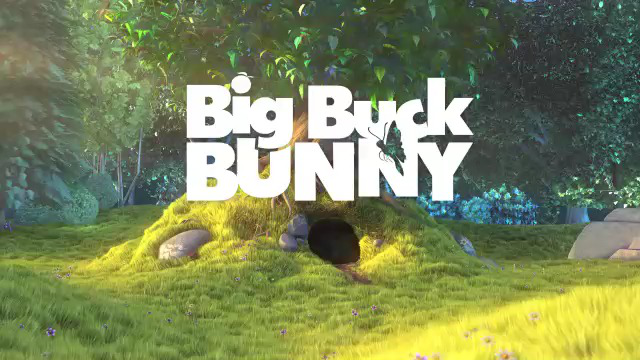

In [7]:
#plt.imshow(np.asarray(image))
#image.show()
display(image)

In [6]:
image = prepare_image(image)
print(image.shape)

(1, 360, 640, 3)


In [7]:
req.model_spec.name = "dense_crowd"
req.inputs["input_image"].CopyFrom(tf.make_tensor_proto(image, dtype=types_pb2.DT_FLOAT))
response = st.Predict(req, timeout=60.0)
p_hmap = tf.make_ndarray(response.outputs['y_out/Relu:0'])
#data["predict_time_ms"] = str(round((p_etime - p_stime)*1000))
count = np.sum(p_hmap)
print(count)

4.644


In [8]:
p_hmap = p_hmap.reshape(p_hmap.shape[1],p_hmap.shape[2])

In [102]:
#new_image_string = base64.b64encode(p_hmap)
pil_img = Image.fromarray(p_hmap,'RGB')

In [83]:
print((pil_img))

<PIL.Image.Image image mode=F size=80x45 at 0x7F0EAFE056A0>


In [105]:
if pil_img.mode != 'RGB':
    pil_img = pil_img.convert('RGB')
buff = io.BytesIO()
pil_img.save(buff, format="JPEG")
myimage = buff.getvalue() 
print("data:image/jpeg;base64,"+base64.b64encode(myimage))

TypeError: must be str, not bytes

In [93]:
# new_image_string = base64.b64encode(pil_img.tobytes())
# print(new_image_string)

b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEBzzjkQUxI7iNBwOzAp5TtPKDk8VPEKPIgXFDzwEdY7xEX4O0SL1zsgXPk7+JLqOySqvTuYlpU7wIepO5TTnzvUnbs74BatO+CTpTtou5Q7ONltOzC38TqAJRk5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIM9wOqC+kjp0nYA76P6IO+S+uju4WKU7/KsIPPxD7zvQFeM7AFuwO6i/kDuY7p07DKmsO7hO0TtctOY7jHbbOxjgyjsIRdw75JnPOxhU6zsAi8M7UBCwO+C2hjtgUlg7sFO9OoDyyDkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAvLjuA5Sw6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [92]:
nn = new_image_string.decode("utf-8")
print(nn)

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEBzzjkQUxI7iNBwOzAp5TtPKDk8VPEKPIgXFDzwEdY7xEX4O0SL1zsgXPk7+JLqOySqvTuYlpU7wIepO5TTnzvUnbs74BatO+CTpTtou5Q7ONltOzC38TqAJRk5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIM9wOqC+kjp0nYA76P6IO+S+uju4WKU7/KsIPPxD7zvQFeM7AFuwO6i/kDuY7p07DKmsO7hO0TtctOY7jHbbOxjgyjsIRdw75JnPOxhU6zsAi8M7UBCwO+C2hjtgUlg7sFO9OoDyyDkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAvLjuA5Sw6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

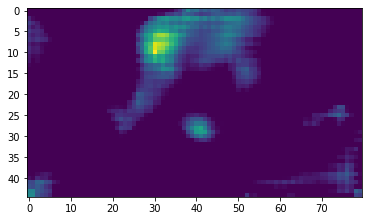

In [11]:
plt_obj = plt.imshow(p_hmap)

In [44]:
plt.imsave("pic.png",p_hmap)

In [51]:
cached_img = open("pic.png",mode='rb')
cached_img

<_io.BufferedReader name='pic.png'>

In [52]:
img_bytes = cached_img.read()
cached_img_b64 = base64.b64encode(img_bytes)
print(cached_img_b64)

b'iVBORw0KGgoAAAANSUhEUgAAAFAAAAAtCAYAAAA5reyyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAClNJREFUaIHtm8mSY8d1hr+TmXcALlCooUf2QJEm1Q63tJDDC9laaOMncOgB/DDe+23slVfeeCOHw4ygSIpii+6qZteIGXfKzOPFreog6ZbZzcYtNSP4RyCAQCFx8vx18owJ+Xv5jfIWQJIU+85twv4Oi0djzh8Lo0MIqTB6FmgLQ7KOtIXBtEo2DySLlphZJCh+aDFNRCKYJuBWDeb4Av/8GLQ/FV1v3/wKMOMxYg3xgweoM6z3M2wVacbC3ieK8ZBPW9yqJaaW6ARRR0iFtjDENCUkgvHgB0K6EGwTMasAPqJti1iLet+bDs5++D769BmxqnoT8m3EX/+CxcOc+YfgCyVmilsaELCVUB8ENFHczIJJyE9TfAH5KTQTSJbdc7MbkShIAAmQnzvyMyUdWbJpixnfx80PkIs54XyKts3WdXHtnQmJs7jpAn980qu5mzyn+bvHTH+a0u4IKkp2Zgg5DE4hpJCslXRucWslpkKyUlwZMV4xXgmnBolKOBOaHSE6QS2ohWTV7V2CoiJIiKgziAiSJv0Q6KYlnF7AeIQZDonr9daFAIhztL/8K6aPUqoDwY8UP4r4saCJElODH0fsyqBJJL0w5BdKSCFdKs3IkK4j1Z5ga6EdCc34UokSTNuRn6wjbh1IFjXiI+ZiSVwse9PLhZ0MFw9QwNy6QXzSjyB77y5VYWmLjrz2ZstgUtE2jhgEljl2bSiOBHVCftZZXLLpCHGbzvJUABHUgIoQE7CVYmuwtWKabh1BkbIB79Gm7UUnAGcXNbLcoMMcfMDuTgiz+dYFVR/cYvHQsXrfY3cb/uHRf/Pz4pBEAofNPv96+zHTzYDFcIdkYUhWYJdf+wKBMDCETGiLzgLrXUWiEDIhnUNSCiYoaqVbYw1xvenl6F

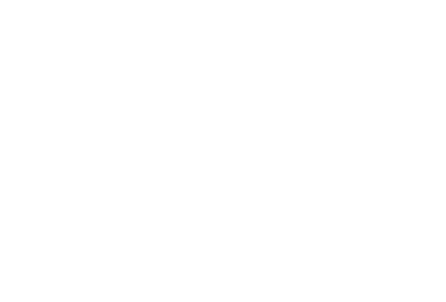

In [9]:
fig = plt.figure(frameon=False)
# fig.set_size_inches(p_hmap.shape[0],p_hmap.shape[1])
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

In [10]:
ax.imshow(p_hmap, aspect='auto')

In [11]:
ib = io.BytesIO()
fig.savefig(ib,bbox_inches='tight', pad_inches=0)

In [12]:
ib.seek(0)
pic_hash2 = base64.b64encode(ib.getvalue())
print(pic_hash2.decode("utf-8"))

iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAVdklEQVR4nO3dSXNbZ3bG8XMnACQ4iZI1WLLcdux2Kk4vksqikyyy6U+Q8gfIh8k+3yZZZZVNNp1KxVVu2+222hEli+IAEiTmO2ThqmRxnjeGWrKah/z/lofvHQACOPdWPTjIfpV91hlwTWVVz9WKd++5WrO/I7cff7LtaiefZnLt1oGvNT2/dut5I7dfDXNXqybt2mvzlX8r98/1sarxytXafiHXZo3fb73p1+ZLfa6ZKOdLfV7l5dKvPTz1x39xKLe3jo+zm8S/CwAACIAGBgAIiQYGAAiJBgYACIkGBgAIqfxjnwCQkm/7BKCZWVb46672o/fk2q70ayf7fVcr5jpBt9z2KcJbX+qkW1772mDk037lpa+ZmbU9n+xrS514zDr/1lWJR5VW/OFYPp3ZVPpY6nHVG35tb6y3L0Q6Mb/UKUSr/dpu5Z+vrNCJya4WJ4trizswAEBINDAAQEg0MABASDQwAEBINDAAQEg0MABASGXx8Yeu2D19Lhe38/lPfT64Adq/+wtXGz8euNr5x3r7euhj7G1fR9vLC3GNJtLexVxHwBe3fdy7qxLHOhPR7rxypcGRj7CbmdVDXxscyaW23PW16mK9dWZmyz0fV8/aRGRfJN5VbXCiv5UzOPbPV29Lx+D74msH+fYjVyvPb8vts9NzV2tORnJtt/KDgxELd2AAgJBoYACAkGhgAICQaGAAgJBoYACAkMrVfR9TqkqdECpHY1erD1/qPfPT3jdKPvApwuXffCrXjn7uU3irHZ+A6zL9Guof++uuxh/ezMw2RIqvESHAaqKP1Tv374Uy

### Testing TensorRT Server

In [1]:
import argparse
import numpy as np
import os
from builtins import range
from PIL import Image

In [2]:
from functools import partial
from tensorrtserver.api import *
import tensorrtserver.api.model_config_pb2 as model_config

In [3]:
FLAGS = {
    'url' : 'localhost:8000',
    'protocol': 'HTTP',
    'model_name': 'ssdcnet', # sparse_crowd, classify etc. can also be used
    'model_version': 1,
    'verbose': False,
    'streaming': False,
    'image_filename': '../image_examples/IMG_4.jpg'
}

In [4]:
# Check Protocal Type
protocol = ProtocolType.from_str(FLAGS['protocol'])
print(protocol)

ctx = InferContext(FLAGS['url'], protocol ,FLAGS['model_name'] ,
                       FLAGS['model_version'] , FLAGS['verbose'] , 0, FLAGS['streaming'])

ProtocolType.HTTP


In [5]:
# Parsing and checking the model
srv_status_ssdcnet = ServerStatusContext(FLAGS['url'], protocol ,FLAGS['model_name'], FLAGS['verbose'])
srv_status_ssdcnet.get_server_status()

id: "inference:0"
version: "1.12.0"
uptime_ns: 1085441881059
model_status {
  key: "ssdcnet"
  value {
    config {
      name: "ssdcnet"
      platform: "pytorch_libtorch"
      version_policy {
        latest {
          num_versions: 1
        }
      }
      input {
        name: "INPUT__0"
        data_type: TYPE_FP32
        format: FORMAT_NCHW
        dims: 3
        dims: 768
        dims: 1024
      }
      output {
        name: "output__0"
        data_type: TYPE_FP32
        dims: 1
      }
      instance_group {
        name: "ssdcnet"
        count: 1
        kind: KIND_CPU
      }
      default_model_filename: "model.pt"
      optimization {
        input_pinned_memory {
          enable: true
        }
        output_pinned_memory {
          enable: true
        }
      }
    }
    version_status {
      key: 1
      value {
        ready_state: MODEL_READY
        infer_stats {
          key: 1
          value {
            failed {
              count: 1
            

In [6]:
# Parsing and checking the model
srv_status_dense = ServerStatusContext(FLAGS['url'], protocol ,FLAGS['model_name'], FLAGS['verbose'])
srv_status_sparse = ServerStatusContext(FLAGS['url'], protocol ,'sparse_crowd', FLAGS['verbose'])
srv_status_classify = ServerStatusContext(FLAGS['url'], protocol ,'classify' , FLAGS['verbose'])

In [25]:
# Roundabout way to get auto built Config File from the SavedModel instance.
srv_status_dense.get_server_status()

id: "inference:0"
version: "1.12.0"
uptime_ns: 5758664320377
model_status {
  key: "dense_crowd"
  value {
    config {
      name: "dense_crowd"
      platform: "tensorflow_savedmodel"
      version_policy {
        latest {
          num_versions: 1
        }
      }
      max_batch_size: 1
      input {
        name: "input_image"
        data_type: TYPE_FP32
        dims: -1
        dims: -1
        dims: 3
      }
      output {
        name: "y_out/Relu:0"
        data_type: TYPE_FP32
        dims: -1
        dims: -1
        dims: 1
      }
      instance_group {
        name: "dense_crowd"
        count: 1
        kind: KIND_CPU
      }
      default_model_filename: "model.savedmodel"
      optimization {
        input_pinned_memory {
          enable: true
        }
        output_pinned_memory {
          enable: true
        }
      }
    }
    version_status {
      key: 1234
      value {
        ready_state: MODEL_READY
        ready_state_reason {
        }
      }
    }

In [26]:
srv_status_sparse.get_server_status()

id: "inference:0"
version: "1.12.0"
uptime_ns: 5902386304348
model_status {
  key: "sparse_crowd"
  value {
    config {
      name: "sparse_crowd"
      platform: "tensorflow_savedmodel"
      version_policy {
        latest {
          num_versions: 1
        }
      }
      max_batch_size: 1
      input {
        name: "input_image"
        data_type: TYPE_FP32
        dims: -1
        dims: -1
        dims: 3
      }
      output {
        name: "y_out/Relu:0"
        data_type: TYPE_FP32
        dims: -1
        dims: -1
        dims: 1
      }
      instance_group {
        name: "sparse_crowd"
        count: 1
        kind: KIND_CPU
      }
      default_model_filename: "model.savedmodel"
      optimization {
        input_pinned_memory {
          enable: true
        }
        output_pinned_memory {
          enable: true
        }
      }
    }
    version_status {
      key: 32123
      value {
        ready_state: MODEL_READY
        ready_state_reason {
        }
      }
 

In [27]:
srv_status_classify.get_server_status()

id: "inference:0"
version: "1.12.0"
uptime_ns: 5955982759065
model_status {
  key: "classify"
  value {
    config {
      name: "classify"
      platform: "tensorflow_savedmodel"
      version_policy {
        latest {
          num_versions: 1
        }
      }
      max_batch_size: 1
      input {
        name: "input_image"
        data_type: TYPE_FP32
        dims: 224
        dims: 224
        dims: 3
      }
      output {
        name: "dense_11/Softmax:0"
        data_type: TYPE_FP32
        dims: 2
      }
      instance_group {
        name: "classify"
        count: 1
        kind: KIND_CPU
      }
      default_model_filename: "model.savedmodel"
      optimization {
        input_pinned_memory {
          enable: true
        }
        output_pinned_memory {
          enable: true
        }
      }
    }
    version_status {
      key: 1
      value {
        ready_state: MODEL_READY
        ready_state_reason {
        }
      }
    }
  }
}
ready_state: SERVER_READY